In [ ]:
# Analyse Exploratoire des Données Cinématographiques

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def explorer_dataset(nom_fichier):
    """Fonction utilitaire pour l'exploration des datasets.
    
    Args:
        nom_fichier (str): Chemin du fichier à analyser (CSV ou TSV.GZ)
        
    Returns:
        pandas.DataFrame: DataFrame contenant les données chargées
    """
    if nom_fichier.endswith('.csv'):
        df = pd.read_csv(nom_fichier)
    elif nom_fichier.endswith('.tsv.gz'):
        df = pd.read_csv(nom_fichier, compression='gzip', sep='\t')
    else:
        print("Format de fichier non supporté.")
        return
        
    display(df.head())
    print("\nAnalyse quantitative :")
    print(df.describe(include='all'))
    print("\nInfo sur le dataset :")
    print(df.info(show_counts = True))

    descriptive_vars = df.select_dtypes(include=['object']).columns
    numeric_vars = df.select_dtypes(include=['number']).columns

    print("\nVariables descriptives :")
    print(descriptive_vars)
    print("\nVariables numériques :")
    print(numeric_vars)
    return df

# Analyse des Données pour un Système de Recommandation de Films

Ce notebook présente l'exploration et l'analyse approfondie des datasets MovieLens et IMDB, dans le cadre du développement d'un système de recommandation de films.

## Objectifs

1. Analyser les patterns de notation des utilisateurs
2. Explorer les caractéristiques des films
3. Préparer les données pour la modélisation

## Sources de Données

1. **MovieLens 20M Dataset**
   - 20 millions d'évaluations
   - Notes d'utilisateurs (1-5 étoiles)
   - Tags et métadonnées des films
   - Source: GroupLens Research

2. **IMDB Dataset**
   - Informations détaillées sur les films
   - Métadonnées: acteurs, réalisateurs, genres
   - Notes moyennes et nombre de votes

## Movie Lens
https://grouplens.org/datasets/movielens/20m/

## Analyse des Évaluations (Ratings)

Commençons par analyser en détail les patterns de notation des utilisateurs dans le dataset MovieLens.

In [8]:
# Chargement des données de ratings
df_ml = pd.read_csv("./data/ml-20m/ratings.csv")

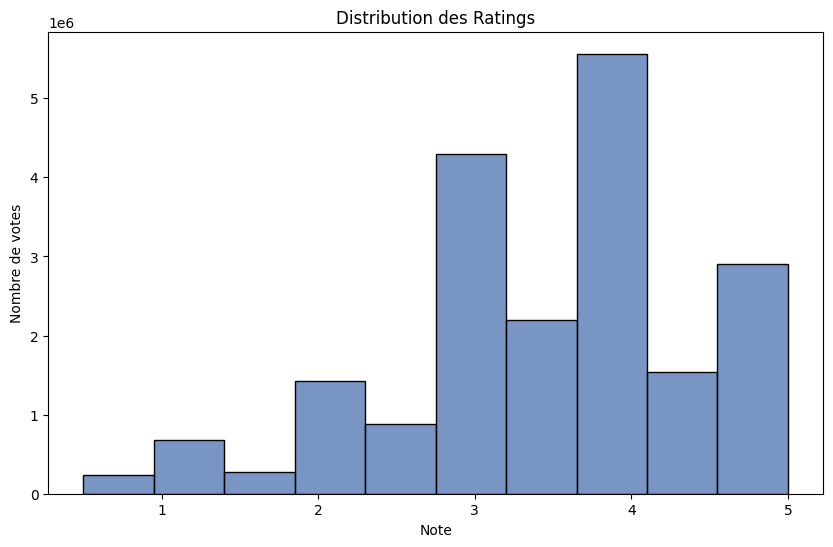

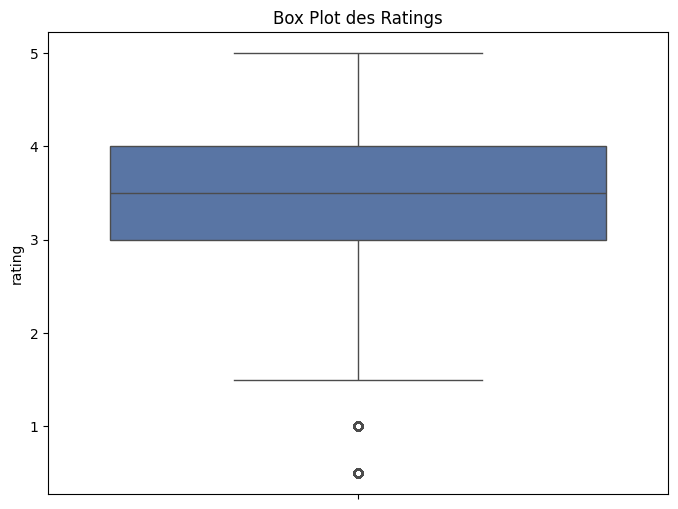

In [9]:
# Distribution des notes
plt.style.use('seaborn-v0_8-deep')
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ml, x='rating', bins=10)
plt.title('Distribution des Ratings')
plt.xlabel('Note')
plt.ylabel('Nombre de votes')
plt.show()

# Box plot des notes
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_ml['rating'])
plt.title('Box Plot des Ratings')
plt.show()

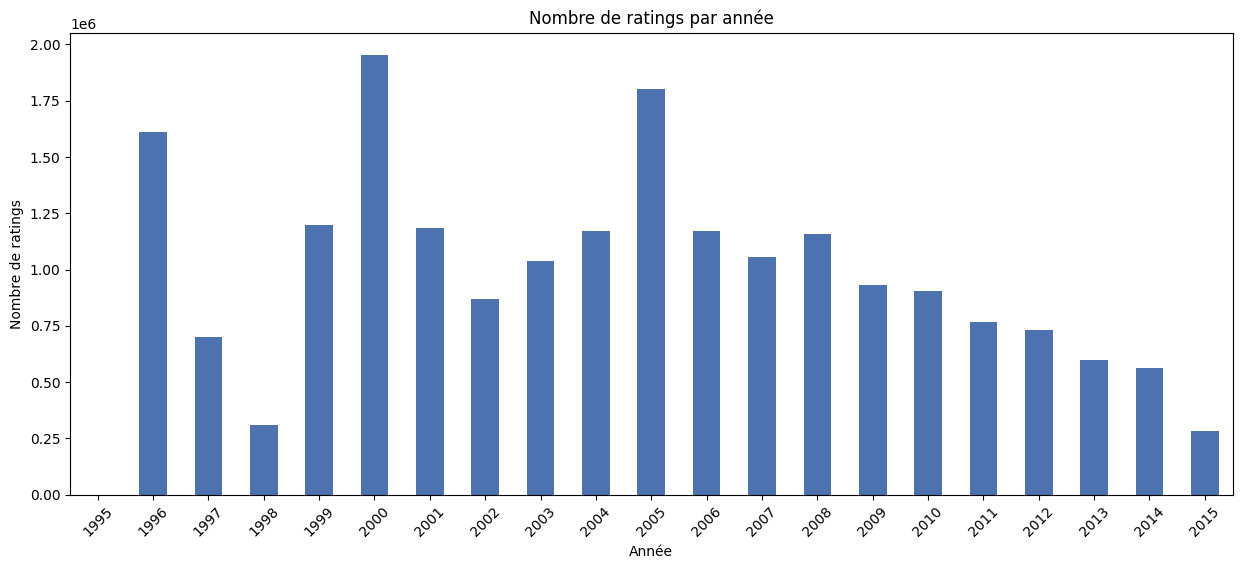

In [10]:
# Analyse temporelle
df_ml['datetime'] = pd.to_datetime(df_ml['timestamp'], unit='s')

plt.figure(figsize=(15, 6))
df_ml.groupby(df_ml['datetime'].dt.year)['rating'].count().plot(kind='bar')
plt.title('Nombre de ratings par année')
plt.xlabel('Année')
plt.ylabel('Nombre de ratings')
plt.xticks(rotation=45)
plt.show()

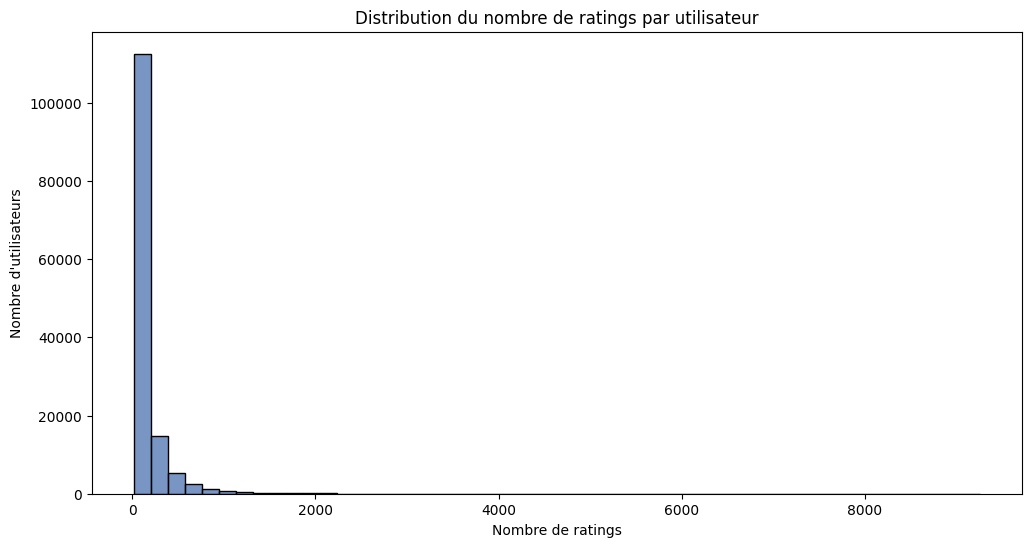

In [11]:
# Distribution des notes par utilisateur
ratings_per_user = df_ml.groupby('userId')['rating'].count()

plt.figure(figsize=(12, 6))
sns.histplot(ratings_per_user, bins=50)
plt.title('Distribution du nombre de ratings par utilisateur')
plt.xlabel('Nombre de ratings')
plt.ylabel('Nombre d\'utilisateurs')
plt.show()

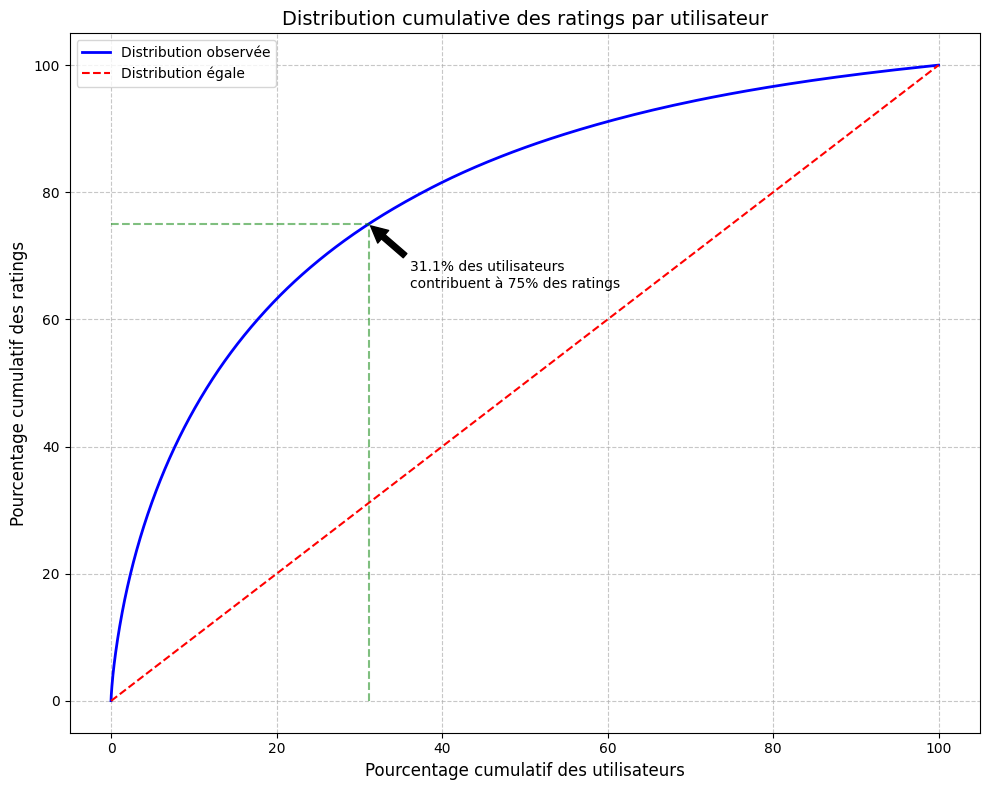

31.1% des utilisateurs contribuent à 75% des ratings


In [13]:
import numpy as np

ratings_per_user = (
    df_ml.groupby("userId")["rating"].count().sort_values(ascending=False)
)

total_ratings = ratings_per_user.sum()
cumsum_ratings = ratings_per_user.cumsum()
percent_ratings = (cumsum_ratings / total_ratings) * 100
percent_users = np.arange(1, len(ratings_per_user) + 1) / len(ratings_per_user) * 100

users_for_75 = percent_users[np.where(percent_ratings >= 75)[0][0]]

plt.figure(figsize=(10, 8))

plt.plot(
    percent_users, percent_ratings, "b-", linewidth=2, label="Distribution observée"
)
plt.plot([0, 100], [0, 100], "r--", label="Distribution égale")

# Lignes pour le seuil de 75%
plt.plot([users_for_75, users_for_75], [0, 75], "g--", alpha=0.5)
plt.plot([0, users_for_75], [75, 75], "g--", alpha=0.5)

plt.annotate(
    f"{users_for_75:.1f}% des utilisateurs\ncontribuent à 75% des ratings",
    xy=(users_for_75, 75),
    xytext=(users_for_75 + 5, 65),
    arrowprops=dict(facecolor="black", shrink=0.05),
)

plt.title("Distribution cumulative des ratings par utilisateur", fontsize=14)
plt.xlabel("Pourcentage cumulatif des utilisateurs", fontsize=12)
plt.ylabel("Pourcentage cumulatif des ratings", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

print(f"{users_for_75:.1f}% des utilisateurs contribuent à 75% des ratings")


Statistiques détaillées:
< 5 notes: 8,399 films (31.4%)
5-20 notes: 5,213 films (19.5%)
20-100 notes: 4,586 films (17.1%)
100-1000 notes: 5,387 films (20.1%)
> 1000 notes: 3,159 films (11.8%)


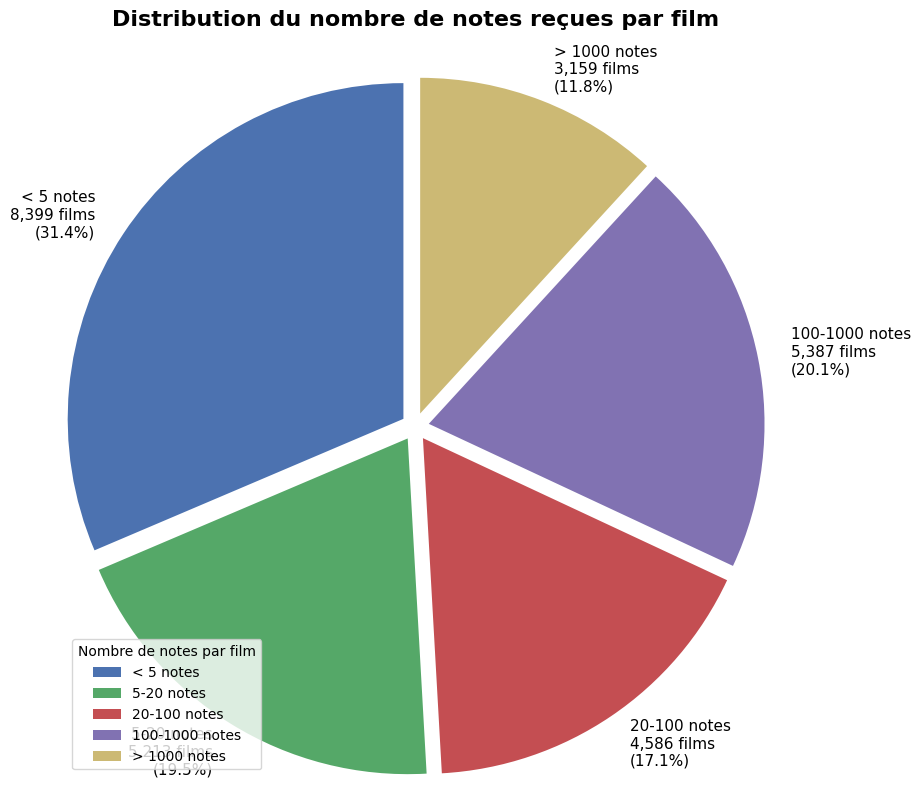

In [14]:
ratings_per_movie = df_ml.groupby("movieId")["rating"].count()

bins = [0, 5, 20, 100, 1000, float("inf")]
labels = ["< 5 notes", "5-20 notes", "20-100 notes", "100-1000 notes", "> 1000 notes"]

movie_categories = pd.cut(ratings_per_movie, bins=bins, labels=labels, right=False)
category_counts = movie_categories.value_counts().sort_index()

percentages = (category_counts / len(ratings_per_movie) * 100).round(1)

plt.figure(figsize=(12, 8))


labels_with_stats = [
    f"{label}\n{count:,} films\n({pct}%)"
    for label, count, pct in zip(labels, category_counts, percentages)
]

explode = [0.05] * len(labels)

wedges, texts, autotexts = plt.pie(
    category_counts,
    explode=explode,
    labels=labels_with_stats,
    autopct="",
    startangle=90,
    radius=1.2,
)

plt.title(
    "Distribution du nombre de notes reçues par film\n",
    fontsize=16,
    pad=20,
    fontweight="bold",
)

plt.setp(texts, size=11)

plt.legend(wedges, labels, title="Nombre de notes par film", loc="lower left")

plt.tight_layout()

print("\nStatistiques détaillées:")
for label, count, percentage in zip(labels, category_counts, percentages):
    print(f"{label}: {count:,} films ({percentage}%)")

plt.show()

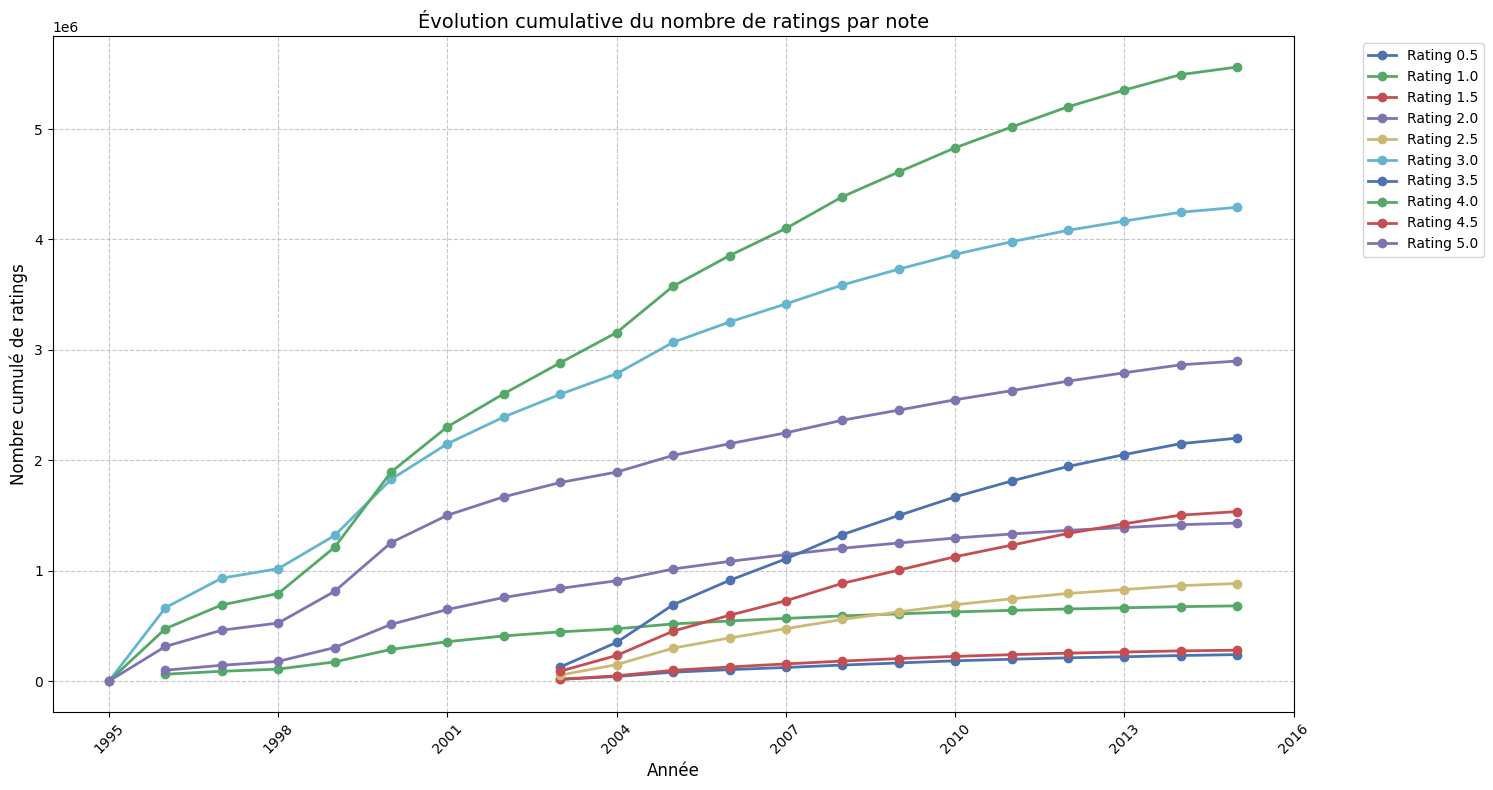

In [15]:
df_ml["datetime"] = pd.to_datetime(df_ml["timestamp"], unit="s")

plt.figure(figsize=(15, 8))

for rating in sorted(df_ml["rating"].unique()):
    temp_df = df_ml[df_ml["rating"] == rating]
    yearly_counts = (
        temp_df.groupby(temp_df["datetime"].dt.year)["rating"].count().cumsum()
    )

    yearly_counts.index = yearly_counts.index.astype(int)

    plt.plot(
        yearly_counts.index,
        yearly_counts.values,
        label=f"Rating {rating}",
        marker="o",
        linewidth=2,
    )

plt.title("Évolution cumulative du nombre de ratings par note", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre cumulé de ratings", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Statistiques détaillées:
< 20 films: 0 utilisateurs (0.0%)
20-30 films: 25,944 utilisateurs (18.7%)
30-50 films: 27,242 utilisateurs (19.7%)
50-100 films: 32,711 utilisateurs (23.6%)
100-200 films: 25,770 utilisateurs (18.6%)
> 200 films: 26,826 utilisateurs (19.4%)


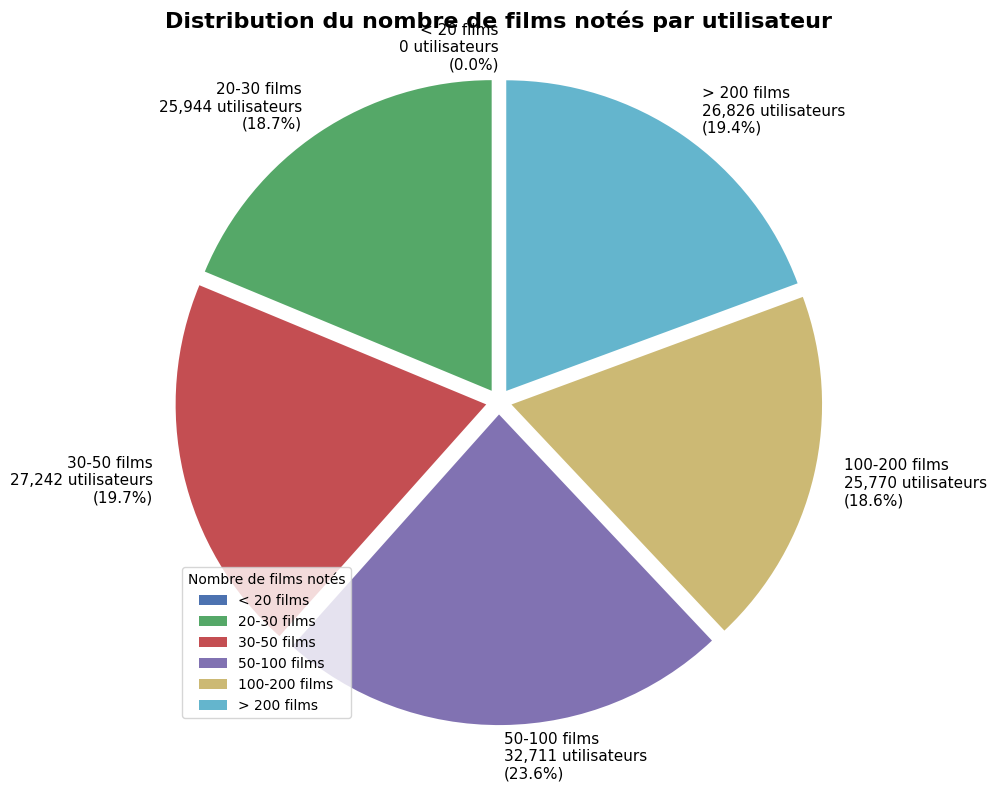

In [16]:
ratings_per_user = df_ml.groupby("userId")["rating"].count()

bins = [0, 20, 30, 50, 100, 200, float("inf")]
labels = [
    "< 20 films",
    "20-30 films",
    "30-50 films",
    "50-100 films",
    "100-200 films",
    "> 200 films",
]

user_categories = pd.cut(ratings_per_user, bins=bins, labels=labels, right=False)
category_counts = user_categories.value_counts().sort_index()

percentages = (category_counts / len(ratings_per_user) * 100).round(1)

plt.figure(figsize=(12, 8))

labels_with_stats = [
    f"{label}\n{count:,} utilisateurs\n({pct}%)"
    for label, count, pct in zip(labels, category_counts, percentages)
]

explode = [0.05] * len(labels)  # Légère explosion pour tous les secteurs

wedges, texts, autotexts = plt.pie(
    category_counts,
    explode=explode,
    labels=labels_with_stats,
    autopct="",
    startangle=90,
    radius=1.2,
)

plt.title(
    "Distribution du nombre de films notés par utilisateur\n",
    fontsize=16,
    pad=20,
    fontweight="bold",
)

plt.setp(texts, size=11)

plt.legend(wedges, labels, title="Nombre de films notés", loc="lower left")

plt.tight_layout()

print("\nStatistiques détaillées:")
for label, count, percentage in zip(labels, category_counts, percentages):
    print(f"{label}: {count:,} utilisateurs ({percentage}%)")

plt.show()


Statistiques par catégorie d'utilisateurs:
----------------------------------------

Catégorie: < 20 films
Nombre d'utilisateurs: count    0.0
Name: < 20 films, dtype: float64
Note moyenne: nan ± nan

Catégorie: 20-30 films
Nombre d'utilisateurs: count    25944.0
Name: 20-30 films, dtype: float64
Note moyenne: 3.58 ± 0.52

Catégorie: 30-50 films
Nombre d'utilisateurs: count    27242.0
Name: 30-50 films, dtype: float64
Note moyenne: 3.68 ± 0.43

Catégorie: 50-100 films
Nombre d'utilisateurs: count    32711.0
Name: 50-100 films, dtype: float64
Note moyenne: 3.69 ± 0.42

Catégorie: 100-200 films
Nombre d'utilisateurs: count    25770.0
Name: 100-200 films, dtype: float64
Note moyenne: 3.66 ± 0.41

Catégorie: > 200 films
Nombre d'utilisateurs: count    26826.0
Name: > 200 films, dtype: float64
Note moyenne: 3.52 ± 0.41


C:\Users\wwps1172\AppData\Local\Temp\ipykernel_23124\1666542816.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_stats.groupby("category")


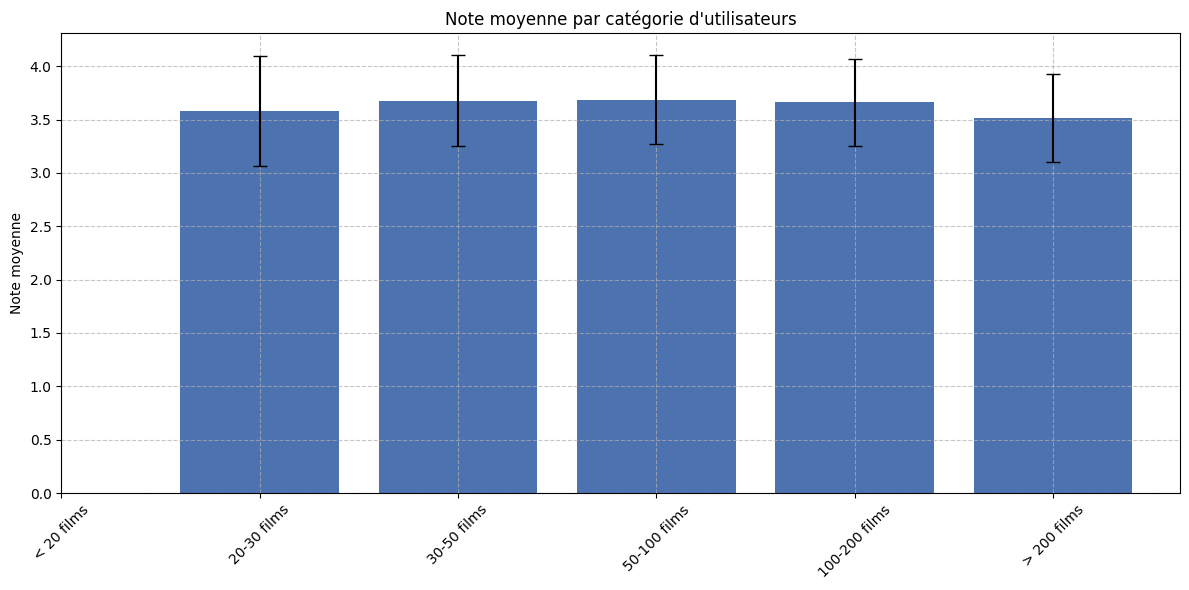

In [17]:
# DataFrame avec le nombre de films notés et la moyenne des notes par utilisateur
user_stats = df_ml.groupby("userId").agg({"rating": ["count", "mean"]}).reset_index()
user_stats.columns = ["userId", "nb_ratings", "avg_rating"]

bins = [0, 20, 30, 50, 100, 200, float("inf")]
labels = [
    "< 20 films",
    "20-30 films",
    "30-50 films",
    "50-100 films",
    "100-200 films",
    "> 200 films",
]
user_stats["category"] = pd.cut(
    user_stats["nb_ratings"], bins=bins, labels=labels, right=False
)

# statistiques par catégorie
category_stats = (
    user_stats.groupby("category")
    .agg({"userId": "count", "avg_rating": ["mean", "std"]})
    .round(3)
)

plt.figure(figsize=(12, 6))
plt.bar(
    range(len(labels)),
    category_stats["avg_rating"]["mean"],
    yerr=category_stats["avg_rating"]["std"],
    capsize=5,
)
plt.xticks(range(len(labels)), labels, rotation=45)
plt.title("Note moyenne par catégorie d'utilisateurs")
plt.ylabel("Note moyenne")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

print("\nStatistiques par catégorie d'utilisateurs:")
print("----------------------------------------")
for idx in category_stats.index:
    print(f"\nCatégorie: {idx}")
    print(f"Nombre d'utilisateurs: {category_stats.loc[idx, 'userId']}")
    print(
        f"Note moyenne: {category_stats.loc[idx, 'avg_rating']['mean']:.2f} ± {category_stats.loc[idx, 'avg_rating']['std']:.2f}"
    )

plt.show()

### Observations Clés sur les Évaluations

1. **Distribution des Notes**
   - La majorité des notes se situe entre 3 et 4 étoiles
   - La distribution est légèrement asymétrique vers la droite
   - Très peu de notes extrêmes (1 ou 5 étoiles)

2. **Évolution Temporelle**
   - Augmentation significative du nombre de notes à partir de 2003
   - Changement possible dans le système de notation à cette période

3. **Comportement des Utilisateurs**
   - La majorité des utilisateurs ont noté entre 20 et 200 films
   - Distribution log-normale du nombre de notes par utilisateur
   - Présence d'utilisateurs très actifs avec plus de 1000 notes

## Comparaison avec les Évaluations IMDB

Analysons maintenant les évaluations provenant d'IMDB pour comparer les deux sources de données.

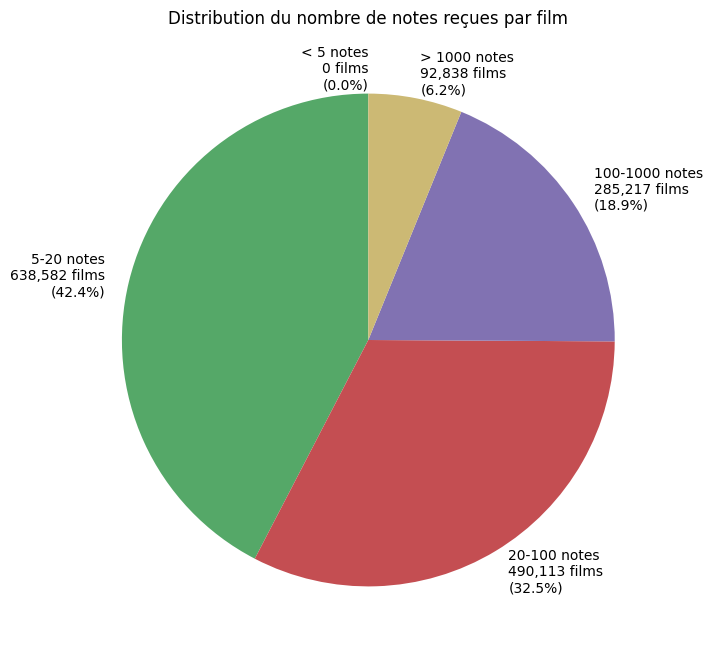


Statistiques détaillées:
< 5 notes: 0 films (0.0%)
5-20 notes: 638,582 films (42.4%)
20-100 notes: 490,113 films (32.5%)
100-1000 notes: 285,217 films (18.9%)
> 1000 notes: 92,838 films (6.2%)


In [12]:
# Chargement des données IMDB
df_imdb_ratings = pd.read_csv("./data/imdb/title.ratings.tsv.gz", compression="gzip", sep="\t")

# Distribution du nombre de votes par film
bins = [0, 5, 20, 100, 1000, float('inf')]
labels = ['< 5 notes', '5-20 notes', '20-100 notes', '100-1000 notes', '> 1000 notes']

movie_categories = pd.cut(df_imdb_ratings['numVotes'], bins=bins, labels=labels, right=False)
category_counts = movie_categories.value_counts().sort_index()

percentages = (category_counts / len(df_imdb_ratings) * 100).round(1)

plt.figure(figsize=(12, 8))

labels_with_stats = [f'{label}\n{count:,} films\n({pct}%)' 
                    for label, count, pct in zip(labels, category_counts, percentages)]

plt.pie(category_counts, 
        labels=labels_with_stats, 
        autopct='',
        startangle=90)

plt.title('Distribution du nombre de notes reçues par film')
plt.show()

print("\nStatistiques détaillées:")
for label, count, percentage in zip(labels, category_counts, percentages):
    print(f"{label}: {count:,} films ({percentage}%)")

### Comparaison MovieLens vs IMDB

1. **Couverture**
   - IMDB couvre un plus grand nombre de films (1.5M vs 27K)
   - MovieLens se concentre sur les films plus populaires

2. **Qualité des Évaluations**
   - MovieLens : notes individuelles d'utilisateurs engagés
   - IMDB : notes agrégées du grand public

3. **Granularité**
   - MovieLens : données temporelles et par utilisateur
   - IMDB : moyennes globales uniquement

4. **Implications pour le Système de Recommandation**
   - MovieLens : meilleur pour les recommandations personnalisées
   - IMDB : utile pour la validation croisée et le filtrage initial des films

## Structure des Données

Maintenant que nous avons analysé les patterns de notation, explorons la structure détaillée de chaque dataset.

### Movie

In [2]:
explorer_dataset("./data/ml-20m/movies.csv")

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

Analyse quantitative :
              movieId            title genres
count    27278.000000            27278  27278
unique            NaN            27262   1342
top               NaN  Casanova (2005)  Drama
freq              NaN                2   4520
mean     59855.480570              NaN    NaN
std      44429.314697              NaN    NaN
min          1.000000              NaN    NaN
25%       6931.250000              NaN    NaN
50%      68068.000000              NaN    NaN
75%     100293.250000              NaN    NaN
max     131262.000000              NaN    NaN

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Variables descriptives :
Index(['title', 'genres'],

<table>
  <caption>Movie: table informations film</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Film id</td>
    </tr>
    <tr>
      <td>title</td>
      <td>Titre</td>
    </tr>
    <tr>
      <td>genres</td>
      <td>Liste des genres</td>
    </tr>
  </tbody>
</table>


### Genome scores

In [3]:
explorer_dataset("./data/ml-20m/genome-scores.csv")

movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675

Analyse quantitative :
            movieId         tagId     relevance
count  1.170977e+07  1.170977e+07  1.170977e+07
mean   2.584297e+04  5.645000e+02  1.164833e-01
std    3.467615e+04  3.256254e+02  1.542463e-01
min    1.000000e+00  1.000000e+00  2.500000e-04
25%    2.926000e+03  2.827500e+02  2.425000e-02
50%    6.017000e+03  5.645000e+02  5.650000e-02
75%    4.606200e+04  8.462500e+02  1.415000e-01
max    1.311700e+05  1.128000e+03  1.000000e+00

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   movieId    11709768 non-null  int64  
 1   tagId      11709768 non-null  int64  
 2   relevance  11709768 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB
None

Variables descriptives :
Index([], dtype='object')

Variables numériques :
Index(['movieId', 'tagId', 'relevance'], dtype='object')


<table>
  <caption>genome-scores: Liste de tag associés au film</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Film id</td>
    </tr>
    <tr>
      <td>tagId</td>
      <td>Id du tag</td>
    </tr>
    <tr>
      <td>relevance</td>
      <td>Evaluation de la pertinence du tag</td>
    </tr>
  </tbody>
</table>


### Genome tag

In [4]:
explorer_dataset("./data/ml-20m/genome-tags.csv")

tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

Analyse quantitative :
              tagId      tag
count   1128.000000     1128
unique          NaN     1128
top             NaN  zombies
freq            NaN        1
mean     564.500000      NaN
std      325.769857      NaN
min        1.000000      NaN
25%      282.750000      NaN
50%      564.500000      NaN
75%      846.250000      NaN
max     1128.000000      NaN

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB
None

Variables descriptives :
Index(['tag'], dtype='object')

Variables numériques :
Index(['tagId'], dtype='object')


<table>
  <caption>genome-tags: Liste de description des tags</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    </tr>
    <tr>
      <td>tagId</td>
      <td>Id du tag</td>
    </tr>
    <tr>
      <td>tag</td>
      <td>Description du tag</td>
    </tr>
  </tbody>
</table>


### links

In [5]:
explorer_dataset("./data/ml-20m/links.csv")

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

Analyse quantitative :
             movieId        imdbId         tmdbId
count   27278.000000  2.727800e+04   27026.000000
mean    59855.480570  5.781860e+05   63846.683083
std     44429.314697  7.804707e+05   69862.134497
min         1.000000  5.000000e+00       2.000000
25%      6931.250000  7.741725e+04   15936.500000
50%     68068.000000  1.524350e+05   39468.500000
75%    100293.250000  9.062715e+05   82504.000000
max    131262.000000  4.530184e+06  421510.000000

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 639.5 KB
None

Variables descriptives :
Index([], dtype='object')

Variables numériques :
Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')


<table>
<caption>Link: Liens pour faire des jointures avec d'autres BDD</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Id du film</td>
    </tr>
    <tr>
      <td>imdbId</td>
      <td>Id dans la base Imdb</td>
    </tr>
    <tr>
      <td>tmdbId</td>
      <td>Id dans la base Tmdb</td>
    </tr>
  </tbody>
</table>


### Ratings

In [6]:
explorer_dataset("./data/ml-20m/ratings.csv")

userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580

Analyse quantitative :
             userId       movieId        rating     timestamp
count  2.000026e+07  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00  1.100918e+09
std    4.003863e+04  1.978948e+04  1.051989e+00  1.621694e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    3.439500e+04  9.020000e+02  3.000000e+00  9.667977e+08
50%    6.914100e+04  2.167000e+03  3.500000e+00  1.103556e+09
75%    1.036370e+05  4.770000e+03  4.000000e+00  1.225642e+09
max    1.384930e+05  1.312620e+05  5.000000e+00  1.427784e+09

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     20000263 non-null  int64  
 1   movieId    20000263 non-null  int64  
 2   rating     20000263 non-null  float64
 3   timestamp  20000263 non-null  int64  
dtypes: float64(1), int6

<table>
<caption>Ratings: Table des notes</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>userId</td>
      <td>Id du l'utilisateur notant</td>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Id du film noté</td>
    </tr>
    <tr>
      <td>rating</td>
      <td>Note</td>
    </tr>
    <tr>
      <td>timestamp</td>
      <td>timestamp de la date à laquelle l'utilisateur a noté</td>
    </tr>
  </tbody>
</table>


### Tags

In [7]:
explorer_dataset("./data/ml-20m/tags.csv")

userId  movieId            tag   timestamp
0      18     4141    Mark Waters  1240597180
1      65      208      dark hero  1368150078
2      65      353      dark hero  1368150079
3      65      521  noir thriller  1368149983
4      65      592      dark hero  1368150078

Analyse quantitative :
               userId        movieId     tag     timestamp
count   465564.000000  465564.000000  465548  4.655640e+05
unique            NaN            NaN   38643           NaN
top               NaN            NaN  sci-fi           NaN
freq              NaN            NaN    3384           NaN
mean     68712.354263   32627.762920     NaN  1.298711e+09
std      41877.674053   36080.241157     NaN  7.920891e+07
min         18.000000       1.000000     NaN  1.135429e+09
25%      28780.000000    2571.000000     NaN  1.245007e+09
50%      70201.000000    7373.000000     NaN  1.302291e+09
75%     107322.000000   62235.000000     NaN  1.366218e+09
max     138472.000000  131258.000000     NaN  1.427771e+09

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465564 non-null  int64 
 1   movieId    

<table>
  <caption>Table des tags par films</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>userId</td>
      <td>Id du l'utilisateur ayant créé le tag</td>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Id du film taggé</td>
    </tr>
    <tr>
      <td>timestamp</td>
      <td>timestamp de la date à laquelle l'utilisateur a créé le tag</td>
    </tr>
  </tbody>
</table>


### Résumé Movie Lens

<div>
<table>
  <caption>Movie: table informations film</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Film id</td>
    </tr>
    <tr>
      <td>title</td>
      <td>Titre</td>
    </tr>
    <tr>
      <td>genres</td>
      <td>Liste des genres</td>
    </tr>
  </tbody>
</table>
</br>
<table>
  <caption>genome-scores: Table des tags associés au film</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Film id</td>
    </tr>
    <tr>
      <td>tagId</td>
      <td>Id du tag</td>
    </tr>
    <tr>
      <td>relevance</td>
      <td>Evaluation de la pertinence du tag</td>
    </tr>
  </tbody>
</table>
</br>

<table>
  <caption>genome-tags: Table de description des tags</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    </tr>
    <tr>
      <td>tagId</td>
      <td>Id du tag</td>
    </tr>
    <tr>
      <td>tag</td>
      <td>Description du tag</td>
    </tr>
  </tbody>
</table>
</br>

<table>
<caption>Link: Liens pour faire des jointures avec d'autres BDD</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Id du film</td>
    </tr>
    <tr>
      <td>imdbId</td>
      <td>Id dans la base Imdb</td>
    </tr>
    <tr>
      <td>tmdbId</td>
      <td>Id dans la base Tmdb</td>
    </tr>
  </tbody>
</table>
</br>

<table>
<caption>Ratings: Table des notes</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>userId</td>
      <td>Id du l'utilisateur notant</td>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Id du film noté</td>
    </tr>
    <tr>
      <td>rating</td>
      <td>Note</td>
    </tr>
    <tr>
      <td>timestamp</td>
      <td>timestamp de la date à laquelle l'utilisateur a noté</td>
    </tr>
  </tbody>
</table>
</br>

<table>
  <caption>Tags: Table des tags par films</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>userId</td>
      <td>Id du l'utilisateur ayant créé le tag</td>
    </tr>
    <tr>
      <td>movieId</td>
      <td>Id du film taggé</td>
    </tr>
    <tr>
      <td>timestamp</td>
      <td>timestamp de la date à laquelle l'utilisateur a créé le tag</td>
    </tr>
  </tbody>
</table>
</div>

## IMDB
https://datasets.imdbws.com/

### Crew

In [8]:
explorer_dataset("./data/imdb/title.crew.tsv.gz")

tconst  directors writers
0  tt0000001  nm0005690      \N
1  tt0000002  nm0721526      \N
2  tt0000003  nm0721526      \N
3  tt0000004  nm0721526      \N
4  tt0000005  nm0005690      \N

Analyse quantitative :
           tconst directors   writers
count    10612480  10612480  10612480
unique   10612480    931124   1384347
top     tt9916776        \N        \N
freq            1   4053171   4713999

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10612480 entries, 0 to 10612479
Data columns (total 3 columns):
 #   Column     Non-Null Count     Dtype 
---  ------     --------------     ----- 
 0   tconst     10612480 non-null  object
 1   directors  10612480 non-null  object
 2   writers    10612480 non-null  object
dtypes: object(3)
memory usage: 242.9+ MB
None

Variables descriptives :
Index(['tconst', 'directors', 'writers'], dtype='object')

Variables numériques :
Index([], dtype='object')


<table>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Film id</td>
    </tr>
    <tr>
      <td>directors</td>
      <td>Réalisateur id</td>
    </tr>
    <tr>
      <td>writers</td>
      <td>Scénariste id</td>
    </tr>
  </tbody>
</table>


### Name basics

In [9]:
explorer_dataset("./data/imdb/name.basics.tsv.gz")

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                    primaryProfession                           knownForTitles  
0        actor,miscellaneous,producer  tt0050419,tt0072308,tt0053137,tt0043044  
1  actress,soundtrack,archive_footage  tt0037382,tt0075213,tt0117057,tt0038355  
2   actress,music_department,producer  tt0057345,tt0049189,tt0056404,tt0054452  
3       actor,writer,music_department  tt0072562,tt0077975,tt0080455,tt0078723  
4               writer,director,actor  tt0050986,tt0069467,tt0050976,tt0083922

Analyse quantitative :
           nconst primaryName birthYear deathYear primaryProfession  \
count    13992786    13992777  13992786  13992786          13992786   
unique   13992786    10742759       552       489             23097   
top     nm9993719        Alex        \N        \N                \N   
freq            1         529  13360152  13755576           2716189   

       knownForTitles  
count        13992786  
unique        5826972  
top                \N  
freq          1582618  

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13992786 entries, 0 to 13992785
Data columns (total 6 columns):
 #   Column             Non-Null Count     Dtype 
---  ------             --------------     ----- 
 0   nconst             13992786 non-null  object
 1   primaryName        13992777 non-null  object
 2   birthYear          13992786 non-null  object
 3   deathYear          13992786 non-null  object
 4   primaryProfession  13992786 non-null  object
 5   knownForT

<table>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>nconst</td>
      <td>Id d'une personne</td>
    </tr>
    <tr>
      <td>primaryName</td>
      <td>nom/prénom</td>
    </tr>
    <tr>
      <td>birthYear</td>
      <td>Date de naissance</td>
    </tr>
    <tr>
      <td>deathYear</td>
      <td>Date de décès</td>
    </tr>
    <tr>
      <td>primaryProfession</td>
      <td>Professions</td>
    </tr>
    <tr>
      <td>primaryProfession</td>
      <td>Id des films notables auxquels cette personne a contribué</td>
    </tr>
  </tbody>
</table>


### Akas

In [10]:
explorer_dataset("./data/imdb/title.akas.tsv.gz")

titleId  ordering                      title region language  \
0  tt0000001         1                 Carmencita     \N       \N   
1  tt0000001         2                 Carmencita     DE       \N   
2  tt0000001         3                 Carmencita     US       \N   
3  tt0000001         4  Carmencita - spanyol tánc     HU       \N   
4  tt0000001         5                 Καρμενσίτα     GR       \N   

         types     attributes  isOriginalTitle  
0     original             \N                1  
1           \N  literal title                0  
2  imdbDisplay             \N                0  
3  imdbDisplay             \N                0  
4  imdbDisplay             \N                0

Analyse quantitative :
          titleId      ordering          title    region  language     types  \
count    50548238  5.054824e+07       50548200  50548040  50548238  50548238   
unique   11244997           NaN        7197795       248       109        24   
top     tt0088814           NaN  Episodio #1.1        \N        \N        \N   
freq          251           NaN         106463  11326514  16657531  35070995   
mean          NaN  4.292430e+00            NaN       NaN       NaN       NaN   
std           NaN  3.999958e+00            NaN       NaN       NaN       NaN   
min           NaN  1.000000e+00            NaN       NaN       NaN       NaN   
25%           NaN  2.000000e+00            NaN       NaN       NaN       NaN   
50%           NaN  4.000000e+00            NaN       NaN       NaN       NaN   
75%           NaN  6.000000e+00            NaN       NaN       NaN       NaN   
max           NaN  2.510000e+02            NaN       NaN       NaN       NaN   

       attribute

### Title Basics

In [11]:
explorer_dataset("./data/imdb/title.basics.tsv.gz")

C:\Users\wwps1172\AppData\Local\Temp\1\ipykernel_5548\893406216.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(nom_fichier, compression='gzip', sep='\t')


tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              5  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short

Analyse quantitative :
           tconst  titleType  primaryTitle originalTitle   isAdult startYear  \
count    11278847   11278847      11278828      11278828  11278847  11278847   
unique   11278847         11       5064628       5089262        44       152   
top     tt9916880  tvEpisode  Episode #1.1  Episode #1.1         0        \N   
freq            1    8664540         53560         53560  10852213   1417203   

         endYear runtimeMinutes    genres  
count   11278847       11278847  11278214  
unique        98            945      2381  
top           \N             \N     Drama  
freq    11146045        7715219   1279310  

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11278847 entries, 0 to 11278846
Data columns (total 9 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   tconst          11278847 non-null  object
 1   titleType       11278847 non-null  object
 2   primaryTitle    11278828 n

<table>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Id du film</td>
    </tr>
    <tr>
      <td>titleType</td>
      <td>nom long ou nom court</td>
    </tr>
    <tr>
      <td>primaryTitle</td>
      <td>Nom du film sur Imdb</td>
    </tr>
    <tr>
      <td>originalTitle</td>
      <td>Nom du film dans sa langue originale</td>
    </tr>
    <tr>
      <td>isAdult</td>
      <td>0 ou 1 le film est pour un public adult</td>
    </tr>
    <tr>
      <td>startYear</td>
      <td>Date de sortie</td>
    </tr>
    <tr>
      <td>endYear</td>
      <td>Date de fin (séries)</td>
    </tr>
    <tr>
      <td>runtimeMinutes</td>
      <td>Durée</td>
    </tr>
    <tr>
      <td>genres</td>
      <td>Liste de genres</td>
    </tr>
  </tbody>
</table>


### Episode

In [12]:
explorer_dataset("./data/imdb/title.episode.tsv.gz")

tconst parentTconst seasonNumber episodeNumber
0  tt0031458   tt32857063           \N            \N
1  tt0041951    tt0041038            1             9
2  tt0042816    tt0989125            1            17
3  tt0042889    tt0989125           \N            \N
4  tt0043426    tt0040051            3            42

Analyse quantitative :
           tconst parentTconst seasonNumber episodeNumber
count     8664540      8664540      8664540       8664540
unique    8664540       212881          312         15785
top     tt9916880   tt12164062            1            \N
freq            1        18593      4426224       1747580

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8664540 entries, 0 to 8664539
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   tconst         8664540 non-null  object
 1   parentTconst   8664540 non-null  object
 2   seasonNumber   8664540 non-null  object
 3   episodeNumber  8664540 non-null  object
dtypes: object(4)
memory usage: 264.4+ MB
None

Variables descriptives :
Index(['tconst', 'parentTconst', 'seasonNumber', 'episodeNumber'], dtype='object')

Variables numériques :
Index([], dtype='object')


<table>Dataset pour les séries
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Id de l'épisode</td>
    </tr>
    <tr>
      <td>parentTconst</td>
      <td>Id de la série auquel l'épisode est rattaché</td>
    </tr>
    <tr>
      <td>seasonNumber</td>
      <td>Numéro de saison</td>
    </tr>
    <tr>
      <td>episodeNumber</td>
      <td>Numéro d'épisode</td>
    </tr>
  </tbody>
</table>


### Principals

In [18]:
explorer_dataset("./data/imdb/title.principals.tsv.gz")

tconst  ordering     nconst         category                      job  \
0  tt0000001         1  nm1588970             self                       \N   
1  tt0000001         2  nm0005690         director                       \N   
2  tt0000001         3  nm0005690         producer                 producer   
3  tt0000001         4  nm0374658  cinematographer  director of photography   
4  tt0000002         1  nm0721526         director                       \N   

  characters  
0   ["Self"]  
1         \N  
2         \N  
3         \N  
4         \N

Analyse quantitative :
           tconst      ordering     nconst  category       job characters
count    89513084  8.951308e+07   89513084  89513084  89513084   89513084
unique   10223848           NaN    6501773        13     43679    4182504
top     tt0398022           NaN  nm0438471     actor        \N         \N
freq           75           NaN      35030  21414519  72765931   46151593
mean          NaN  7.008176e+00        NaN       NaN       NaN        NaN
std           NaN  5.153096e+00        NaN       NaN       NaN        NaN
min           NaN  1.000000e+00        NaN       NaN       NaN        NaN
25%           NaN  3.000000e+00        NaN       NaN       NaN        NaN
50%           NaN  6.000000e+00        NaN       NaN       NaN        NaN
75%           NaN  1.000000e+01        NaN       NaN       NaN        NaN
max           NaN  7.500000e+01        NaN       NaN       NaN        NaN

Info sur le dataset :
           tconst      ordering     nconst  category       job cha

<table>Personnes intervenant dans le film
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Id du film</td>
    </tr>
    <tr>
      <td>nconst</td>
      <td>Id de la personne</td>
    </tr>
    <tr>
      <td>category</td>
      <td>Catégorie d'emploi</td>
    </tr>
    <tr>
      <td>job</td>
      <td>Emploi de la personne sur ce film</td>
    </tr>
    <tr>
      <td>characters</td>
      <td>Pour les acteurs, personnage incarné</td>
    </tr>
  </tbody>
</table>


### Ratings

In [18]:
explorer_dataset("./data/imdb/title.ratings.tsv.gz")

tconst  averageRating  numVotes
0  tt0000001            5.7      2106
1  tt0000002            5.6       283
2  tt0000003            6.5      2128
3  tt0000004            5.4       182
4  tt0000005            6.2      2859

Analyse quantitative :
           tconst  averageRating      numVotes
count     1506750   1.506750e+06  1.506750e+06
unique    1506750            NaN           NaN
top     tt9916880            NaN           NaN
freq            1            NaN           NaN
mean          NaN   6.953882e+00  1.027454e+03
std           NaN   1.386495e+00  1.776655e+04
min           NaN   1.000000e+00  5.000000e+00
25%           NaN   6.200000e+00  1.100000e+01
50%           NaN   7.100000e+00  2.600000e+01
75%           NaN   7.900000e+00  1.000000e+02
max           NaN   1.000000e+01  2.970653e+06

Info sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506750 entries, 0 to 1506749
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1506750 non-null  object 
 1   averageRating  1506750 non-null  float64
 2   numVotes       1506750 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory u

<table>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Id du film</td>
    </tr>
    <tr>
      <td>averageRating</td>
      <td>Moyenne des notes</td>
    </tr>
    <tr>
      <td>numVotes</td>
      <td>Nombre de votes</td>
    </tr>
  </tbody>
</table>


### Résumé

<div>
<table>
<caption>Name basics: table des info sur le personnes</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>nconst</td>
      <td>Id d'une personne</td>
    </tr>
    <tr>
      <td>primaryName</td>
      <td>nom/prénom</td>
    </tr>
    <tr>
      <td>birthYear</td>
      <td>Date de naissance</td>
    </tr>
    <tr>
      <td>deathYear</td>
      <td>Date de décès</td>
    </tr>
    <tr>
      <td>primaryProfession</td>
      <td>Professions</td>
    </tr>
    <tr>
      <td>primaryProfession</td>
      <td>Id des films notables auxquels cette personne a contribué</td>
    </tr>
  </tbody>
</table>
</br>

<table>
  <caption>Crew: Table des collaborateurs du film</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Film id</td>
    </tr>
    <tr>
      <td>directors</td>
      <td>Réalisateur id</td>
    </tr>
    <tr>
      <td>writers</td>
      <td>Scénariste id</td>
    </tr>
  </tbody>
</table>
</br>
<table>
  <caption>title.basics: Informations sur le film</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Id du film</td>
    </tr>
    <tr>
      <td>titleType</td>
      <td>nom long ou nom court</td>
    </tr>
    <tr>
      <td>primaryTitle</td>
      <td>Nom du film sur Imdb</td>
    </tr>
    <tr>
      <td>originalTitle</td>
      <td>Nom du film dans sa langue originale</td>
    </tr>
    <tr>
      <td>isAdult</td>
      <td>0 ou 1 le film est pour un public adult</td>
    </tr>
    <tr>
      <td>startYear</td>
      <td>Date de sortie</td>
    </tr>
    <tr>
      <td>endYear</td>
      <td>Date de fin (séries)</td>
    </tr>
    <tr>
      <td>runtimeMinutes</td>
      <td>Durée</td>
    </tr>
    <tr>
      <td>genres</td>
      <td>Liste de genres</td>
    </tr>
  </tbody>
</table>
</br>

<table>
<caption>episode: Dataset pour les séries</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Id de l'épisode</td>
    </tr>
    <tr>
      <td>parentTconst</td>
      <td>Id de la série auquel l'épisode est rattaché</td>
    </tr>
    <tr>
      <td>seasonNumber</td>
      <td>Numéro de saison</td>
    </tr>
    <tr>
      <td>episodeNumber</td>
      <td>Numéro d'épisode</td>
    </tr>
  </tbody>
</table>
</br>

<table>
<caption>principal: lien entre les collaborateurs et le film</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Id du film</td>
    </tr>
    <tr>
      <td>nconst</td>
      <td>Id de la personne</td>
    </tr>
    <tr>
      <td>category</td>
      <td>Catégorie d'emploi</td>
    </tr>
    <tr>
      <td>job</td>
      <td>Emploi de la personne sur ce film</td>
    </tr>
    <tr>
      <td>characters</td>
      <td>Pour les acteurs, personnage incarné</td>
    </tr>
  </tbody>
</table>
</br>

<table>
  <caption>ratings: Table des notes du film</caption>
  <tbody>
    <tr>
      <th>Colonne</th>
      <th>Description</th>
    </tr>
    <tr>
      <td>tconst</td>
      <td>Id du film</td>
    </tr>
    <tr>
      <td>averageRating</td>
      <td>Moyenne des notes</td>
    </tr>
    <tr>
      <td>numVotes</td>
      <td>Nombre de votes</td>
    </tr>
  </tbody>
</table>

</div>

# Préparation des Données

### Objectifs du Prétraitement

1. Fusion des données MovieLens et IMDB
2. Sélection et nettoyage des features pertinentes
3. Création d'un dataset enrichi pour le modèle de recommandation

### Structure Cible

**Colonnes finales :**
- `movie_id` : Identifiant unique du film
- `title` : Titre du film
- `description` : Description/genres
- `release_date` : Date de sortie
- `genres` : Catégories du film
- `votes_number` : Nombre total de votes
- `average_rating` : Note moyenne
- `duration` : Durée en minutes
- `actors` : Acteurs principaux
- `director` : Réalisateur
- `writer` : Scénariste
- `country` : Pays d'origine
- `tags` : Tags associés au film

In [20]:
import pandas as pd

def read_file(nom_fichier):
    """Charge un fichier CSV ou TSV.GZ en DataFrame.
    
    Args:
        nom_fichier (str): Chemin du fichier
        
    Returns:
        pandas.DataFrame: DataFrame contenant les données
    """
    if nom_fichier.endswith('.csv'):
        return pd.read_csv(nom_fichier)
    elif nom_fichier.endswith('.tsv.gz'):
        return pd.read_csv(nom_fichier, compression='gzip', sep='\t')
    else:
        print("Format de fichier non supporté.")
        return None

In [21]:
ml_links = read_file('./data/ml-20m/links.csv')
ml_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 639.5 KB


In [22]:
ml_links_prep = ml_links.rename(columns={"imdbId":"tconst"})
ml_links_prep['tconst'] = 'tt' + ml_links_prep['tconst'].astype(str).str.zfill(7)
ml_links_prep.tail()

movieId     tconst    tmdbId
27273   131254  tt0466713    4436.0
27274   131256  tt0277703    9274.0
27275   131258  tt3485166  285213.0
27276   131260  tt0249110   32099.0
27277   131262  tt1724965  286971.0

In [23]:
imdb_basics = read_file('./data/imdb/title.basics.tsv.gz')
imdb_basics.head()

C:\Users\wwps1172\AppData\Local\Temp\ipykernel_23124\1401149063.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(nom_fichier, compression='gzip', sep='\t')


tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              5  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short

In [24]:
imdb_basics.tail()

tconst  titleType               primaryTitle  \
11278842  tt9916848  tvEpisode              Episode #3.17   
11278843  tt9916850  tvEpisode              Episode #3.19   
11278844  tt9916852  tvEpisode              Episode #3.20   
11278845  tt9916856      short                   The Wind   
11278846  tt9916880  tvEpisode  Horrid Henry Knows It All   

                      originalTitle isAdult startYear endYear runtimeMinutes  \
11278842              Episode #3.17       0      2009      \N             \N   
11278843              Episode #3.19       0      2010      \N             \N   
11278844              Episode #3.20       0      2010      \N             \N   
11278845                   The Wind       0      2015      \N             27   
11278846  Horrid Henry Knows It All       0      2014      \N             10   

                              genres  
11278842         Action,Drama,Family  
11278843         Action,Drama,Family  
11278844         Action,Drama,Family  
11278845                       Short  
11278846  Adventure,Animation,Comedy

### Fusion des Datasets

1. Liaison MovieLens-IMDB via la table `links`
2. Enrichissement avec les métadonnées IMDB
3. Intégration des évaluations des deux sources

In [25]:
ml_links = read_file('./data/ml-20m/links.csv')

# Conversion des IDs IMDB au format attendu (tt + 7 chiffres)
ml_links_prep = ml_links.rename(columns={"imdbId":"tconst"})
ml_links_prep['tconst'] = 'tt' + ml_links_prep['tconst'].astype(str).str.zfill(7)

print("\nAperçu des IDs convertis :")
print(ml_links_prep.head())


Aperçu des IDs convertis :
   movieId     tconst   tmdbId
0        1  tt0114709    862.0
1        2  tt0113497   8844.0
2        3  tt0113228  15602.0
3        4  tt0114885  31357.0
4        5  tt0113041  11862.0


In [26]:
imdb_basics = read_file('./data/imdb/title.basics.tsv.gz')

# Fusion avec les métadonnées IMDB
df = ml_links_prep.merge(imdb_basics, how='left', on='tconst')

print("\nStatistiques de la fusion :")
print(f"Nombre de films dans MovieLens : {len(ml_links_prep)}")
print(f"Nombre de films après fusion : {len(df)}")
print(f"Pourcentage de correspondance : {(len(df)/len(ml_links_prep)*100):.2f}%")

df.info()

C:\Users\wwps1172\AppData\Local\Temp\ipykernel_23124\1401149063.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(nom_fichier, compression='gzip', sep='\t')



Statistiques de la fusion :
Nombre de films dans MovieLens : 27278
Nombre de films après fusion : 27278
Pourcentage de correspondance : 100.00%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         27278 non-null  int64  
 1   tconst          27278 non-null  object 
 2   tmdbId          27026 non-null  float64
 3   titleType       27227 non-null  object 
 4   primaryTitle    27227 non-null  object 
 5   originalTitle   27227 non-null  object 
 6   isAdult         27227 non-null  object 
 7   startYear       27227 non-null  object 
 8   endYear         27227 non-null  object 
 9   runtimeMinutes  27227 non-null  object 
 10  genres          27227 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 2.3+ MB


In [27]:
crew = read_file('./data/imdb/title.crew.tsv.gz')
df = df.merge(crew, how='left', on='tconst')

imdb_ratings = read_file('./data/imdb/title.ratings.tsv.gz')
df = df.merge(imdb_ratings, how='left', on='tconst')

print("\nStatistiques sur les évaluations :")
print(df[['averageRating', 'numVotes']].describe())


Statistiques sur les évaluations :
       averageRating      numVotes
count   27211.000000  2.721100e+04
mean        6.422348  3.086286e+04
std         1.039699  1.110108e+05
min         1.300000  7.000000e+00
25%         5.900000  1.277000e+03
50%         6.600000  3.772000e+03
75%         7.100000  1.394400e+04
max         9.400000  2.970653e+06


In [28]:
principals = read_file('./data/imdb/principals.csv')

# Filtrage pour ne garder que les acteurs principaux
principals = principals.query('category in ["actor", "actress"] and ordering in [1, 2]')

# Création d'un pivot pour avoir les acteurs en colonnes
principals_pivot = principals.pivot(
    index=['tconst'],
    columns='ordering',
    values='nconst'
).reset_index()

principals_pivot = principals_pivot.rename(columns={
    1: 'actor1',
    2: 'actor2'
})

df = df.merge(principals_pivot, how='left', on='tconst')

### Nettoyage des Données

1. Filtrage des types de contenu
2. Traitement des valeurs manquantes
3. Conversion des types de données
4. Création de features dérivées

In [29]:
# 1. Filtrage des films uniquement
df = df.query('titleType == "movie"')

# 2. Suppression des films pour adultes
df = df.query('isAdult != "1"').drop(columns=["isAdult"])

# 3. Nettoyage des valeurs manquantes
df_clean = df.dropna(subset=["averageRating", "numVotes"])
df_clean = df_clean[df_clean["runtimeMinutes"] != "\\N"]

# 4. Conversion des types
df_clean = df_clean.astype({
    "startYear": "int",
    "runtimeMinutes": "int",
    "numVotes": "int"
})

# 5. Création de features dérivées
df_clean['actors'] = df_clean['actor1'] + ', ' + df_clean['actor2']
df_clean['genres'] = df_clean['genres'].str.replace('|', ' ')
df_clean['runtimeCat'] = pd.cut(
    df_clean['runtimeMinutes'], 
    bins=[-float('inf'), 99, 149, float('inf')],
    labels=['short', 'average', 'long']
)

# Calcul du rating pondéré
C = df_clean['averageRating'].mean()
m = 1000  # Nombre minimum de votes pour être considéré
df_clean['wRating'] = (
    (df_clean['numVotes']/(df_clean['numVotes'] + m) * df_clean['averageRating']) + 
    (m/(df_clean['numVotes'] + m) * C)
)

print("\nAperçu du dataset nettoyé :")
df_clean.info()

# Sauvegarde du dataset préparé
df_clean.to_csv('./data/prepared_dataset.csv', index=False)
print("\nDataset sauvegardé dans 'prepared_dataset.csv'")


Aperçu du dataset nettoyé :
<class 'pandas.core.frame.DataFrame'>
Index: 24489 entries, 0 to 27277
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   movieId         24489 non-null  int64   
 1   tconst          24489 non-null  object  
 2   tmdbId          24357 non-null  float64 
 3   titleType       24489 non-null  object  
 4   primaryTitle    24489 non-null  object  
 5   originalTitle   24489 non-null  object  
 6   startYear       24489 non-null  int64   
 7   endYear         24489 non-null  object  
 8   runtimeMinutes  24489 non-null  int64   
 9   genres          24489 non-null  object  
 10  directors       24489 non-null  object  
 11  writers         24489 non-null  object  
 12  averageRating   24489 non-null  float64 
 13  numVotes        24489 non-null  int64   
 14  actor1          22808 non-null  object  
 15  actor2          22722 non-null  object  
 16  actors          22631 non-null  ob

### Résumé du Prétraitement

1. **Fusion des Sources**
   - Liaison réussie entre MovieLens et IMDB
   - Enrichissement avec métadonnées détaillées

2. **Nettoyage**
   - Filtrage des contenus non pertinents
   - Traitement des valeurs manquantes
   - Standardisation des formats

3. **Features Engineering**
   - Catégorisation de la durée
   - Calcul du rating pondéré
   - Normalisation des genres

4. **Dataset Final**
   - Données prêtes pour la modélisation
   - Format optimisé pour le système de recommandation

## Conclusions

### Points Clés de l'Analyse

1. **Qualité des Données**
   - Datasets complémentaires (MovieLens et IMDB)
   - Couverture significative des films populaires
   - Métadonnées riches et structurées

2. **Comportement des Utilisateurs**
   - Distribution équilibrée des notes
   - Base d'utilisateurs engagée
   - Patterns temporels identifiables

3. **Implications pour le Modèle**
   - Potentiel pour des recommandations personnalisées
   - Nécessité d'une approche hybride
   - Importance de la pondération des notes

### Étapes Suivantes

1. Développement des modèles de prédiction de notes
2. Évaluation des performances
3. Test et itération sur les résultats

In [17]:
df = df.merge(principals_pivot, how='left', on='tconst')
df.head()

movieId     tconst   tmdbId titleType                 primaryTitle  \
0        1  tt0114709    862.0     movie                    Toy Story   
1        2  tt0113497   8844.0     movie                      Jumanji   
2        3  tt0113228  15602.0     movie             Grumpier Old Men   
3        4  tt0114885  31357.0     movie            Waiting to Exhale   
4        5  tt0113041  11862.0     movie  Father of the Bride Part II   

                 originalTitle isAdult startYear endYear runtimeMinutes  \
0                    Toy Story       0      1995      \N             81   
1                      Jumanji       0      1995      \N            104   
2             Grumpier Old Men       0      1995      \N            101   
3            Waiting to Exhale       0      1995      \N            124   
4  Father of the Bride Part II       0      1995      \N            106   

                       genres  directors  \
0  Adventure,Animation,Comedy  nm0005124   
1     Adventure,Comedy,Family  nm0002653   
2              Comedy,Romance  nm0222043   
3        Comedy,Drama,Romance  nm0001845   
4       Comedy,Family,Romance  nm0796124   

                                             writers  averageRating  \
0  nm0005124,nm0230032,nm0004056,nm0710020,nm0923...            8.3   
1            nm0378144,nm0852430,nm0833164,nm0885575            7.1   
2                                          nm0425756            6.7   
3                                nm0573334,nm0060103            6.0   
4            nm0352443,nm0329304,nm0583600,nm0796124            6.1   

    numVotes     actor1     actor2  
0  1097902.0  nm0000158  nm0000741  
1   387736.0  nm0000245  nm0000379  
2    30240.0  nm0000527  nm0000493  
3    12579.0  nm0001365  nm0000291  
4    42542.0  nm0000188  nm0000473

In [18]:
tags = read_file('./data/ml-20m/genome-scores.csv')

In [19]:
tags_filtered = (tags[tags['relevance'] > 0.1]
                    .sort_values('relevance', ascending=False)
                    .groupby('movieId')
                    .head(10))

tags_by_movie = tags_filtered.groupby('movieId')['tagId'].agg(
    tags_list=lambda x: ','.join(x.astype(str))
).reset_index()

In [20]:
df = df.merge(tags_by_movie, how='left', on='movieId')
df.head()

movieId     tconst   tmdbId titleType                 primaryTitle  \
0        1  tt0114709    862.0     movie                    Toy Story   
1        2  tt0113497   8844.0     movie                      Jumanji   
2        3  tt0113228  15602.0     movie             Grumpier Old Men   
3        4  tt0114885  31357.0     movie            Waiting to Exhale   
4        5  tt0113041  11862.0     movie  Father of the Bride Part II   

                 originalTitle isAdult startYear endYear runtimeMinutes  \
0                    Toy Story       0      1995      \N             81   
1                      Jumanji       0      1995      \N            104   
2             Grumpier Old Men       0      1995      \N            101   
3            Waiting to Exhale       0      1995      \N            124   
4  Father of the Bride Part II       0      1995      \N            106   

                       genres  directors  \
0  Adventure,Animation,Comedy  nm0005124   
1     Adventure,Comedy,Family  nm0002653   
2              Comedy,Romance  nm0222043   
3        Comedy,Drama,Romance  nm0001845   
4       Comedy,Family,Romance  nm0796124   

                                             writers  averageRating  \
0  nm0005124,nm0230032,nm0004056,nm0710020,nm0923...            8.3   
1            nm0378144,nm0852430,nm0833164,nm0885575            7.1   
2                                          nm0425756            6.7   
3                                nm0573334,nm0060103            6.0   
4            nm0352443,nm0329304,nm0583600,nm0796124            6.1   

    numVotes     actor1     actor2                                   tags_list  
0  1097902.0  nm0000158  nm0000741     1036,244,786,589,64,588,785,204,186,536  
1   387736.0  nm0000245  nm0000379       29,584,204,588,951,377,62,415,203,374  
2    30240.0  nm0000527  nm0000493     451,901,902,230,742,264,299,464,863,397  
3    12579.0  nm0001365  nm0000291  1116,201,439,864,1062,742,846,1003,388,967  
4    42542.0  nm0000188  nm0000473    451,383,902,901,230,808,374,1102,768,417

### Cleaning

In [21]:
len(df)

27278

In [22]:
df.titleType.value_counts()

titleType
movie           24507
tvMovie          1072
video             641
short             549
tvMiniSeries      230
tvSpecial         108
tvEpisode          81
tvSeries           22
tvShort            17
Name: count, dtype: int64

In [23]:
df = df.query('titleType in ["movie"]')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24507 entries, 0 to 27277
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         24507 non-null  int64  
 1   tconst          24507 non-null  object 
 2   tmdbId          24366 non-null  float64
 3   titleType       24507 non-null  object 
 4   primaryTitle    24507 non-null  object 
 5   originalTitle   24507 non-null  object 
 6   isAdult         24507 non-null  object 
 7   startYear       24507 non-null  object 
 8   endYear         24507 non-null  object 
 9   runtimeMinutes  24507 non-null  object 
 10  genres          24507 non-null  object 
 11  directors       24507 non-null  object 
 12  writers         24507 non-null  object 
 13  averageRating   24498 non-null  float64
 14  numVotes        24498 non-null  float64
 15  actor1          22816 non-null  object 
 16  actor2          22731 non-null  object 
 17  tags_list       10005 non-null  obje

In [25]:
df.isAdult.value_counts()

isAdult
0    24466
0       34
1        7
Name: count, dtype: int64

In [26]:
df = df.query('isAdult != "1"')
df = df.drop(columns=["isAdult"])

In [27]:
len(df)

24507

In [28]:
# Supprimer les quelques lignes à valeur null pour numVotes
df_clean = df.dropna(subset=["averageRating", "numVotes"])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24498 entries, 0 to 27277
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         24498 non-null  int64  
 1   tconst          24498 non-null  object 
 2   tmdbId          24363 non-null  float64
 3   titleType       24498 non-null  object 
 4   primaryTitle    24498 non-null  object 
 5   originalTitle   24498 non-null  object 
 6   startYear       24498 non-null  object 
 7   endYear         24498 non-null  object 
 8   runtimeMinutes  24498 non-null  object 
 9   genres          24498 non-null  object 
 10  directors       24498 non-null  object 
 11  writers         24498 non-null  object 
 12  averageRating   24498 non-null  float64
 13  numVotes        24498 non-null  float64
 14  actor1          22811 non-null  object 
 15  actor2          22726 non-null  object 
 16  tags_list       10005 non-null  object 
dtypes: float64(3), int64(1), object(13)


In [29]:
df_clean = df_clean.drop(columns=["tmdbId", "endYear", "titleType"])

In [30]:
df_clean = df_clean[( df_clean["runtimeMinutes"] != "\\N")]

In [31]:
df_clean = df_clean.astype({"startYear":"int"})
df_clean = df_clean.astype({"runtimeMinutes":"int"})
df_clean = df_clean.astype({"numVotes":"int"})

In [32]:
# Optionnel
df_clean[df_clean['actor1'].isna()].head() 

# Ce sont souvent des documentaires

movieId     tconst     primaryTitle    originalTitle  startYear  \
76        77  tt0113973        Nico Icon        Nico Icon       1995   
106      108  tt0112646          Catwalk          Catwalk       1995   
126      128  tt0110217   Jupiter's Wife   Jupiter's Wife       1995   
135      137  tt0113756  Man of the Year  Man of the Year       1995   
160      162  tt0109508            Crumb            Crumb       1994   

     runtimeMinutes                         genres  directors  \
76               67    Biography,Documentary,Music  nm0644467   
106              95                    Documentary  nm0494889   
126              87  Biography,Documentary,Mystery  nm0624516   
135              86                 Comedy,Romance  nm0787257   
160             119   Biography,Comedy,Documentary  nm0959062   

                 writers  averageRating  numVotes actor1     actor2  \
76             nm0644467            7.2       763    NaN        NaN   
106                   \N            7.1       378    NaN        NaN   
126  nm0604666,nm0624516            7.1       255    NaN        NaN   
135            nm0787257            5.9       351    NaN  nm0840066   
160                   \N            8.0     22008    NaN        NaN   

                                    tags_list  
76   684,687,315,78,742,1073,79,1064,801,1104  
106  474,381,507,315,409,441,742,1103,493,777  
126   516,331,645,315,884,702,733,473,640,801  
135    425,602,315,394,37,742,370,801,828,270  
160      78,79,733,315,645,75,801,341,270,907

In [33]:
df_clean = df_clean.dropna(subset=["actor1", "actor2"])

In [34]:
df_clean['tags_list'] = df_clean['tags_list'].fillna('')

In [35]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22631 entries, 0 to 27277
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         22631 non-null  int64  
 1   tconst          22631 non-null  object 
 2   primaryTitle    22631 non-null  object 
 3   originalTitle   22631 non-null  object 
 4   startYear       22631 non-null  int64  
 5   runtimeMinutes  22631 non-null  int64  
 6   genres          22631 non-null  object 
 7   directors       22631 non-null  object 
 8   writers         22631 non-null  object 
 9   averageRating   22631 non-null  float64
 10  numVotes        22631 non-null  int64  
 11  actor1          22631 non-null  object 
 12  actor2          22631 non-null  object 
 13  tags_list       9605 non-null   object 
dtypes: float64(1), int64(4), object(9)
memory usage: 2.6+ MB


In [ ]:
# Preprocess features
df_clean['actors'] = df_clean['actor1'] + ', ' + df_clean['actor2']  # Combine actors
df_clean['genres'] = df_clean['genres'].str.replace('|', ' ')  # Convert genres to space-separated
df_clean['tags_list'] = df_clean['tags_list'].fillna("")
df_clean['runtimeCat'] = pd.cut(df_clean['runtimeMinutes'], 
                         bins=[-float('inf'), 99, 149, float('inf')],
                         labels=['short', 'average', 'long'])

# Calcul de C (moyenne des ratings de tout le dataset)
C = df_clean['averageRating'].mean()

m = 1000  # par exemple, à ajuster selon les besoins

# Créer la colonne wRating avec la formule pondérée
df_clean['wRating'] = (df_clean['numVotes']/(df_clean['numVotes'] + m) * df_clean['averageRating']) + (m/(df_clean['numVotes'] + m) * C)

In [36]:
df_clean.to_csv('./data/prepared_dataste.csv')

In [37]:
df_clean.head()

movieId     tconst                 primaryTitle  \
0        1  tt0114709                    Toy Story   
1        2  tt0113497                      Jumanji   
2        3  tt0113228             Grumpier Old Men   
3        4  tt0114885            Waiting to Exhale   
4        5  tt0113041  Father of the Bride Part II   

                 originalTitle  startYear  runtimeMinutes  \
0                    Toy Story       1995              81   
1                      Jumanji       1995             104   
2             Grumpier Old Men       1995             101   
3            Waiting to Exhale       1995             124   
4  Father of the Bride Part II       1995             106   

                       genres  directors  \
0  Adventure,Animation,Comedy  nm0005124   
1     Adventure,Comedy,Family  nm0002653   
2              Comedy,Romance  nm0222043   
3        Comedy,Drama,Romance  nm0001845   
4       Comedy,Family,Romance  nm0796124   

                                             writers  averageRating  numVotes  \
0  nm0005124,nm0230032,nm0004056,nm0710020,nm0923...            8.3   1097902   
1            nm0378144,nm0852430,nm0833164,nm0885575            7.1    387736   
2                                          nm0425756            6.7     30240   
3                                nm0573334,nm0060103            6.0     12579   
4            nm0352443,nm0329304,nm0583600,nm0796124            6.1     42542   

      actor1     actor2                                   tags_list  
0  nm0000158  nm0000741     1036,244,786,589,64,588,785,204,186,536  
1  nm0000245  nm0000379       29,584,204,588,951,377,62,415,203,374  
2  nm0000527  nm0000493     451,901,902,230,742,264,299,464,863,397  
3  nm0001365  nm0000291  1116,201,439,864,1062,742,846,1003,388,967  
4  nm0000188  nm0000473    451,383,902,901,230,808,374,1102,768,417

: 

In [102]:
# new_principals = ml_links_prep.merge(principals_pivot, how='left', on='tconst')
# new_principals.to_csv('./data/imdb/principals.csv')

# Modeling

## Prédiction de la note moyenne d'un film

In [12]:
df['director'] = df['directors'].str.split(',').str[0]
df['writer'] = df['writers'].str.split(',').str[0]
df['tag0'] = df['tags_list'].str.split(',').str[0]
df['tag1'] = df['tags_list'].str.split(',').str[1]
df['tag2'] = df['tags_list'].str.split(',').str[2]
df["averageRating"] = df['averageRating']/2
df['genres'] = df['genres'].str.lower()

director_avg = df.groupby('director')['averageRating'].mean()
df['directorAvgRating'] = df['director'].map(director_avg)

actor1_avg = df.groupby('actor1')['averageRating'].mean()
df['actor1AvgRating'] = df['actor1'].map(actor1_avg)

actor2_avg = df.groupby('actor2')['averageRating'].mean()
df['actor2AvgRating'] = df['actor2'].map(actor2_avg)

writer_avg = df.groupby('writer')['averageRating'].mean()
df['writerAvgRating'] = df['writer'].map(writer_avg)

tag0_avg = df.groupby('tag0')['averageRating'].mean()
df['tag0AvgRating'] = df['tag0'].map(tag0_avg)

tag1_avg = df.groupby('tag1')['averageRating'].mean()
df['tag1AvgRating'] = df['tag1'].map(tag1_avg)

tag2_avg = df.groupby('tag2')['averageRating'].mean()
df['tag2AvgRating'] = df['tag2'].map(tag2_avg)

In [13]:
genre_ratings = {}
for genre in df['genres'].str.split(',').explode().unique():
    mask = df['genres'].str.contains(genre)
    genre_ratings[genre] = df[mask]['averageRating'].mean()
print( genre_ratings)
genre_ratings['\\n'] = 0
def get_genres_avg(genres):
    if isinstance(genres, str):
        genres_list = genres.split(',')
        return np.mean([genre_ratings[genre] for genre in genres_list])
    return None

df['genresAvgRating'] = df['genres'].apply(get_genres_avg)

{'adventure': np.float64(3.127981995498875), 'animation': np.float64(3.3464106844741237), 'comedy': np.float64(3.1062870269616734), 'family': np.float64(3.1076886341929324), 'romance': np.float64(3.2397058823529417), 'drama': np.float64(3.30203325829642), 'action': np.float64(3.0397595725734643), 'crime': np.float64(3.212240506329114), 'thriller': np.float64(3.043027681660899), 'fantasy': np.float64(3.0527484939759035), 'horror': np.float64(2.811319184352892), 'biography': np.float64(3.4470321931589543), 'history': np.float64(3.4466666666666663), 'mystery': np.float64(3.136099020674646), 'sci-fi': np.float64(2.888330564784053), 'war': np.float64(3.4299739921976586), 'sport': np.float64(3.165245478036175), 'music': np.float64(3.2285538208709945), 'documentary': np.float64(3.5702702702702704), 'musical': np.float64(3.21074144486692), 'western': np.float64(3.2353483606557374), 'film-noir': np.float64(3.473846153846154), '\\n': nan, 'news': np.float64(3.4), 'adult': np.float64(2.1666666666

In [14]:
df.head()

movieId     tconst                 primaryTitle  \
0        1  tt0114709                    Toy Story   
1        2  tt0113497                      Jumanji   
2        3  tt0113228             Grumpier Old Men   
3        4  tt0114885            Waiting to Exhale   
4        5  tt0113041  Father of the Bride Part II   

                 originalTitle  startYear  runtimeMinutes  \
0                    Toy Story       1995              81   
1                      Jumanji       1995             104   
2             Grumpier Old Men       1995             101   
3            Waiting to Exhale       1995             124   
4  Father of the Bride Part II       1995             106   

                       genres  directors  \
0  adventure,animation,comedy  nm0005124   
1     adventure,comedy,family  nm0002653   
2              comedy,romance  nm0222043   
3        comedy,drama,romance  nm0001845   
4       comedy,family,romance  nm0796124   

                                             writers  averageRating  ...  \
0  nm0005124,nm0230032,nm0004056,nm0710020,nm0923...           4.15  ...   
1            nm0378144,nm0852430,nm0833164,nm0885575           3.55  ...   
2                                          nm0425756           3.35  ...   
3                                nm0573334,nm0060103           3.00  ...   
4            nm0352443,nm0329304,nm0583600,nm0796124           3.05  ...   

   tag1 tag2 directorAvgRating actor1AvgRating actor2AvgRating  \
0   244  786          3.690000        3.513235        3.275000   
1   584  204          3.277778        3.153125        3.277778   
2   901  902          3.115000        3.336842        3.377273   
3   201  439          2.850000        3.000000        2.983333   
4   383  902          3.021429        3.165000        3.403125   

   writerAvgRating tag0AvgRating tag1AvgRating tag2AvgRating genresAvgRating  
0         3.635714      3.750000      3.457143      4.100000        3.193560  
1         3.480000      3.008333      2.861111      3.152174        3.113986  
2         2.875000      2.911765      2.745000      2.761111        3.172996  
3         2.925000      3.138333      3.105714      3.096552        3.216009  
4         3.485714      2.911765      3.162500      2.761111        3.151227  

[5 rows x 31 columns]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22645 entries, 0 to 22644
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movieId            22645 non-null  int64  
 1   tconst             22645 non-null  object 
 2   primaryTitle       22645 non-null  object 
 3   originalTitle      22645 non-null  object 
 4   startYear          22645 non-null  int64  
 5   runtimeMinutes     22645 non-null  int64  
 6   genres             22645 non-null  object 
 7   directors          22645 non-null  object 
 8   writers            22645 non-null  object 
 9   averageRating      22645 non-null  float64
 10  numVotes           22645 non-null  int64  
 11  actor1             22645 non-null  object 
 12  actor2             22645 non-null  object 
 13  tags_list          5878 non-null   object 
 14  runtimeCat         22645 non-null  object 
 15  wRating            22645 non-null  float64
 16  original_language  226

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
df['runtimeCat_encoded'] = le.fit_transform(df['runtimeCat'])
df[['tag0AvgRating', 'tag1AvgRating', 'tag2AvgRating']] = df[['tag0AvgRating', 'tag1AvgRating', 'tag2AvgRating']].fillna(0)

# Préparation des données
X = df[['directorAvgRating', 'actor1AvgRating', 'actor2AvgRating', 'writerAvgRating', 'runtimeCat_encoded', 'tag0AvgRating', 'tag1AvgRating', 'tag2AvgRating', ]]#'genresAvgRating'
y = df['averageRating']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.3f}")

# Importance des features
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.3f}")


R² Score: 0.851
RMSE: 0.190
directorAvgRating: 0.203
actor1AvgRating: 0.200
actor2AvgRating: 0.305
writerAvgRating: 0.451
runtimeCat_encoded: -0.009
tag0AvgRating: -0.005
tag1AvgRating: -0.006
tag2AvgRating: 0.037


In [23]:
def predict_rating(movie_id, df, model, label_encoder):
    """
    Prédit la note d'un film et la compare avec la note réelle
    
    Args:
        movie_id (int): ID du film
        df (DataFrame): DataFrame contenant les données
        model (object): Modèle entraîné
        label_encoder (LabelEncoder): Encodeur utilisé pour runtimeCat
    """
    try:
        # Récupération des données du film
        movie = df[df['movieId'] == movie_id].iloc[0]
        
        # Features pour la prédiction
        features = [[
            movie['directorAvgRating'],
            movie['actor1AvgRating'],
            movie['actor2AvgRating'],
            movie['writerAvgRating'],
            movie['runtimeCat_encoded'],
            movie['tag0AvgRating'],
            movie['tag1AvgRating'],
            movie['tag2AvgRating'],
            movie['genresAvgRating']
        ]]
        
        # Prédiction
        predicted_rating = model.predict(features)[0]
        
        print(f"Film: {movie['primaryTitle']} ({movie['startYear']})")
        print(f"Durée: {movie['runtimeMinutes']} min ({movie['runtimeCat']})")
        print(f"Note réelle: {movie['averageRating']:.1f}")
        print(f"Note prédite: {predicted_rating:.1f}")
        print(f"Différence: {abs(movie['averageRating'] - predicted_rating):.1f}")
        
    except IndexError:
        print(f"Film ID {movie_id} non trouvé dans le dataset")

# Utilisation
predict_rating(7 , df, model, le)


Film: Sabrina (1995)
Durée: 127 min (average)
Note réelle: 3.1
Note prédite: 3.3
Différence: 0.2


c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Movie ratings vs Predicted ratings')

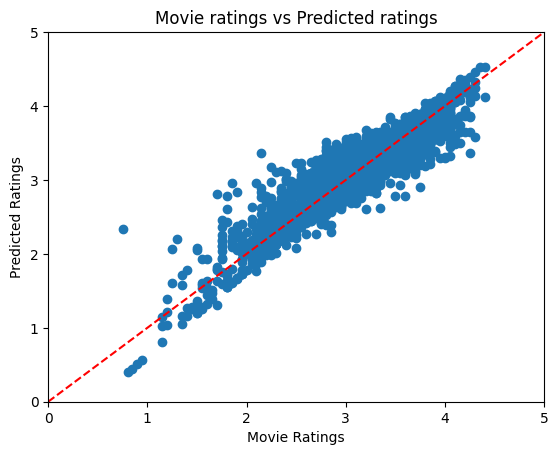

In [ ]:
import matplotlib.pyplot as plt

plt.axis([0,5,0,5])
plt.scatter(y_test, y_pred)

index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')
plt.xlabel("Movie Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Movie ratings vs Predicted ratings")



## User Modeling

In [30]:
import pandas as pd

ratings = pd.read_csv('./data/ml-20m/ratings.csv')
movie_df = pd.read_csv('./data/movie_df.csv')
user_features = pd.read_csv('./data/user_features.csv')

Echantillonage des users pour avoir un temps d'exécution raisonnable

In [31]:
N = 1000  

users_sample = ratings['userId'].sample(n=N, random_state=42)

ratings_sample = ratings[ratings['userId'].isin(users_sample)]

print(len(ratings_sample))

488323


In [32]:
ratings_movie = pd.merge(ratings_sample, movie_df, on='movieId', how='inner')
full_data = pd.merge(ratings_movie, user_features, on='userId', how='inner')
print(full_data['rating'].value_counts())

rating
4.0    96758
3.0    80468
3.5    65154
4.5    34019
5.0    32001
2.5    31113
2.0    30775
1.0    12801
1.5     9984
0.5     8377
Name: count, dtype: int64


### Exploration de solutions pour réequilibré la répartition des classes dans notre dataset de travail

Sur-échantillonnage des Classes Minoritaires

In [ ]:
from sklearn.utils import resample

# Séparer les classes
majority_class = ratings[ratings['rating'].between(3, 4)]
minority_classes = ratings[~ratings_sample['rating'].between(3, 4)]

# Sur-échantillonner les classes minoritaires
minority_classes_upsampled = resample(minority_classes,
                                       replace=True,  # Échantillonnage avec remplacement
                                       n_samples=len(majority_class),  # Équilibrer avec la classe majoritaire
                                       random_state=42)

# Combiner les classes
balanced_ratings = pd.concat([majority_class, minority_classes_upsampled])


Sous-échantillonnage des Classes Majoritaires

In [4]:
# Sous-échantillonner la classe majoritaire
majority_class_downsampled = resample(majority_class,
                                       replace=False,  # Échantillonnage sans remplacement
                                       n_samples=len(minority_classes),  # Équilibrer avec la classe minoritaire
                                       random_state=42)

# Combiner les classes
balanced_ratings = pd.concat([majority_class_downsampled, minority_classes])


Rééquilibrage manuel

In [34]:
import pandas as pd

# Supposons que 'ratings_sample' est votre DataFrame contenant les notes
# Compter le nombre d'échantillons par classe
class_counts = full_data['rating'].value_counts()
print(class_counts)
# Trouver le nombre minimum d'échantillons dans les classes minoritaires
min_count = class_counts.min()
# Créer une liste pour stocker les échantillons sous-échantillonnés
balanced_samples = []

# Sous-échantillonner chaque classe
for rating in class_counts.index:
    class_samples = full_data[full_data['rating'] == rating]
    if len(class_samples) > min_count:
        # Sous-échantillonner la classe majoritaire
        class_samples = class_samples.sample(n=min_count, random_state=42)
    balanced_samples.append(class_samples)

# Combiner les échantillons sous-échantillonnés
full_data_balanced_ratings = pd.concat(balanced_samples)

# Vérifier la distribution des classes
print(full_data_balanced_ratings['rating'].value_counts())
print(len(full_data_balanced_ratings))

rating
4.0    96758
3.0    80468
3.5    65154
4.5    34019
5.0    32001
2.5    31113
2.0    30775
1.0    12801
1.5     9984
0.5     8377
Name: count, dtype: int64
rating
4.0    8377
3.0    8377
3.5    8377
4.5    8377
5.0    8377
2.5    8377
2.0    8377
1.0    8377
1.5    8377
0.5    8377
Name: count, dtype: int64
83770


Reconstitution du dataset de travail

In [6]:

print(full_data_balanced_ratings["rating"].value_counts())

rating
4.0    8377
3.0    8377
3.5    8377
4.5    8377
5.0    8377
2.5    8377
2.0    8377
1.0    8377
1.5    8377
0.5    8377
Name: count, dtype: int64


Sélection de features "simples" pour une première modélisation

In [35]:
features = [
    'averageRating', 
    'mean_rating', 'rating_bias'
]


full_data_balanced_ratings.head()

userId  movieId  rating   timestamp     tconst  \
313674  110890      322     4.0   983196485  tt0114594   
287840  101127     4117     4.0  1034994976  tt0093209   
152319   58700    64957     4.0  1285286591  tt0421715   
176358   65401      123     4.0   974810704  tt0109424   
96356    40456      647     4.0   982966672  tt0115956   

                               primaryTitle  \
313674                 Swimming with Sharks   
287840                       Hope and Glory   
152319  The Curious Case of Benjamin Button   
176358                    Chungking Express   
96356                    Courage Under Fire   

                              originalTitle  startYear  runtimeMinutes  \
313674                 Swimming with Sharks       1994              93   
287840                       Hope and Glory       1987             113   
152319  The Curious Case of Benjamin Button       2008             166   
176358                   Chung Hing sam lam       1994             102   
96356                    Courage Under Fire       1996             116   

                       genres  ... writerAvgRating tag0AvgRating  \
313674           comedy,crime  ...        3.500000      3.416667   
287840   comedy,drama,romance  ...        3.262500      3.521111   
152319  drama,fantasy,romance  ...        3.242857           NaN   
176358     comedy,crime,drama  ...        3.683333      3.610606   
96356    action,drama,mystery  ...        3.412500      3.425000   

        tag1AvgRating  tag2AvgRating genresAvgRating mean_rating rating_bias  \
313674       3.392857       3.733333        3.159264        3.80        0.30   
287840       3.452778       3.614286        3.216009        3.84        0.33   
152319            NaN            NaN        3.198163        3.76        0.26   
176358       3.432143       3.534483        3.206854        3.34       -0.17   
96356        3.305556       3.475000        3.159297        3.75        0.24   

       genre_entropy  preferedRuntimeCat preferedVo  
313674          2.31               short         en  
287840          2.45                long         fr  
152319          2.45                long         en  
176358          2.45                long         fr  
96356           2.39             average         en  

[5 rows x 39 columns]

### Regression

In [36]:
from sklearn.model_selection import train_test_split

X = full_data_balanced_ratings[features]
y = full_data_balanced_ratings['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Linear

In [37]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred*2)/2 

for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.3f}")

print(min(y_pred_rounded), max(y_pred_rounded))

averageRating: 1.138
mean_rating: -0.271
rating_bias: 1.333
-2.0 5.5


##### Random forest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred)

##### Measure

In [38]:
y_test_scaled = y_test * 2
y_pred_scaled = y_pred_rounded * 2

In [39]:
from sklearn.metrics import root_mean_squared_error

print(f"RMSE: {root_mean_squared_error(y_test_scaled, y_pred_scaled):.3f}")

RMSE: 2.192


In [40]:
import numpy as np

def precision_classes_per_class(y_true, y_pred, tolerance=1):
    # Créer un dictionnaire pour stocker les précisions par classe
    precision_dict = {}
    
    # Obtenir les classes uniques
    unique_classes = sorted(set(y_true))
    print(unique_classes)
    for cls in unique_classes:
        # Filtrer les prédictions et les vraies valeurs pour la classe actuelle
        true_class = (y_true == cls)
        pred_class = (y_pred >= cls - tolerance) & (y_pred <= cls + tolerance)

        # Calculer le nombre de prédictions correctes et le total pour la classe
        correct_predictions = np.sum(true_class & pred_class)
        total_predictions = np.sum(true_class)

        # Éviter la division par zéro
        if total_predictions > 0:
            precision = correct_predictions / total_predictions
        else:
            precision = 0.0  # Pas de prédictions pour cette classe

        precision_dict[cls] = precision

    return precision_dict

# Calculer la précision des classes avec une tolérance de 0.5
precision_per_class = precision_classes_per_class(y_test_scaled, y_pred_scaled, 1)
for cls, precision in precision_per_class.items():
    print(f"Précision pour la classe {cls}: {precision:.3f}")




[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Précision pour la classe 1.0: 0.312
Précision pour la classe 2.0: 0.347
Précision pour la classe 3.0: 0.484
Précision pour la classe 4.0: 0.631
Précision pour la classe 5.0: 0.773
Précision pour la classe 6.0: 0.789
Précision pour la classe 7.0: 0.751
Précision pour la classe 8.0: 0.553
Précision pour la classe 9.0: 0.362
Précision pour la classe 10.0: 0.167


Text(0.5, 36.72222222222221, 'Predicted Label')

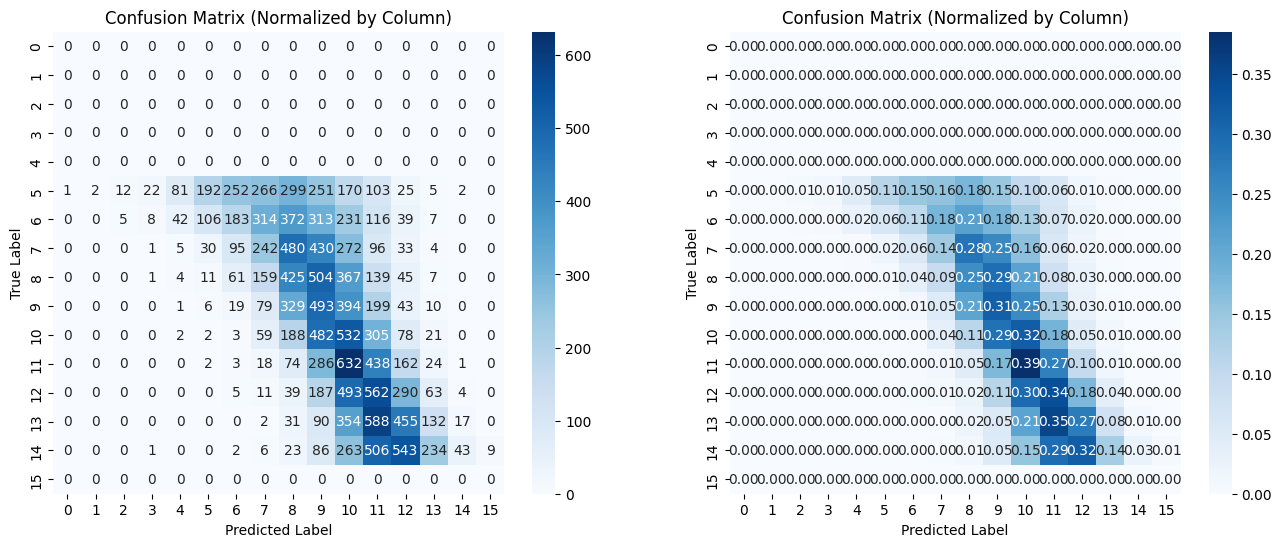

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

cm = confusion_matrix(y_test_scaled, y_pred_scaled)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix (Normalized by Column)')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')


cm_norm = confusion_matrix(y_test_scaled, y_pred_scaled, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix (Normalized by Column)')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

On voit qu'en utilisant les solutions de régressions les problèmes suivants sont clairement identifiables:
- inégalité de performance entre les classes
- prédiction en dehors d'interval cible

### Classification v1

In [10]:
len(full_data_balanced_ratings)

83770

In [ ]:

from sklearn.ensemble import RandomForestClassifier

X = full_data_balanced_ratings[features]
y = full_data_balanced_ratings['rating']
y_class = y * 2 
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y)

model_rfc = RandomForestClassifier(n_estimators=50)
model_rfc.fit(X_train, y_train)

[8377]


RandomForestClassifier(n_estimators=50)

In [12]:
import matplotlib.pyplot as plt

# Extraire l'importance des features
importances = model_rfc.feature_importances_

# Créer un DataFrame pour une meilleure visualisation
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Afficher les résultats
print(feature_importance_df)
    
y_pred = model_rfc.predict(X_test)


         Feature  Importance
0  averageRating    0.434887
1    mean_rating    0.291067
2    rating_bias    0.274046


 ###### Confusion matrix

Text(0.5, 36.72222222222221, 'Predicted Label')

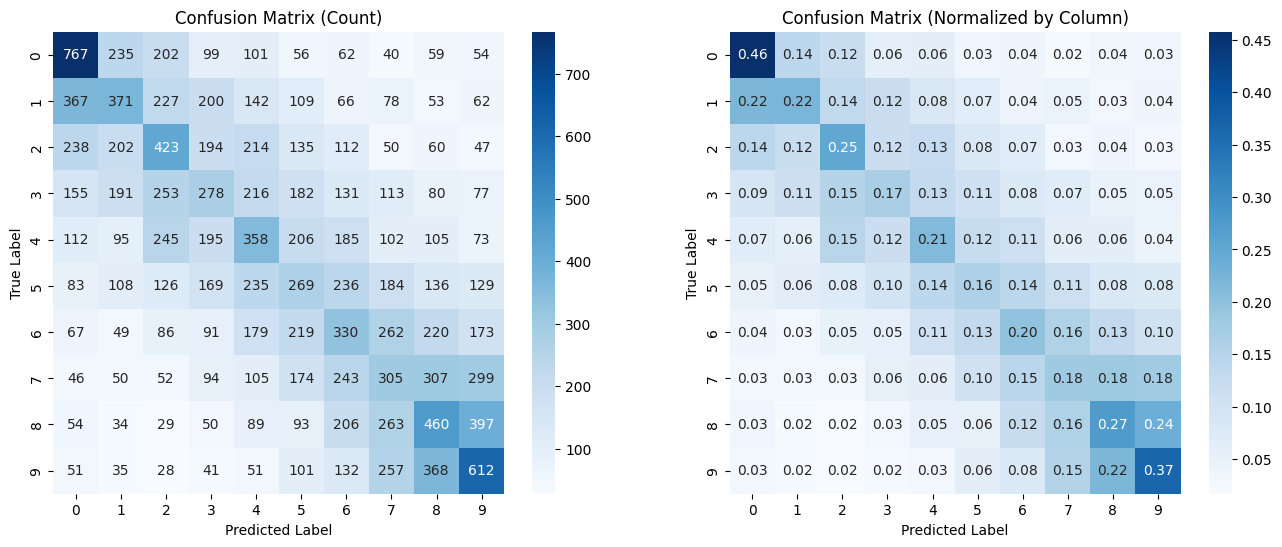

In [22]:

# 2. Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
# 1. Graphique à barres horizontal pour l'importance des features
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
# plt.title('Feature Importance')
# plt.xlabel('Importance Score')
# plt.tight_layout()

y_test_rescaled = y_test/2
y_pred_rescaled = y_pred/2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Matrice de confusion standard
cm = confusion_matrix(y_test_rescaled.astype(str), y_pred_rescaled.astype(str))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix (Count)')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Matrice de confusion normalisée
cm_norm = confusion_matrix(y_test_rescaled.astype(str), y_pred_rescaled.astype(str), normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix (Normalized by Column)')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')




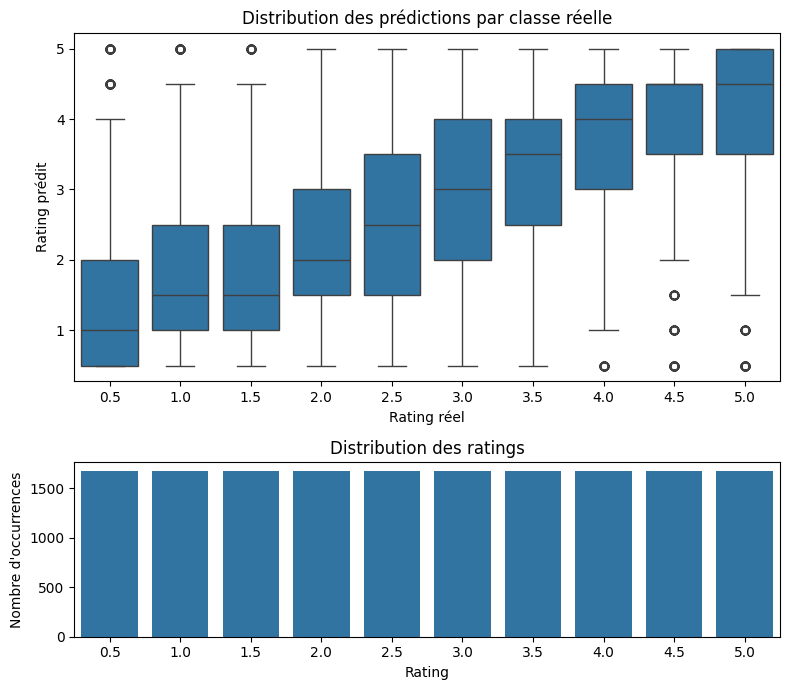

In [19]:
df_results = pd.DataFrame({'Réel': y_test_rescaled, 'Prédit': y_pred_rescaled})

# Créer une figure avec 2 subplots verticaux
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), height_ratios=[2, 1])

# Boxplot dans le premier subplot
sns.boxplot(x='Réel', y='Prédit', data=df_results, ax=ax1)
ax1.set_title('Distribution des prédictions par classe réelle')
ax1.set_xlabel('Rating réel')
ax1.set_ylabel('Rating prédit')

# Barplot de la distribution des ratings dans le second subplot
sns.countplot(x='Réel', data=df_results, ax=ax2)
ax2.set_title('Distribution des ratings')
ax2.set_xlabel('Rating')
ax2.set_ylabel('Nombre d\'occurrences')

plt.tight_layout()


##### Measure

In [23]:
from sklearn.metrics import root_mean_squared_error

print(f"RMSE: {root_mean_squared_error(y_test_rescaled, y_pred_rescaled):.3f}")

RMSE: 1.336


In [21]:
import numpy as np

def precision_classes_per_class(y_true, y_pred, tolerance=1):
    # Créer un dictionnaire pour stocker les précisions par classe
    precision_dict = {}
    
    # Obtenir les classes uniques
    unique_classes = sorted(set(y_true))
    print(unique_classes)
    for cls in unique_classes:
        # Filtrer les prédictions et les vraies valeurs pour la classe actuelle
        true_class = (y_true == cls)
        pred_class = (y_pred >= cls - tolerance) & (y_pred <= cls + tolerance)

        # Calculer le nombre de prédictions correctes et le total pour la classe
        correct_predictions = np.sum(true_class & pred_class)
        total_predictions = np.sum(true_class)

        # Éviter la division par zéro
        if total_predictions > 0:
            precision = correct_predictions / total_predictions
        else:
            precision = 0.0  # Pas de prédictions pour cette classe

        precision_dict[cls] = precision

    return precision_dict

# Calculer la précision des classes avec une tolérance de 0.5
precision_per_class = precision_classes_per_class(y_test_rescaled, y_pred_rescaled, 0.5)
for cls, precision in precision_per_class.items():
    print(f"Précision pour la classe {cls}: {precision:.3f}")

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Précision pour la classe 0.5: 0.598
Précision pour la classe 1.0: 0.576
Précision pour la classe 1.5: 0.489
Précision pour la classe 2.0: 0.446
Précision pour la classe 2.5: 0.453
Précision pour la classe 3.0: 0.442
Précision pour la classe 3.5: 0.484
Précision pour la classe 4.0: 0.510
Précision pour la classe 4.5: 0.669
Précision pour la classe 5.0: 0.585


### Classification v2

In [1]:
import pandas as pd

ratings = pd.read_csv('./data/ml-20m/ratings.csv')
movie_df = pd.read_csv('./data/movie_df.csv')
user_features = pd.read_csv('./data/user_features.csv')

Echantillonage des users

In [2]:
N = 1000  

users_sample = ratings['userId'].sample(n=N, random_state=42)

ratings_sample = ratings[ratings['userId'].isin(users_sample)]

print(len(ratings_sample))

488323


In [3]:
ratings_movie = pd.merge(ratings_sample, movie_df, on='movieId', how='inner')
full_data = pd.merge(ratings_movie, user_features, on='userId', how='inner')
print(full_data['rating'].value_counts())

rating
4.0    96758
3.0    80468
3.5    65154
4.5    34019
5.0    32001
2.5    31113
2.0    30775
1.0    12801
1.5     9984
0.5     8377
Name: count, dtype: int64


In [4]:
full_data.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'tconst', 'primaryTitle',
       'originalTitle', 'startYear', 'runtimeMinutes', 'genres', 'directors',
       'writers', 'averageRating', 'numVotes', 'actor1', 'actor2', 'tags_list',
       'runtimeCat', 'wRating', 'original_language', 'overview', 'director',
       'writer', 'tag0', 'tag1', 'tag2', 'directorAvgRating',
       'actor1AvgRating', 'actor2AvgRating', 'writerAvgRating',
       'tag0AvgRating', 'tag1AvgRating', 'tag2AvgRating', 'genresAvgRating',
       'mean_rating', 'rating_bias', 'genre_entropy', 'preferedRuntimeCat',
       'preferedVo'],
      dtype='object')

In [ ]:
features = [
    # Features du film
    'averageRating', 
    
    # Features de l'utilisateur
    'mean_rating', 'rating_bias'
]

full_data.head()

userId  movieId  rating   timestamp     tconst primaryTitle  \
0     218        6     4.0  1192429109  tt0113277         Heat   
1     218       16     4.5  1192428917  tt0112641       Casino   
2     218       32     4.0  1192429674  tt0114746   12 Monkeys   
3     218       39     3.5  1192585934  tt0112697     Clueless   
4     218       47     3.5  1192429236  tt0114369        Se7en   

    originalTitle  startYear  runtimeMinutes                   genres  ...  \
0            Heat       1995             170       action,crime,drama  ...   
1          Casino       1995             178              crime,drama  ...   
2  Twelve Monkeys       1995             129  mystery,sci-fi,thriller  ...   
3        Clueless       1995              97           comedy,romance  ...   
4           Se7en       1995             127      crime,drama,mystery  ...   

  writerAvgRating tag0AvgRating  tag1AvgRating  tag2AvgRating genresAvgRating  \
0        3.633333      3.462500       3.415385       3.362500        3.184678   
1        4.225000      3.835000       3.418182       3.407143        3.257137   
2        3.837500      3.500000       3.900000       3.292857        3.022486   
3        2.841667      3.007258       3.194737       3.096552        3.172996   
4        3.500000      3.304545       3.403571       3.350000        3.216791   

  mean_rating rating_bias genre_entropy  preferedRuntimeCat preferedVo  
0        3.86        0.36          2.24                long         en  
1        3.86        0.36          2.24                long         en  
2        3.86        0.36          2.24                long         en  
3        3.86        0.36          2.24                long         en  
4        3.86        0.36          2.24                long         en  

[5 rows x 39 columns]

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = full_data[features]
y = full_data["rating"]
y_class = y * 2 
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y)

model_rfc = RandomForestClassifier(
    n_estimators=50, class_weight="balanced" 
)
model_rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50)

In [8]:
import matplotlib.pyplot as plt

# Extraire l'importance des features
importances = model_rfc.feature_importances_

# Créer un DataFrame pour une meilleure visualisation
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Afficher les résultats
print(feature_importance_df)
    
y_pred = model_rfc.predict(X_test)


         Feature  Importance
0  averageRating    0.439041
1    mean_rating    0.295736
2    rating_bias    0.265223


Text(0.5, 36.72222222222221, 'Predicted Label')

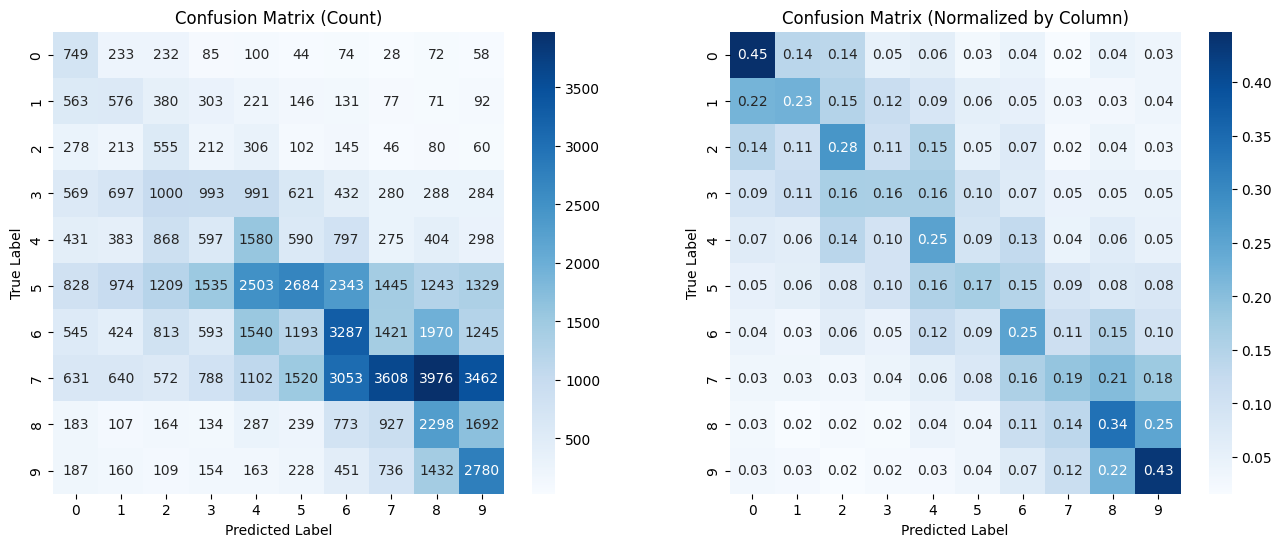

In [ ]:

# 2. Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test_rescaled = y_test/2
y_pred_rescaled = y_pred/2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Matrice de confusion standard
cm = confusion_matrix(y_test_rescaled.astype(str), y_pred_rescaled.astype(str))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix (Count)')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Matrice de confusion normalisée
cm_norm = confusion_matrix(y_test_rescaled.astype(str), y_pred_rescaled.astype(str), normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix (Normalized by Column)')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')




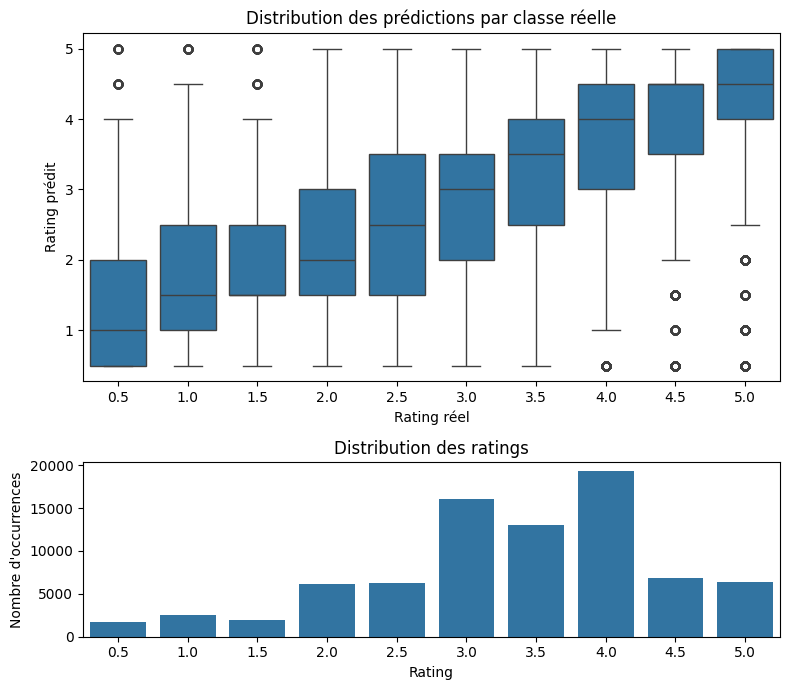

In [10]:
df_results = pd.DataFrame({'Réel': y_test_rescaled, 'Prédit': y_pred_rescaled})

# Créer une figure avec 2 subplots verticaux
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), height_ratios=[2, 1])

# Boxplot dans le premier subplot
sns.boxplot(x='Réel', y='Prédit', data=df_results, ax=ax1)
ax1.set_title('Distribution des prédictions par classe réelle')
ax1.set_xlabel('Rating réel')
ax1.set_ylabel('Rating prédit')

# Barplot de la distribution des ratings dans le second subplot
sns.countplot(x='Réel', data=df_results, ax=ax2)
ax2.set_title('Distribution des ratings')
ax2.set_xlabel('Rating')
ax2.set_ylabel('Nombre d\'occurrences')

plt.tight_layout()


##### Measure

In [11]:
from sklearn.metrics import root_mean_squared_error

print(f"RMSE: {root_mean_squared_error(y_test_rescaled, y_pred_rescaled):.3f}")

RMSE: 1.257


In [11]:
import numpy as np

def precision_classes_per_class(y_true, y_pred, tolerance=1):
    # Créer un dictionnaire pour stocker les précisions par classe
    precision_dict = {}
    
    # Obtenir les classes uniques
    unique_classes = sorted(set(y_true))
    print(unique_classes)
    for cls in unique_classes:
        # Filtrer les prédictions et les vraies valeurs pour la classe actuelle
        true_class = (y_true == cls)
        pred_class = (y_pred >= cls - tolerance) & (y_pred <= cls + tolerance)

        # Calculer le nombre de prédictions correctes et le total pour la classe
        correct_predictions = np.sum(true_class & pred_class)
        total_predictions = np.sum(true_class)

        # Éviter la division par zéro
        if total_predictions > 0:
            precision = correct_predictions / total_predictions
        else:
            precision = 0.0  # Pas de prédictions pour cette classe

        precision_dict[cls] = precision

    return precision_dict

# Calculer la précision des classes avec une tolérance de 0.5
precision_per_class = precision_classes_per_class(y_test_rescaled, y_pred_rescaled, 0.5)
for cls, precision in precision_per_class.items():
    print(f"Précision pour la classe {cls}: {precision:.3f}")

NameError: name 'y_test_rescaled' is not defined

#### xgBoost

Creation des features d'affinité

In [ ]:
def create_affinity_features_optimized(df):
    total_rows = len(df)

    print("1/4 Calcul des comptages...")
    director_count = df.groupby(["userId", "director"]).size()
    actor1_count = df.groupby(["userId", "actor1"]).size()
    actor2_count = df.groupby(["userId", "actor2"]).size()
    writer_count = df.groupby(["userId", "writer"]).size()

    print("2/4 Application des comptages...")
    df["director_count"] = df.apply(
        lambda x: director_count.get((x["userId"], x["director"]), 0), axis=1
    )
    df["actor1_count"] = df.apply(
        lambda x: actor1_count.get((x["userId"], x["actor1"]), 0), axis=1
    )
    df["actor2_count"] = df.apply(
        lambda x: actor2_count.get((x["userId"], x["actor2"]), 0), axis=1
    )
    df["writer_count"] = df.apply(
        lambda x: writer_count.get((x["userId"], x["writer"]), 0), axis=1
    )

    print("3/4 Calcul des affinités...")
    cols = {
        "director": "directorAvgRating",
        "actor1": "actor1AvgRating",
        "actor2": "actor2AvgRating",
        "writer": "writerAvgRating",
    }

    for person_type, avg_col in cols.items():
        print(f"Traitement de {person_type}...")
        df[f"{person_type}_affinity"] = 0

        for idx, row in df.iterrows():
            if idx % 1000 == 0:
                print(
                    f"Progression: {idx}/{total_rows} lignes ({(idx/total_rows)*100:.1f}%)"
                )

            if row[f"{person_type}_count"] > 1:
                other_movies = df[
                    (df["userId"] == row["userId"])
                    & (df[person_type] == row[person_type])
                    & (df.index != idx)
                ]

                if len(other_movies) > 0:
                    user_person_mean = other_movies["rating"].mean()
                    df.at[idx, f"{person_type}_affinity"] = (
                        user_person_mean - row[avg_col]
                    )

    print("Terminé!")
    return df

df_with_affinity = create_affinity_features_optimized(full_data)

In [ ]:
df_with_affinity.to_csv("./data/df_for_user_rating_with_affinity_v2.csv", index=False)

In [ ]:
import pandas as pd
df_with_affinity = pd.read_csv("./data/df_for_user_rating_with_affinity_v2.csv")

In [6]:
features = [
    "averageRating",
    "mean_rating",
    "rating_bias",
    "director_affinity",
    "actor1_affinity",
    "actor2_affinity",
    "writer_affinity",
]

In [29]:
display(df_with_affinity2[["rating"]+ features +["writer_count", "actor1_count", "actor2_count", "director_count"] ].head(20))

rating  mean_rating  rating_bias  director_affinity  actor1_affinity  \
0      4.0         3.86         0.36           0.513636         0.668391   
1      4.5         3.86         0.36           0.583333         0.814362   
2      4.0         3.86         0.36           0.495833        -0.004545   
3      3.5         3.86         0.36           0.000000         0.000000   
4      3.5         3.86         0.36           0.125000         0.000000   
5      4.5         3.86         0.36           0.027778         1.018750   
6      4.0         3.86         0.36           0.250000         0.000000   
7      4.0         3.86         0.36           0.750000         0.939362   
8      2.5         3.86         0.36          -0.626087         0.000000   
9      3.0         3.86         0.36           0.000000         0.000000   
10     4.5         3.86         0.36           0.681818         0.633333   
11     3.5         3.86         0.36           0.000000         0.000000   
12     4.5         3.86         0.36          -0.050000         0.000000   
13     4.5         3.86         0.36           0.000000         0.000000   
14     4.0         3.86         0.36           0.000000         0.626000   
15     4.0         3.86         0.36           0.000000         0.486765   
16     3.5         3.86         0.36           0.000000         0.000000   
17     4.0         3.86         0.36           0.000000         0.939362   
18     4.5         3.86         0.36           0.788889         0.585057   
19     4.0         3.86         0.36           0.100000         0.000000   

    actor2_affinity  writer_affinity  writer_count  actor1_count  \
0          0.661765         0.000000             1             7   
1          0.000000         0.275000             2             5   
2          0.000000         0.000000             1             3   
3          0.000000         0.000000             1             1   
4          0.518182         0.000000             1             1   
5          0.000000         0.000000             1             3   
6          0.000000         0.000000             1             1   
7          0.000000         0.000000             1             5   
8          0.000000         0.494444             2             1   
9          0.000000         0.000000             1             1   
10         0.250000         0.713636             4             2   
11         0.000000         0.750000             2             1   
12         0.000000         0.005000             6             1   
13         0.728571         0.000000             1             1   
14         0.000000         0.537500             2             2   
15         0.000000         0.000000             1             3   
16         0.850000         0.000000             1             1   
17         0.000000         0.000000             1             5   
18         0.000000         0.000000             1             7   
19        -0.262500         0.105000             6             1   

    actor2_count  director_count  
0              2               3  
1              1               4  
2              1               2  
3              1               1  
4              4               2  
5              1               2  
6              1               2  
7              1               4  
8              1               2  
9              1               1  
10             2               4  
11             1               1  
12             1               5  
13             2               1  
14             1               1  
15             1               1  
16             2               1  
17             1               1  
18             1               3  
19             2               2

In [34]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

X = df_with_affinity2[features]
y = df_with_affinity2["rating"]
y_class = ((y * 2) - 1).astype(int)  # Normaliser les classes entre -1 et 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y
)

class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_train), y=y_train
)
sample_weights = [class_weights[y] for y in y_train]

In [20]:
y_train

44633     5
169962    5
226426    3
296409    5
58233     3
         ..
160913    8
364315    7
62950     7
105147    6
225279    6
Name: rating, Length: 321160, dtype: int64

In [35]:
from xgboost import XGBClassifier

model_xg = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective="multi:softmax",
    num_class=10,
)

model_xg.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=10, ...)

In [36]:
import matplotlib.pyplot as plt

importances = model_xg.feature_importances_

feature_importance_df = pd.DataFrame(
    {"Feature": features, "Importance": importances}
).sort_values("Importance", ascending=False)

print(feature_importance_df)

y_pred = model_xg.predict(X_test)

             Feature  Importance
2        rating_bias    0.291460
0      averageRating    0.275959
1        mean_rating    0.185157
3  director_affinity    0.082963
4    actor1_affinity    0.073489
6    writer_affinity    0.053725
5    actor2_affinity    0.037248


###### Confusion matrix

Text(0.5, 36.72222222222221, 'Predicted Label')

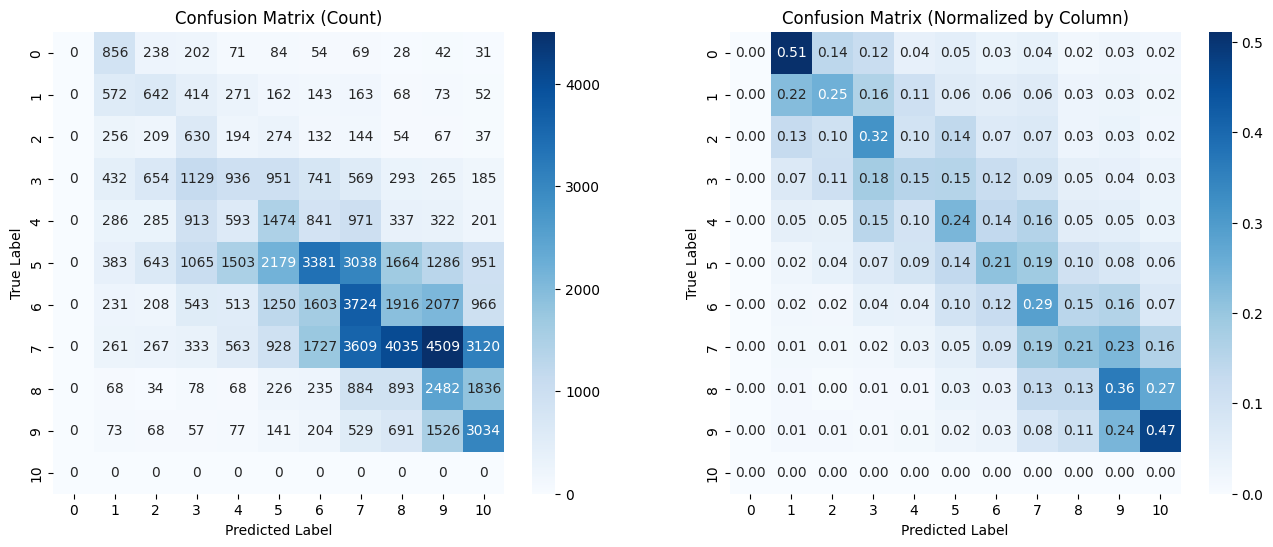

In [ ]:
# 2. Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test_rescaled = y_test / 2
y_pred_rescaled = (y_pred+1) / 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

cm = confusion_matrix(y_test_rescaled.astype(str), y_pred_rescaled.astype(str))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix (Count)")
ax1.set_ylabel("True Label")
ax1.set_xlabel("Predicted Label")

cm_norm = confusion_matrix(
    y_test_rescaled.astype(str), y_pred_rescaled.astype(str), normalize="true"
)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=ax2)
ax2.set_title("Confusion Matrix (Normalized by Column)")
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

In [38]:
def precision_classes_per_class(y_true, y_pred, tolerance=1):
    precision_dict = {}

    unique_classes = sorted(set(y_true))
    for cls in unique_classes:
        true_class = y_true == cls
        pred_class = (y_pred >= cls - tolerance) & (y_pred <= cls + tolerance)

        correct_predictions = np.sum(true_class & pred_class)
        total_predictions = np.sum(true_class)

        if total_predictions > 0:
            precision = correct_predictions / total_predictions
        else:
            precision = 0.0  # Pas de prédictions pour cette classe

        precision_dict[cls] = precision

    return precision_dict


In [41]:
precision_per_class = precision_classes_per_class(y_test, y_pred, 1)

cls_accuracy = []
for cls, precision in precision_per_class.items():
    cls_accuracy.append(precision)
    print(f"Précision pour la classe {cls}: {precision:.3f}")

print("dispersion", np.exp(-5 * np.std(cls_accuracy)))

Précision pour la classe 0: 0.653
Précision pour la classe 1: 0.636
Précision pour la classe 2: 0.517
Précision pour la classe 3: 0.490
Précision pour la classe 4: 0.467
Précision pour la classe 5: 0.534
Précision pour la classe 6: 0.556
Précision pour la classe 7: 0.628
Précision pour la classe 8: 0.766
Précision pour la classe 9: 0.713
dispersion 0.626048188759175


In [44]:
precision_per_class = precision_classes_per_class(y_test, y_pred, 2)
cls_accuracy = []

for cls, precision in precision_per_class.items():
    cls_accuracy.append(precision)
    print(f"Précision pour la classe {cls}: {precision:.3f}")


print("dispersion", np.exp(-5 * np.std(cls_accuracy)))

Précision pour la classe 0: 0.774
Précision pour la classe 1: 0.742
Précision pour la classe 2: 0.783
Précision pour la classe 3: 0.717
Précision pour la classe 4: 0.770
Précision pour la classe 5: 0.731
Précision pour la classe 6: 0.811
Précision pour la classe 7: 0.878
Précision pour la classe 8: 0.896
Précision pour la classe 9: 0.820
dispersion 0.7528425920636806


### Grid search

#### search script

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import top_k_accuracy_score, make_scorer, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm


def calculate_sample_weights(y_train):
    class_weights = compute_class_weight(
        "balanced", classes=np.unique(y_train), y=y_train
    )
    sample_weights = np.array([class_weights[y] for y in y_train])
    return sample_weights


def within_threshold_accuracy(y_true, y_pred, threshold=1):
    """
    Calcule le pourcentage de prédictions qui sont dans l'intervalle ±threshold de la valeur réelle.
    """
    return np.mean(np.abs(y_true - y_pred) <= threshold)


def class_dispersion_score_vectorized(y_true, y_pred, threshold=1):    
    """
    Calcule un score qui mesure l'homogénéité des prédictions entre les différentes classes.

    Le score est basé sur l'écart-type des précisions par classe, transformé avec une fonction 
    exponentielle négative pour obtenir une valeur entre 0 et 1. Plus les précisions sont 
    homogènes entre les classes, plus le score est proche de 1.

    Args:
        y_true (array-like): Labels réels
        y_pred (array-like): Prédictions du modèle 
        threshold (int, optional): Seuil de tolérance pour considérer une prédiction comme correcte. 
                                 Par défaut = 1.

    Returns:
        float: Score entre 0 et 1
            - Proche de 1 : précisions homogènes entre les classes
            - Proche de 0 : grandes disparités de précision entre les classes
    """
    classes = np.unique(y_true)
    accuracies = np.array(
        [
            np.mean(np.abs(y_true[y_true == cls] - y_pred[y_true == cls]) <= threshold)
            for cls in classes
        ]
    )
    return np.exp(-5 * np.std(accuracies))


def dispersion_scorer(threshold=1):
    def scorer(estimator, X, y):
        y_pred = estimator.predict(X)
        return class_dispersion_score_vectorized(y, y_pred, threshold)

    return scorer


def within_threshold_scorer(threshold=1):
    def scorer(estimator, X, y):
        y_pred = estimator.predict(X)
        return within_threshold_accuracy(y, y_pred, threshold)

    return scorer


def run_multi_metric_grid_search(models_params, X_train, y_train, X_test, y_test, target_metrics = "within_1"):
    sample_weights = calculate_sample_weights(y_train)
    all_results = {}
    all_models_results = (
        {}
    )  # Pour stocker tous les résultats de tous les modèles explorés

    for model_name, (model, params) in tqdm(models_params.items(), desc="Modèles"):
        print(f"\nRecherche pour {model_name}...")

        grid_search = GridSearchCV(
            model,
            params,
            scoring={
                "top_2": make_scorer(top_k_accuracy_score, k=2, needs_proba=True),
                "top_3": make_scorer(top_k_accuracy_score, k=3, needs_proba=True),
                "within_1": within_threshold_scorer(threshold=1),
                "dispersion": dispersion_scorer(threshold=1),
            },
            refit=target_metrics,  # Optimiser pour la métrique personnalisée
            cv=3,
            n_jobs=-1,
            verbose=1,
            return_train_score=True,  # Pour avoir les scores d'entraînement aussi
        )

        if model_name in ["XGBoost", "LightGBM", "RandomForest"]:
            grid_search.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            grid_search.fit(X_train, y_train)

        param_results = []
        for i in range(len(grid_search.cv_results_["params"])):
            param_set = grid_search.cv_results_["params"][i]
            param_name = (
                model_name
                + ": "
                + ", ".join([f"{k}={v}" for k, v in param_set.items()])
            )

            if model_name == "XGBoost":
                estimator = xgb.XGBClassifier(
                    objective="multi:softmax", num_class=10, **param_set
                )
            elif model_name == "LightGBM":
                estimator = lgb.LGBMClassifier(
                    objective="multiclass", num_class=10, **param_set
                )
            elif model_name == "RandomForest":
                estimator = RandomForestClassifier(**param_set)

            estimator.fit(X_train, y_train, sample_weight=sample_weights)

            y_pred_proba = estimator.predict_proba(X_test)
            y_pred = estimator.predict(X_test)

            test_scores = {
                "top_2": top_k_accuracy_score(y_test, y_pred_proba, k=2),
                "top_3": top_k_accuracy_score(y_test, y_pred_proba, k=3),
                "within_1": within_threshold_accuracy(y_test, y_pred, threshold=1),
                "dispersion": class_dispersion_score_vectorized(
                    y_test, y_pred, threshold=1
                ),
            }

            validation_scores = {
                "top_2": grid_search.cv_results_["mean_test_top_2"][i],
                "top_3": grid_search.cv_results_["mean_test_top_3"][i],
                "within_1": grid_search.cv_results_["mean_test_within_1"][i],
                "dispersion": grid_search.cv_results_["mean_test_dispersion"][i],
            }

            param_results.append(
                {
                    "params": param_set,
                    "param_name": param_name,
                    "validation_scores": validation_scores,
                    "test_scores": test_scores,
                }
            )

        all_models_results[model_name] = param_results

        best_model = grid_search.best_estimator_
        y_pred_proba = best_model.predict_proba(X_test)
        y_pred = best_model.predict(X_test)

        test_scores = {
            "top_2": top_k_accuracy_score(y_test, y_pred_proba, k=2),
            "top_3": top_k_accuracy_score(y_test, y_pred_proba, k=3),
            "within_1": within_threshold_accuracy(y_test, y_pred, threshold=1),
            "dispersion": class_dispersion_score_vectorized(
                y_test, y_pred, threshold=1
            ),
        }

        classes = np.unique(y_test)
        class_accuracies = {}
        for cls in classes:
            mask = y_test == cls
            if np.sum(mask) > 0:
                class_acc = np.mean(np.abs(y_test[mask] - y_pred[mask]) <= 1)
                class_accuracies[int(cls)] = class_acc

        all_results[model_name] = {
            "best_params": grid_search.best_params_,
            "validation_scores": {
                "top_2": grid_search.cv_results_["mean_test_top_2"][
                    grid_search.best_index_
                ],
                "top_3": grid_search.cv_results_["mean_test_top_3"][
                    grid_search.best_index_
                ],
                "within_1": grid_search.cv_results_["mean_test_within_1"][
                    grid_search.best_index_
                ],
                "dispersion": grid_search.cv_results_["mean_test_dispersion"][
                    grid_search.best_index_
                ],
            },
            "test_scores": test_scores,
            "class_accuracies": class_accuracies,
        }

        print(f"Meilleurs paramètres pour {model_name}: {grid_search.best_params_}")
        print("Scores de validation:")
        for metric, score in all_results[model_name]["validation_scores"].items():
            print(f"  {metric}: {score:.4f}")
        print("Scores de test:")
        for metric, score in test_scores.items():
            print(f"  {metric}: {score:.4f}")

        print("\nDistribution des poids des classes:")
        for cls in np.unique(y_train):
            weight = class_weights[cls]
            count = np.sum(y_train == cls)
            print(f"  Classe {cls}: poids = {weight:.4f}, count = {count}")

    return all_results, all_models_results

models_params = {
    "XGBoost": (
        xgb.XGBClassifier(objective="multi:softmax", num_class=10),
        {"n_estimators": [50, 100], "max_depth": [4, 6], "learning_rate": [0.05, 0.1]},
    ),
    "RandomForest": (
        RandomForestClassifier(),
        {
            "n_estimators": [50, 100],
            "max_depth": [6, 10, None],
            "min_samples_split": [2, 5],
        },
    ),
    "LightGBM": (
        lgb.LGBMClassifier(objective="multiclass", num_class=10),
        {"n_estimators": [50, 100], "max_depth": [4, 6], "learning_rate": [0.05, 0.1]},
    ),
}

#### Vizualisation

In [3]:
def plot_multi_metric_results(results, all_models_results):
    models = list(results.keys())
    metrics = ["top_2", "top_3", "within_1", "dispersion"]

    # 1. Visualisation des meilleurs modèles
    # Créer un DataFrame pour faciliter la visualisation
    data = []
    for model in models:
        for metric in metrics:
            val_score = results[model]["validation_scores"][metric]
            test_score = results[model]["test_scores"][metric]
            data.append(
                {
                    "Model": model,
                    "Metric": metric,
                    "Dataset": "Validation",
                    "Score": val_score,
                }
            )
            data.append(
                {
                    "Model": model,
                    "Metric": metric,
                    "Dataset": "Test",
                    "Score": test_score,
                }
            )

    df = pd.DataFrame(data)

    # Créer le graphique par métrique pour les meilleurs modèles
    plt.figure(figsize=(20, 15))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        sns.barplot(
            x="Model", y="Score", hue="Dataset", data=df[df["Metric"] == metric]
        )
        plt.title(f"Performance des meilleurs modèles: {metric}")
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.suptitle(
        "Comparaison des meilleurs modèles sur les quatre métriques", fontsize=16
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # 2. Visualisation de tous les modèles explorés
    # Créer un DataFrame pour tous les modèles explorés
    all_data = []
    for model_name, param_results in all_models_results.items():
        for result in param_results:
            param_name = result["param_name"]
            for metric in metrics:
                val_score = result["validation_scores"][metric]
                test_score = result["test_scores"][metric]
                all_data.append(
                    {
                        "Model": param_name,
                        "Base_Model": model_name,
                        "Metric": metric,
                        "Dataset": "Validation",
                        "Score": val_score,
                    }
                )
                all_data.append(
                    {
                        "Model": param_name,
                        "Base_Model": model_name,
                        "Metric": metric,
                        "Dataset": "Test",
                        "Score": test_score,
                    }
                )

    all_df = pd.DataFrame(all_data)

    # Créer un graphique pour chaque métrique montrant tous les modèles explorés
    for metric in metrics:
        plt.figure(figsize=(15, 10))

        # Filtrer les données pour cette métrique
        metric_df = all_df[all_df["Metric"] == metric]

        # Trier par score de test décroissant
        test_scores = metric_df[metric_df["Dataset"] == "Test"].sort_values(
            "Score", ascending=False
        )
        sorted_models = test_scores["Model"].unique()

        # Réorganiser le DataFrame pour l'affichage
        plot_df = metric_df.copy()
        plot_df["Model"] = pd.Categorical(
            plot_df["Model"], categories=sorted_models, ordered=True
        )
        plot_df = plot_df.sort_values("Model")

        # Créer le graphique
        ax = sns.barplot(x="Model", y="Score", hue="Dataset", data=plot_df)
        plt.title(f"Performance de tous les modèles explorés: {metric}")
        plt.ylim(0, 1)
        plt.xticks(rotation=90)

        # Ajouter des couleurs différentes par modèle de base
        for i, bar in enumerate(ax.patches):
            # Déterminer le modèle de base pour cette barre
            idx = i % len(sorted_models)
            model = sorted_models[idx]
            base_model = plot_df[plot_df["Model"] == model]["Base_Model"].iloc[0]

            # Ajuster légèrement la couleur en fonction du modèle de base
            if "XGBoost" in base_model:
                bar.set_alpha(0.7)
            elif "LightGBM" in base_model:
                bar.set_alpha(0.8)
            elif "RandomForest" in base_model:
                bar.set_alpha(0.9)

        plt.tight_layout()
        plt.show()

    # 3. Graphique d'évolution des métriques par modèle (meilleurs modèles)
    plt.figure(figsize=(15, 10))

    for dataset in ["Test", "Validation"]:
        plt.subplot(1, 2, 1 if dataset == "Validation" else 2)

        # Réorganiser les données pour le graphique d'évolution
        plot_data = df[df["Dataset"] == dataset].pivot(
            index="Model", columns="Metric", values="Score"
        )

        # Tracer les lignes
        for metric in metrics:
            plt.plot(plot_data.index, plot_data[metric], marker="o", label=metric)

        plt.title(f"Évolution des métriques par modèle ({dataset})")
        plt.ylabel("Score")
        plt.ylim(0, 1)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.legend()
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 4. Visualiser la précision par classe pour chaque meilleur modèle
    plt.figure(figsize=(15, 5 * len(models)))

    for i, model in enumerate(models):
        plt.subplot(len(models), 1, i + 1)

        class_acc = results[model]["class_accuracies"]
        classes = sorted(class_acc.keys())
        accuracies = [class_acc[cls] for cls in classes]

        bars = plt.bar(classes, accuracies)

        # Ajouter les valeurs sur les barres
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.01,
                f"{height:.2f}",
                ha="center",
                va="bottom",
            )

        plt.title(f"Précision within±1 par classe pour {model}")
        plt.xlabel("Classe")
        plt.ylabel("Précision")
        plt.ylim(0, 1.1)
        plt.xticks(classes)
        plt.grid(True, linestyle="--", alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

    # 5. Visualiser la distribution des poids des classes
    plt.figure(figsize=(10, 6))

    classes = np.unique(y_train)
    weights = [class_weights[cls] for cls in classes]
    counts = [np.sum(y_train == cls) for cls in classes]

    ax1 = plt.subplot(111)
    bars = ax1.bar(classes, weights, alpha=0.7, label="Poids")
    ax1.set_ylabel("Poids de classe")
    ax1.set_xlabel("Classe")
    ax1.set_title("Distribution des poids et fréquences des classes")

    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.05,
            f"{height:.2f}",
            ha="center",
            va="bottom",
        )

    # Ajouter un deuxième axe y pour les fréquences
    ax2 = ax1.twinx()
    ax2.plot(classes, counts, "ro-", label="Fréquence")
    ax2.set_ylabel("Nombre d'échantillons")

    # Ajouter les valeurs sur la ligne
    for i, count in enumerate(counts):
        ax2.text(classes[i], count + max(counts) * 0.02, str(count), ha="center")

    # Ajouter une légende combinée
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper right")

    plt.tight_layout()
    plt.show()

    # 6. Tableau comparatif de tous les modèles explorés
    # Créer un DataFrame pour comparer tous les modèles
    comparison_data = []
    for model_name, param_results in all_models_results.items():
        for result in param_results:
            row = {"Model": result["param_name"], "Base_Model": model_name}

            # Ajouter les paramètres
            for param, value in result["params"].items():
                row[f"param_{param}"] = value

            # Ajouter les scores de validation
            for metric, score in result["validation_scores"].items():
                row[f"val_{metric}"] = score

            # Ajouter les scores de test
            for metric, score in result["test_scores"].items():
                row[f"test_{metric}"] = score

            comparison_data.append(row)

    comparison_df = pd.DataFrame(comparison_data)

    # Trier par score de test within_1 décroissant
    comparison_df = comparison_df.sort_values("test_within_1", ascending=False)

    # Afficher le tableau des 10 meilleurs modèles
    print("\nTop 10 des modèles par score within_1 sur l'ensemble de test:")
    display_cols = (
        ["Model", "Base_Model"]
        + [col for col in comparison_df.columns if col.startswith("test_")]
        + [col for col in comparison_df.columns if col.startswith("val_")]
    )
    print(comparison_df[display_cols].head(10).to_string())

    # 7. Heatmap des corrélations entre les métriques
    plt.figure(figsize=(12, 10))

    # Sélectionner uniquement les colonnes de métriques
    metric_cols = [
        col
        for col in comparison_df.columns
        if col.startswith("test_") or col.startswith("val_")
    ]
    corr_matrix = comparison_df[metric_cols].corr()

    # Créer la heatmap
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Corrélations entre les différentes métriques")
    plt.tight_layout()
    plt.show()

    # 8. Graphique radar pour comparer les meilleurs modèles de chaque type
    # Sélectionner le meilleur modèle de chaque type
    best_models = {}
    for model_name in set(comparison_df["Base_Model"]):
        best_idx = comparison_df[comparison_df["Base_Model"] == model_name][
            "test_within_1"
        ].idxmax()
        best_models[model_name] = comparison_df.loc[best_idx]

    # Créer le graphique radar
    metrics_for_radar = ["test_top_2", "test_top_3", "test_within_1", "test_dispersion"]

    # Nombre de variables
    N = len(metrics_for_radar)

    # Angle de chaque axe
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Fermer le polygone

    # Initialiser la figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Pour chaque modèle
    for model_name, model_data in best_models.items():
        values = [model_data[metric] for metric in metrics_for_radar]
        values += values[:1]  # Fermer le polygone

        # Tracer le polygone
        ax.plot(angles, values, linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.1)

    # Ajouter les labels
    plt.xticks(
        angles[:-1], [metric.replace("test_", "") for metric in metrics_for_radar]
    )

    # Ajouter une légende
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))

    plt.title("Comparaison des meilleurs modèles de chaque type")
    plt.show()

    # 9. Boxplot des performances par type de modèle
    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)

        # Créer un boxplot pour chaque type de modèle
        sns.boxplot(x="Base_Model", y=f"test_{metric}", data=comparison_df)

        plt.title(f"Distribution des performances: {metric}")
        plt.ylim(0, 1)
        plt.grid(True, linestyle="--", alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

    return comparison_df

#### test

In [8]:
results, all_models_results = run_multi_metric_grid_search(
    models_params,
    X_train,
    y_train,
    X_test,
    y_test,
    target_metrics="within_1",
)

Modèles:   0%|          | 0/3 [00:00<?, ?it/s]


Recherche pour XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
Modèles:  33%|███▎      | 1/3 [09:24<18:48, 564.31s/it]

Meilleurs paramètres pour XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Scores de validation:
  top_2: nan
  top_3: nan
  within_1: 0.5929
  dispersion: 0.6322
Scores de test:
  top_2: 0.4754
  top_3: 0.6627
  within_1: 0.5909
  dispersion: 0.6260

Distribution des poids des classes:
  Classe 0: poids = 4.7920, count = 6702
  Classe 1: poids = 3.1360, count = 10241
  Classe 2: poids = 4.0210, count = 7987
  Classe 3: poids = 1.3045, count = 24620
  Classe 4: poids = 1.2903, count = 24890
  Classe 5: poids = 0.4989, count = 64375
  Classe 6: poids = 0.6162, count = 52123
  Classe 7: poids = 0.4149, count = 77406
  Classe 8: poids = 1.1801, count = 27215
  Classe 9: poids = 1.2545, count = 25601

Recherche pour RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
Modèles:  67%|██████▋   | 2/3 [43:42<24:02, 1442.84s/it]

Meilleurs paramètres pour RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Scores de validation:
  top_2: nan
  top_3: nan
  within_1: 0.6095
  dispersion: 0.4546
Scores de test:
  top_2: 0.5276
  top_3: 0.6877
  within_1: 0.6126
  dispersion: 0.4765

Distribution des poids des classes:
  Classe 0: poids = 4.7920, count = 6702
  Classe 1: poids = 3.1360, count = 10241
  Classe 2: poids = 4.0210, count = 7987
  Classe 3: poids = 1.3045, count = 24620
  Classe 4: poids = 1.2903, count = 24890
  Classe 5: poids = 0.4989, count = 64375
  Classe 6: poids = 0.6162, count = 52123
  Classe 7: poids = 0.4149, count = 77406
  Classe 8: poids = 1.1801, count = 27215
  Classe 9: poids = 1.2545, count = 25601

Recherche pour LightGBM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1481
[LightGBM] [Info] Number of data points in the train set: 321160, number of used features: 7
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Modèles: 100%|██████████| 3/3 [57:40<00:00, 1153.64s/it]

Meilleurs paramètres pour LightGBM: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Scores de validation:
  top_2: nan
  top_3: nan
  within_1: 0.5921
  dispersion: 0.6391
Scores de test:
  top_2: 0.4874
  top_3: 0.6683
  within_1: 0.5914
  dispersion: 0.6337

Distribution des poids des classes:
  Classe 0: poids = 4.7920, count = 6702
  Classe 1: poids = 3.1360, count = 10241
  Classe 2: poids = 4.0210, count = 7987
  Classe 3: poids = 1.3045, count = 24620
  Classe 4: poids = 1.2903, count = 24890
  Classe 5: poids = 0.4989, count = 64375
  Classe 6: poids = 0.6162, count = 52123
  Classe 7: poids = 0.4149, count = 77406
  Classe 8: poids = 1.1801, count = 27215
  Classe 9: poids = 1.2545, count = 25601


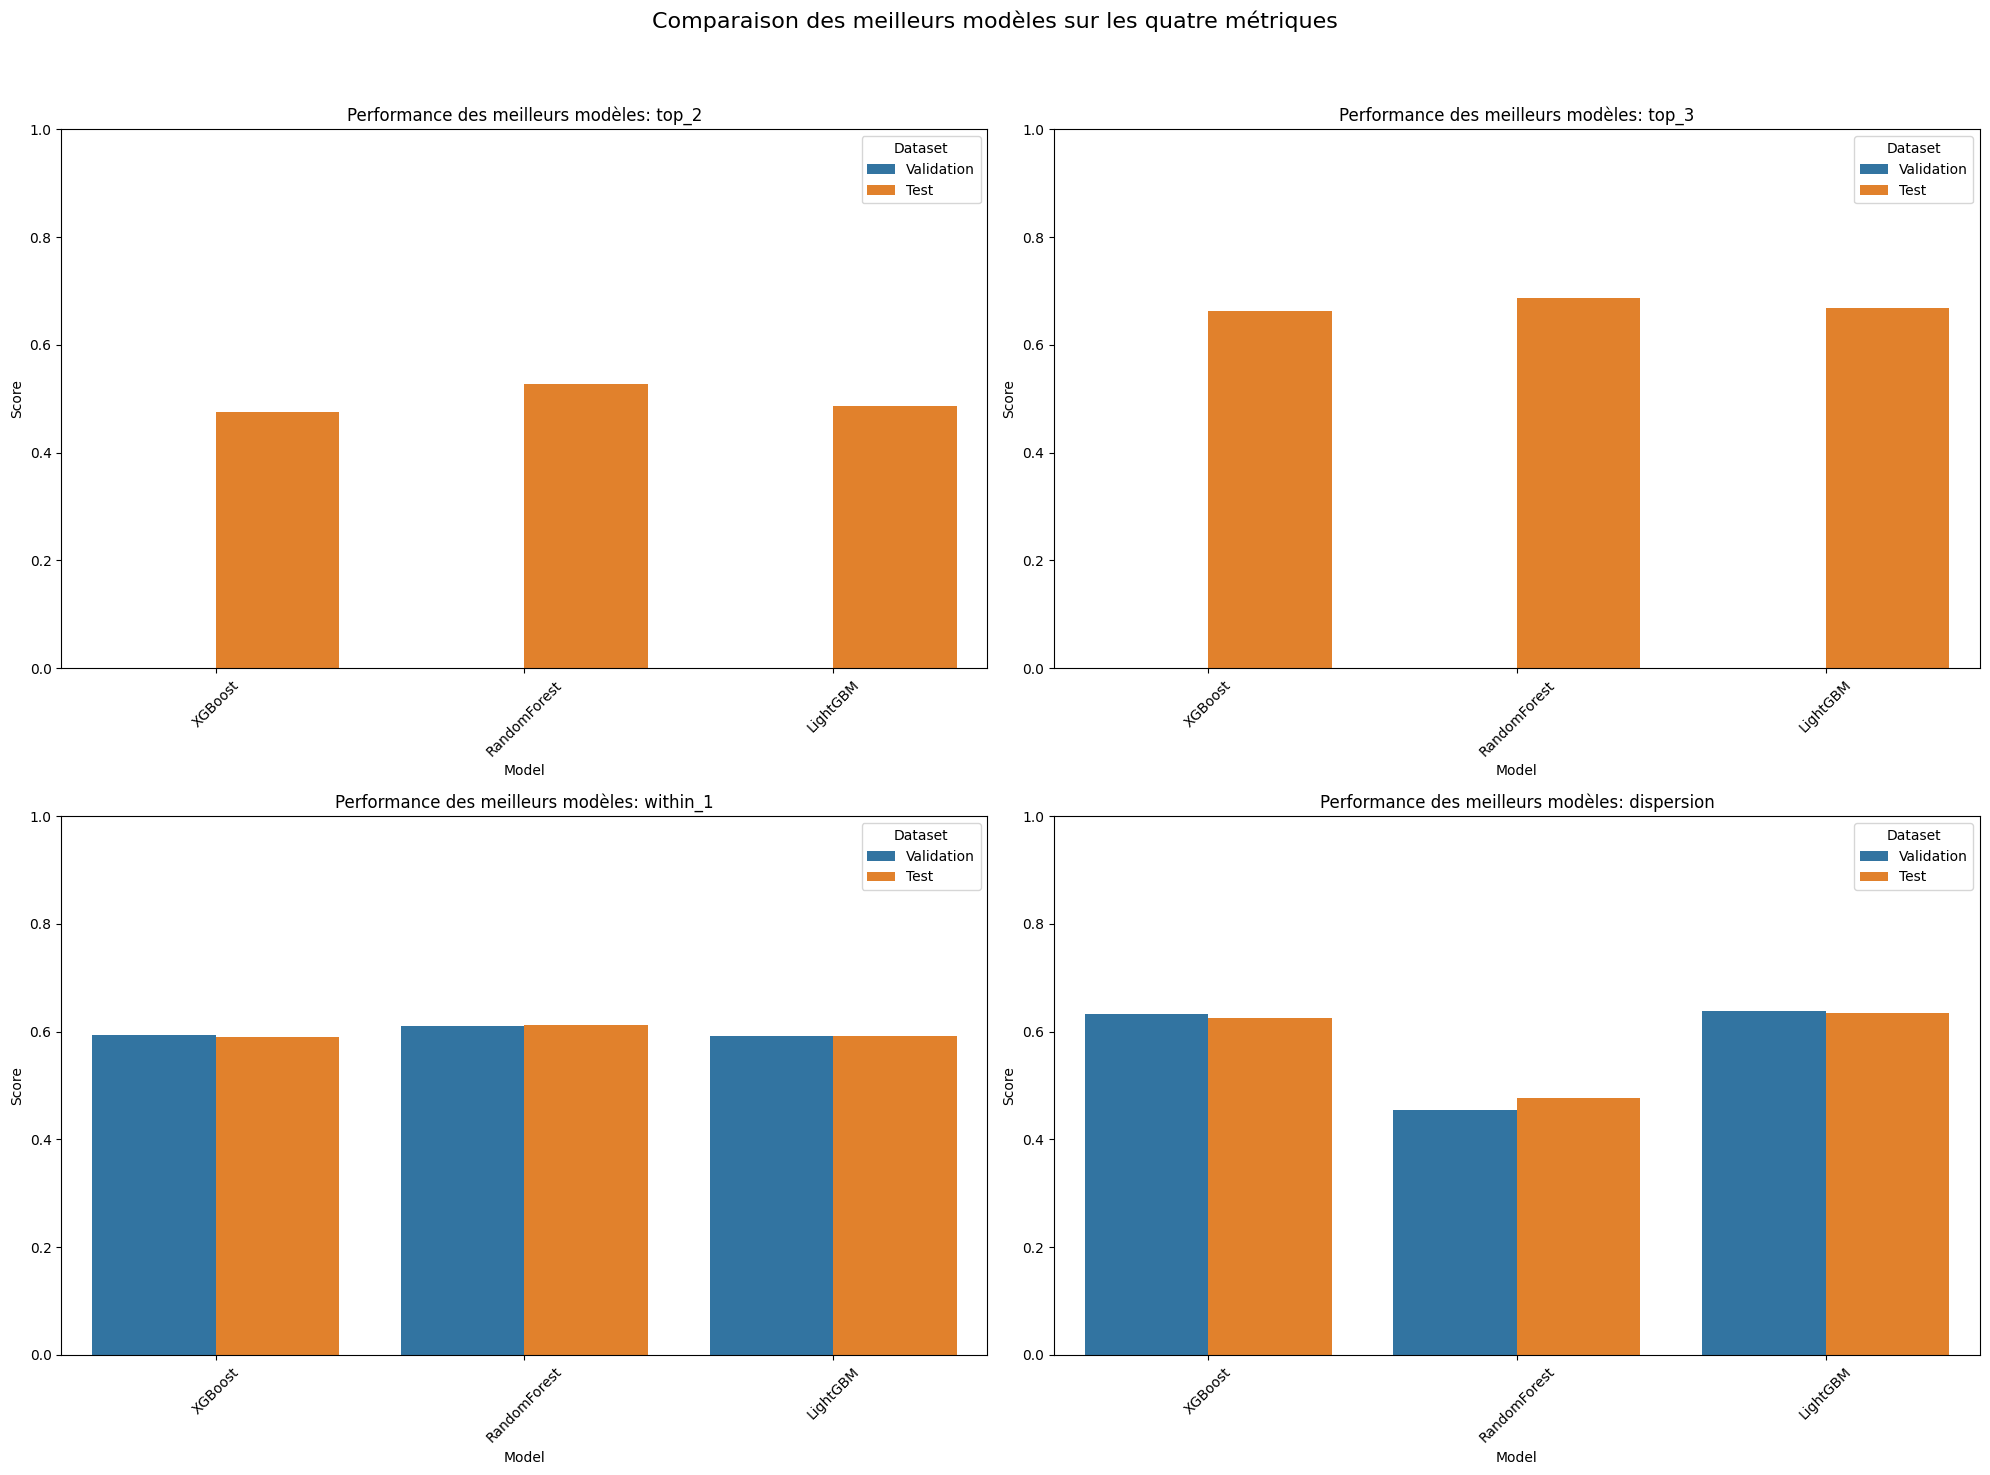

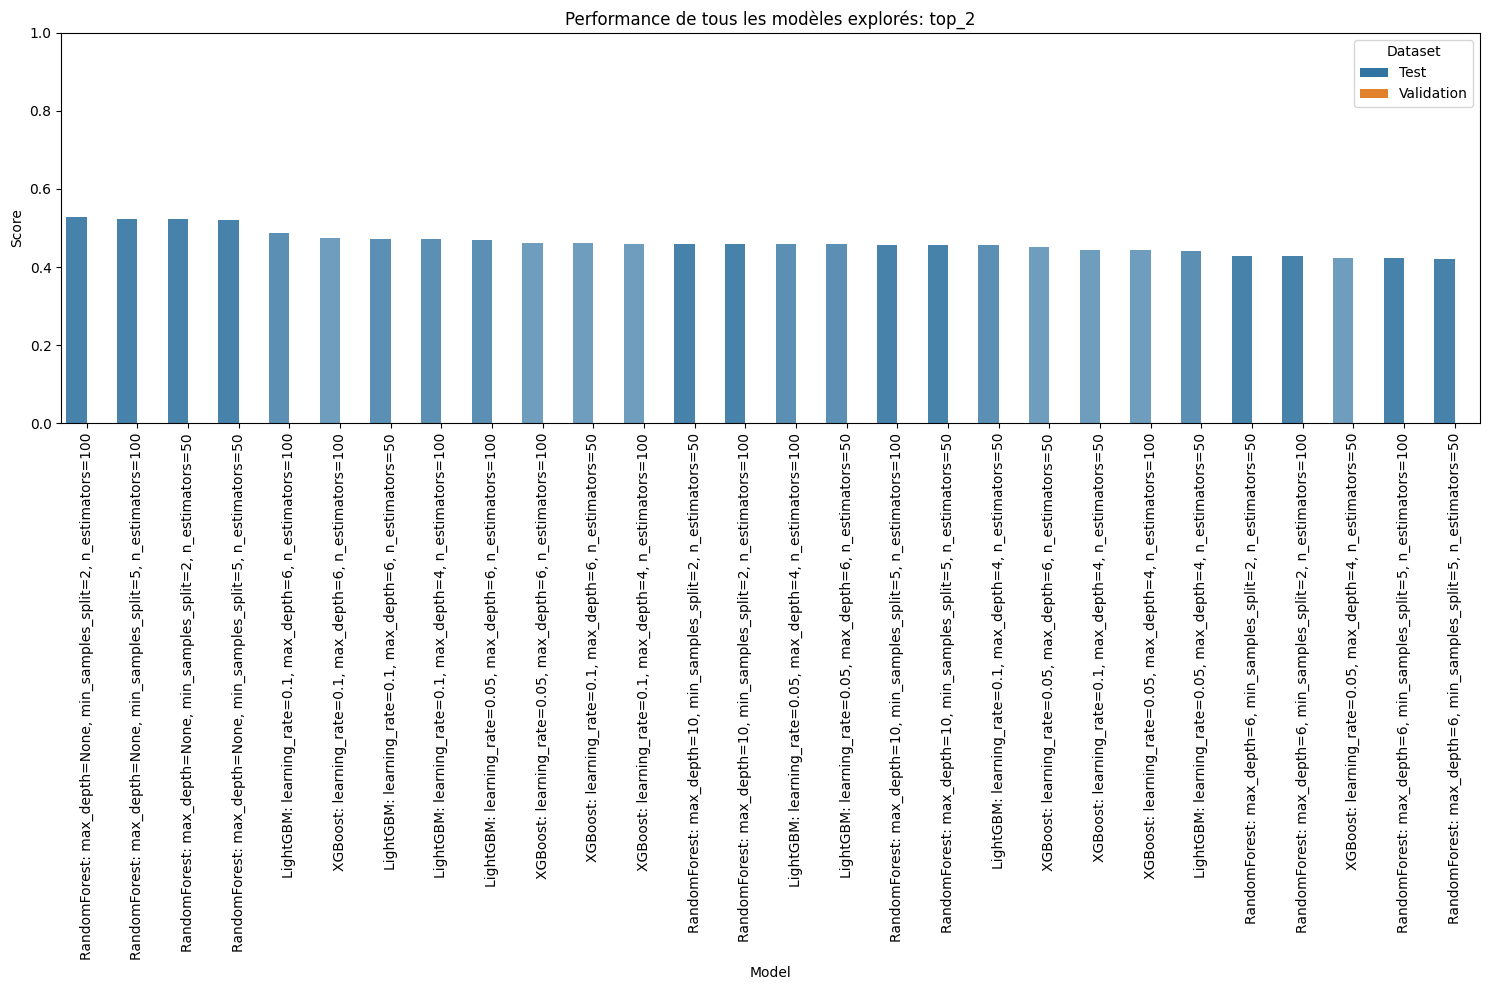

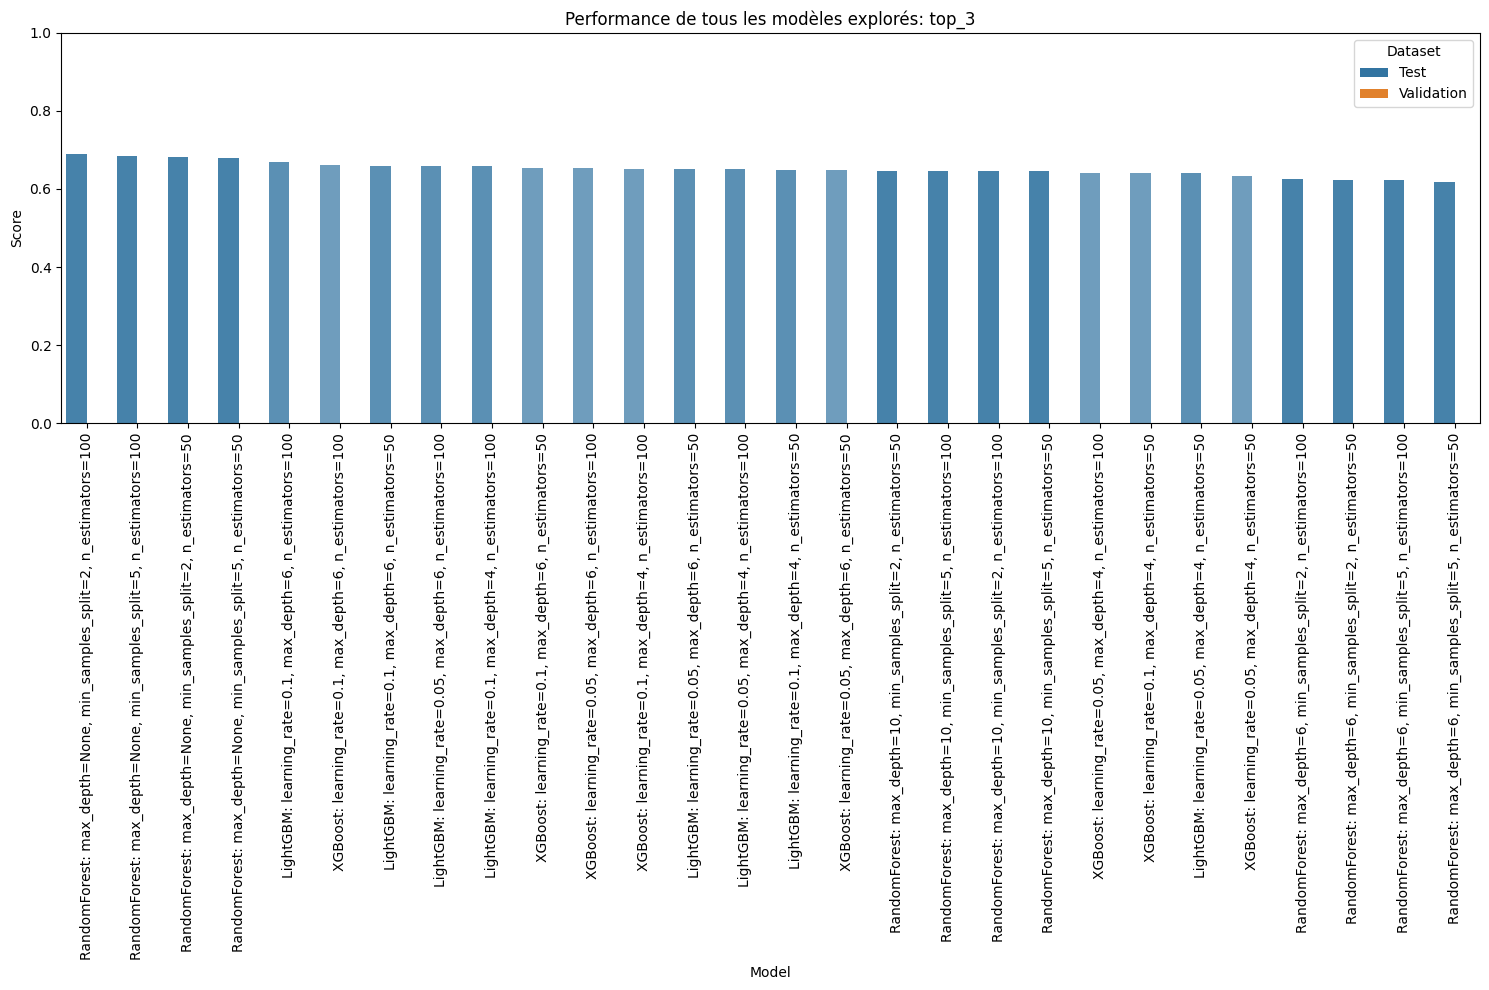

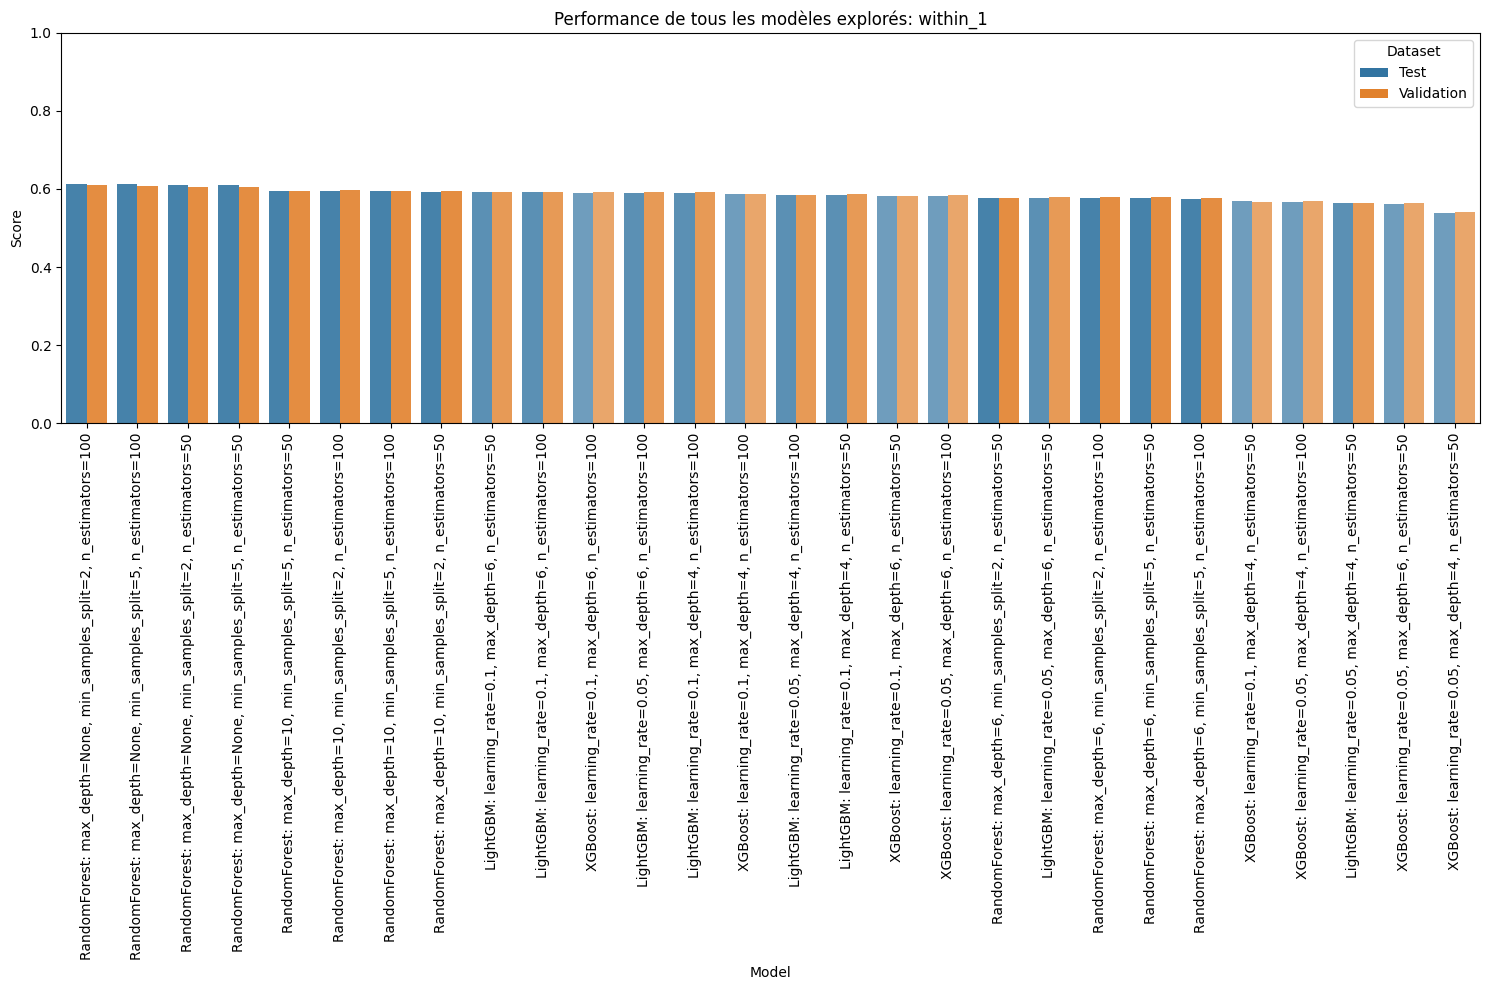

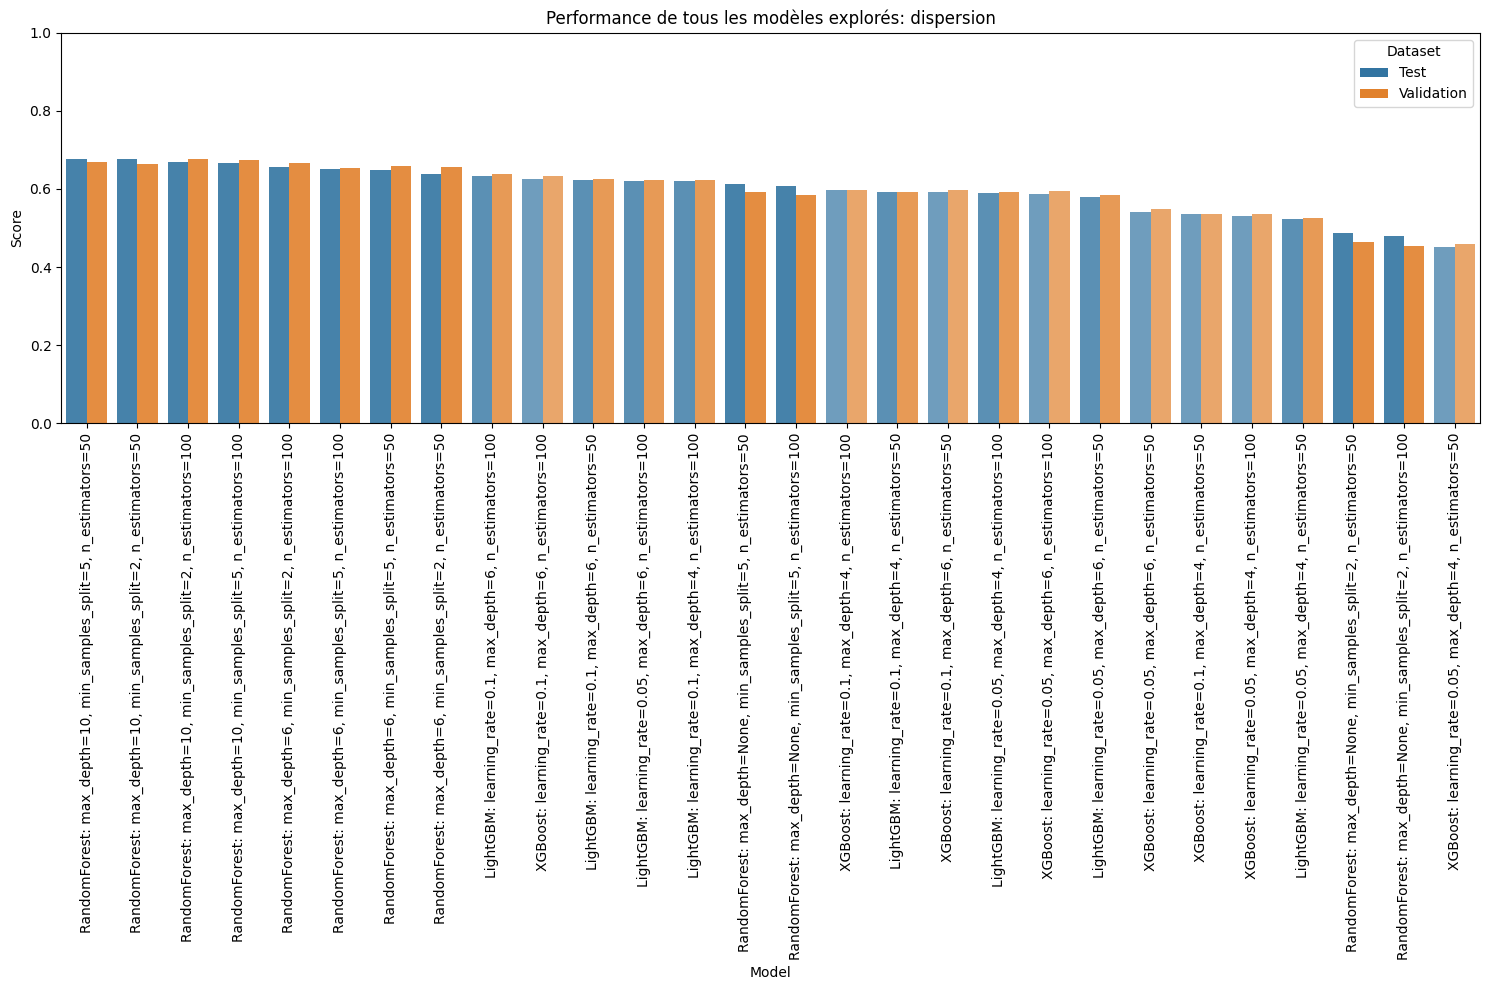

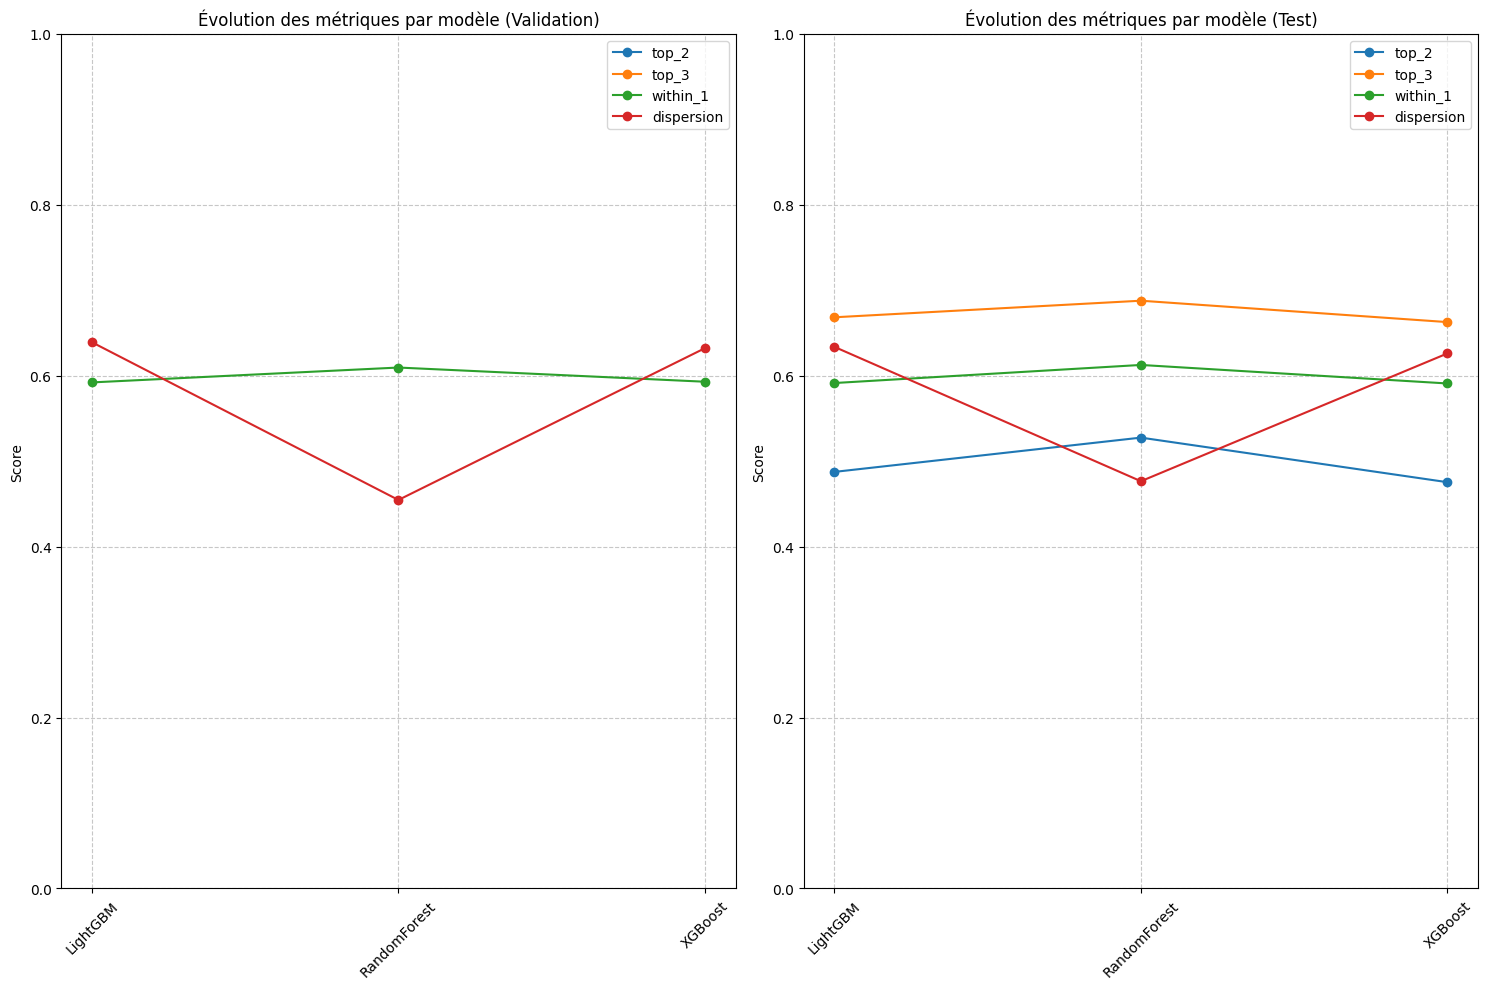

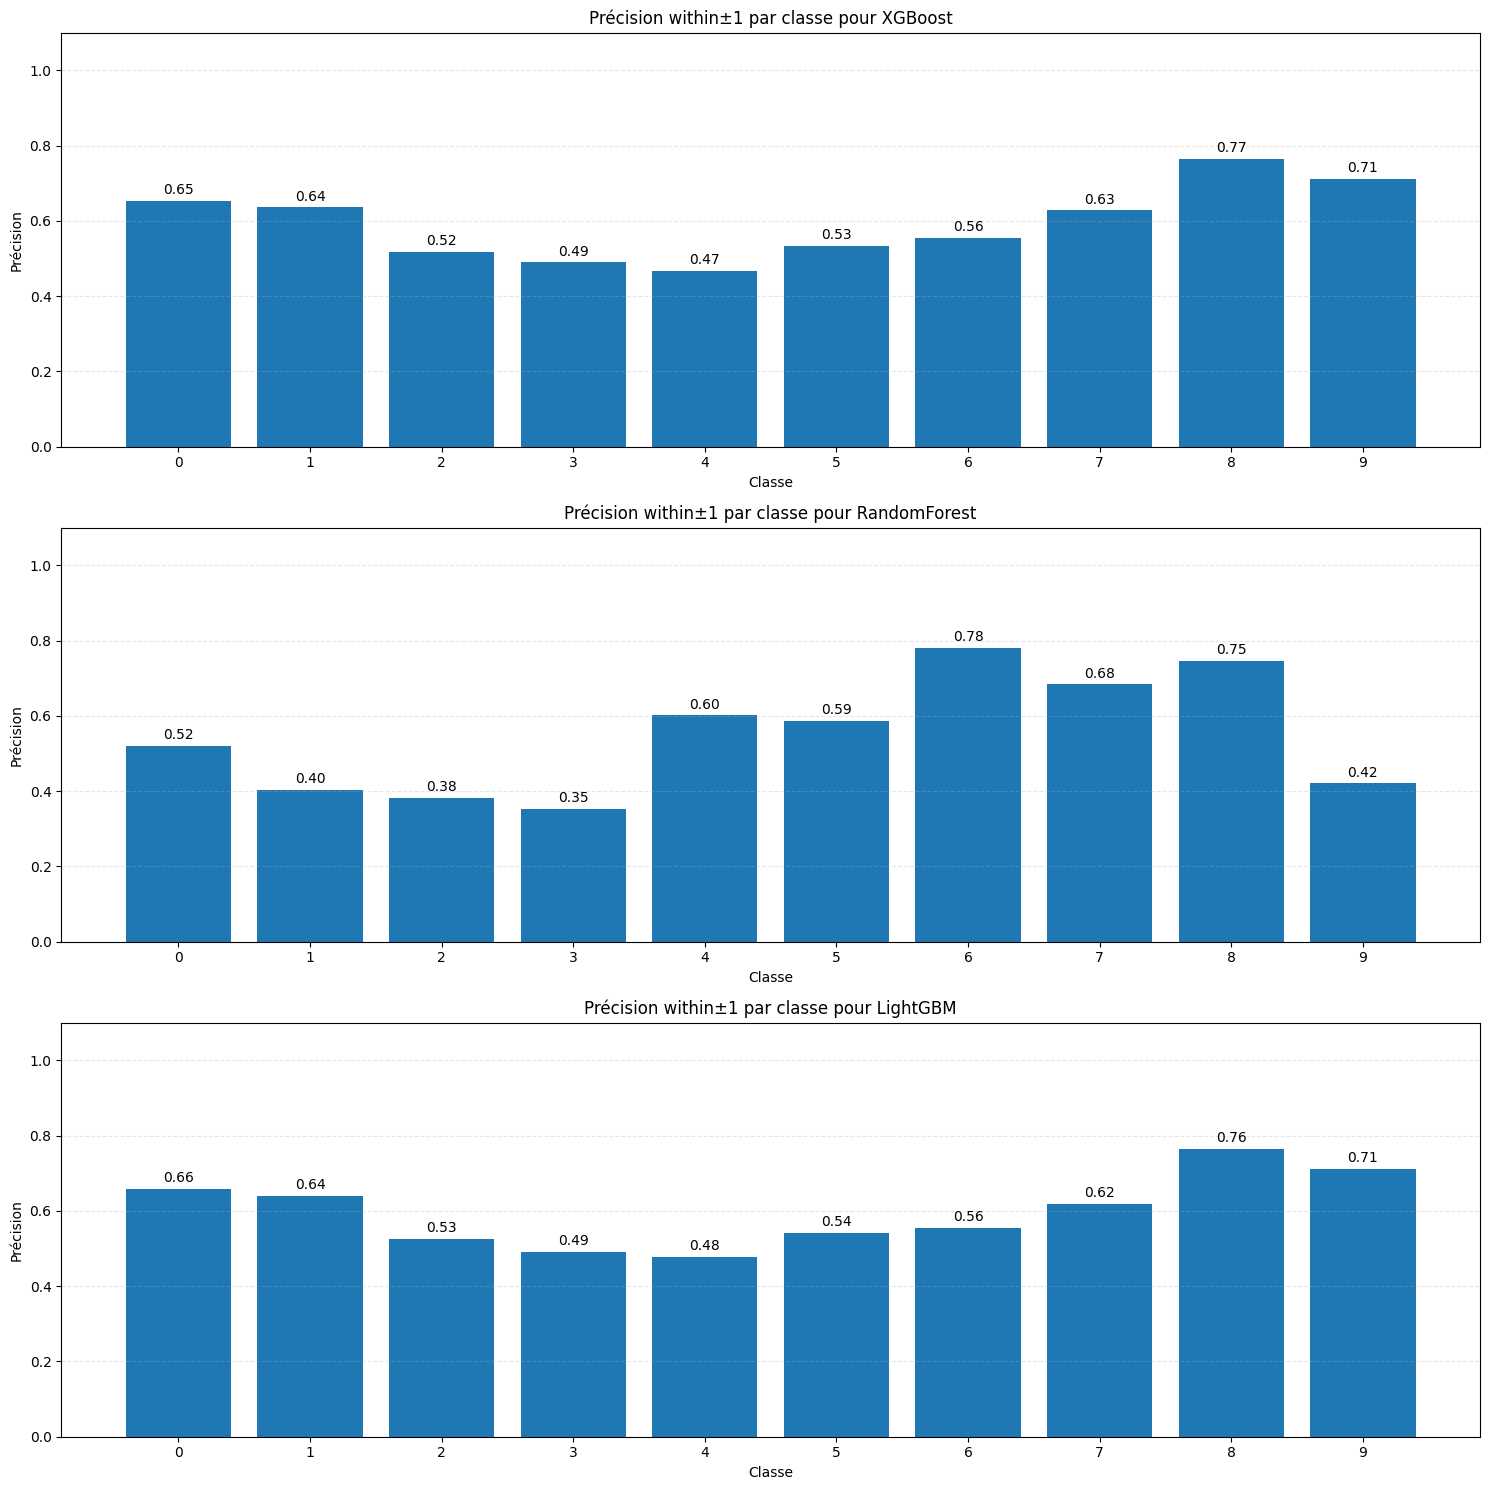

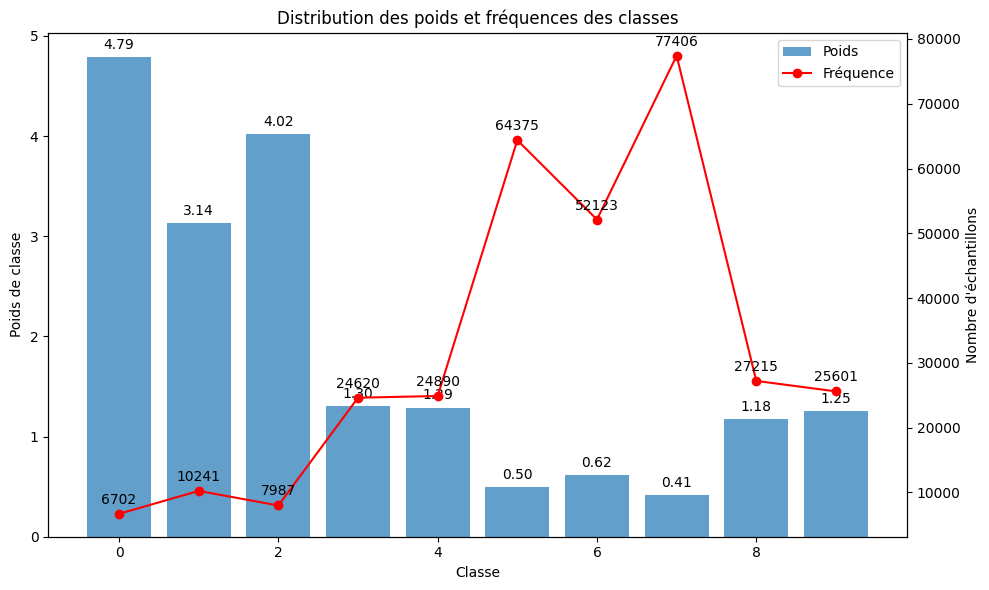


Top 10 des modèles par score within_1 sur l'ensemble de test:
                                                                  Model    Base_Model  test_top_2  test_top_3  test_within_1  test_dispersion  val_top_2  val_top_3  val_within_1  val_dispersion
17  RandomForest: max_depth=None, min_samples_split=2, n_estimators=100  RandomForest    0.528746    0.689314       0.613165         0.479806        NaN        NaN      0.609544        0.454611
19  RandomForest: max_depth=None, min_samples_split=5, n_estimators=100  RandomForest    0.524113    0.684307       0.611695         0.606811        NaN        NaN      0.608466        0.583664
16   RandomForest: max_depth=None, min_samples_split=2, n_estimators=50  RandomForest    0.523440    0.682351       0.610549         0.487176        NaN        NaN      0.605029        0.464918
18   RandomForest: max_depth=None, min_samples_split=5, n_estimators=50  RandomForest    0.519691    0.680047       0.610263         0.612796        NaN        N

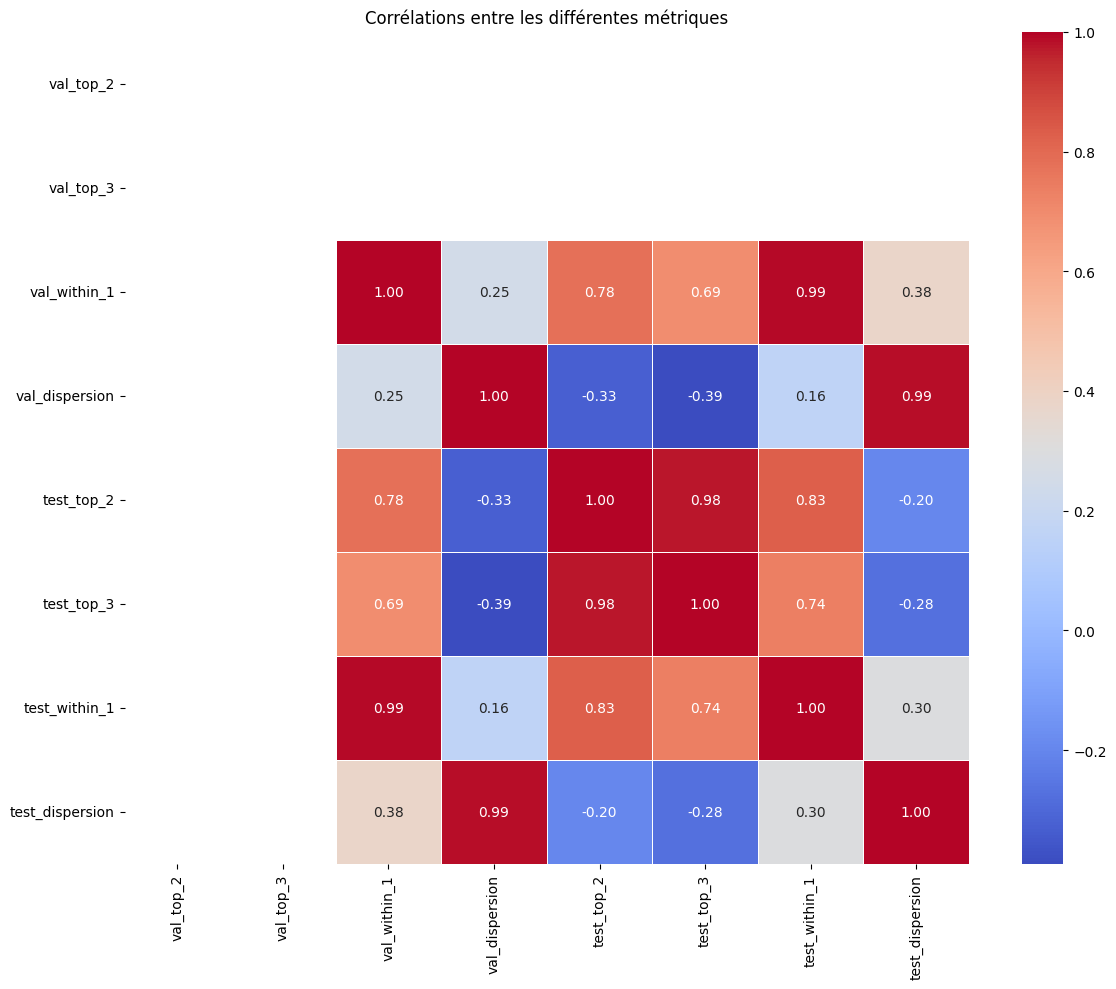

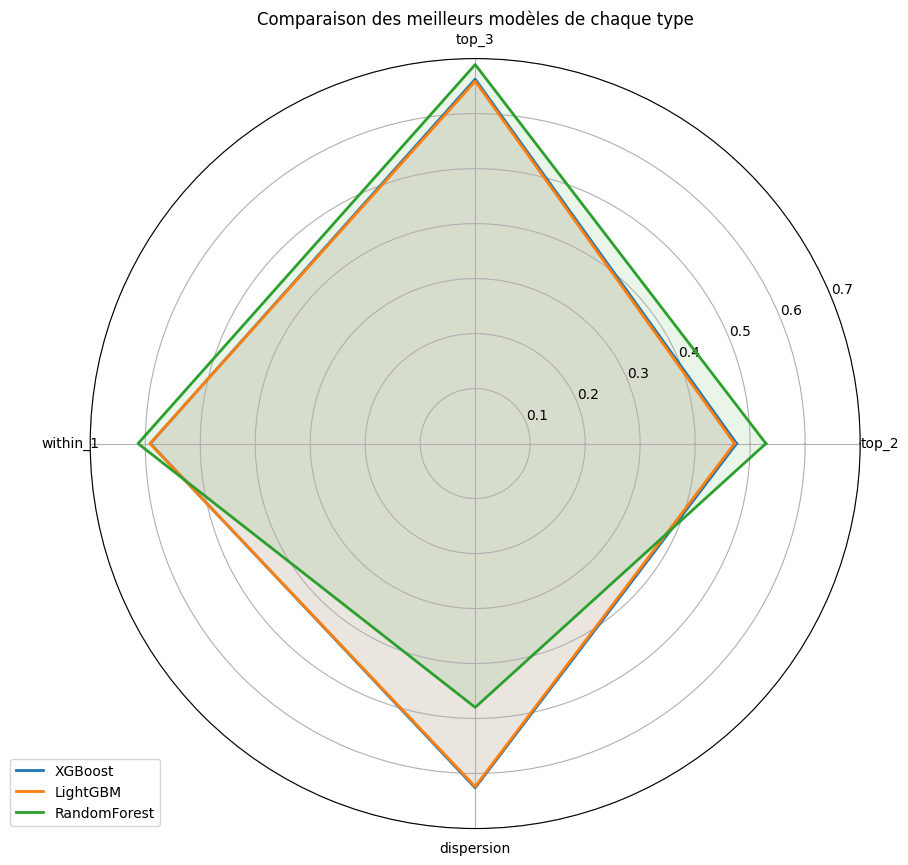

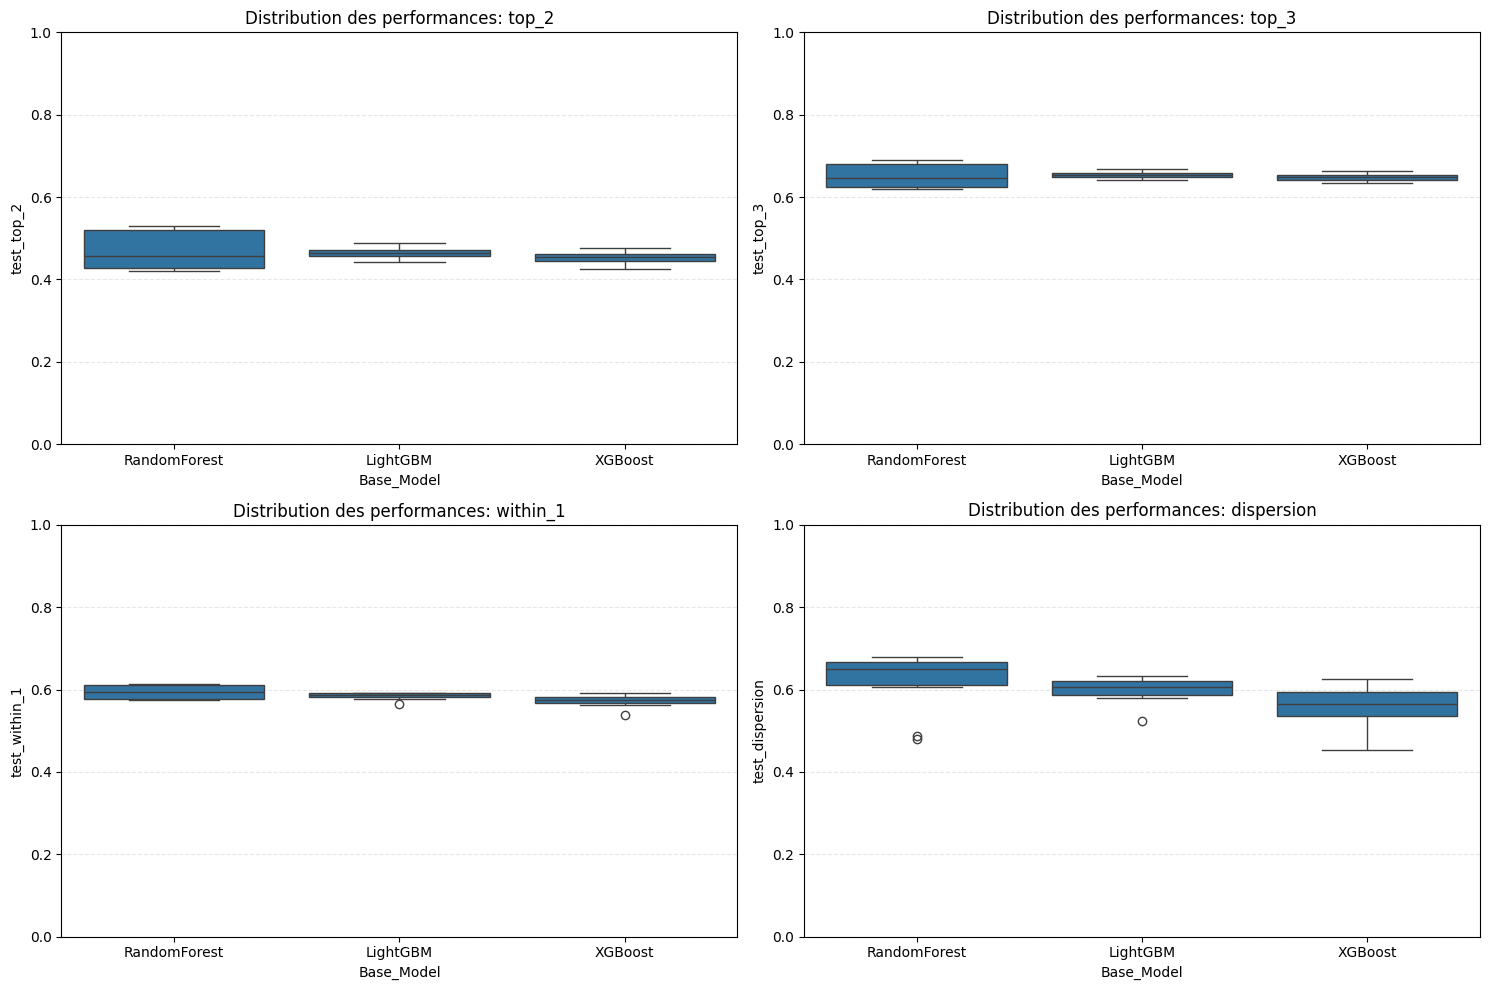


Meilleurs paramètres par modèle:

XGBoost:
  learning_rate: 0.1
  max_depth: 6
  n_estimators: 100

RandomForest:
  max_depth: None
  min_samples_split: 2
  n_estimators: 100

LightGBM:
  learning_rate: 0.1
  max_depth: 6
  n_estimators: 100


In [9]:
# Afficher les résultats
comparison_df = plot_multi_metric_results(results, all_models_results)

# Tableau récapitulatif des meilleurs paramètres
print("\nMeilleurs paramètres par modèle:")
for model, result in results.items():
    print(f"\n{model}:")
    for param, value in result["best_params"].items():
        print(f"  {param}: {value}")

In [10]:
results_dispersion, all_models_results_dispersion = run_multi_metric_grid_search(
    models_params,
    X_train,
    y_train,
    X_test,
    y_test,
    target_metrics="dispersion",
)

Modèles:   0%|          | 0/3 [00:00<?, ?it/s]


Recherche pour XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
Modèles:  33%|███▎      | 1/3 [06:43<13:27, 403.74s/it]

Meilleurs paramètres pour XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Scores de validation:
  top_2: nan
  top_3: nan
  within_1: 0.5929
  dispersion: 0.6322
Scores de test:
  top_2: 0.4754
  top_3: 0.6627
  within_1: 0.5909
  dispersion: 0.6260

Distribution des poids des classes:
  Classe 0: poids = 4.7920, count = 6702
  Classe 1: poids = 3.1360, count = 10241
  Classe 2: poids = 4.0210, count = 7987
  Classe 3: poids = 1.3045, count = 24620
  Classe 4: poids = 1.2903, count = 24890
  Classe 5: poids = 0.4989, count = 64375
  Classe 6: poids = 0.6162, count = 52123
  Classe 7: poids = 0.4149, count = 77406
  Classe 8: poids = 1.1801, count = 27215
  Classe 9: poids = 1.2545, count = 25601

Recherche pour RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
Modèles:  67%|██████▋   | 2/3 [30:37<16:49, 1009.85s/it]

Meilleurs paramètres pour RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Scores de validation:
  top_2: nan
  top_3: nan
  within_1: 0.5954
  dispersion: 0.6743
Scores de test:
  top_2: 0.4561
  top_3: 0.6447
  within_1: 0.5963
  dispersion: 0.6654

Distribution des poids des classes:
  Classe 0: poids = 4.7920, count = 6702
  Classe 1: poids = 3.1360, count = 10241
  Classe 2: poids = 4.0210, count = 7987
  Classe 3: poids = 1.3045, count = 24620
  Classe 4: poids = 1.2903, count = 24890
  Classe 5: poids = 0.4989, count = 64375
  Classe 6: poids = 0.6162, count = 52123
  Classe 7: poids = 0.4149, count = 77406
  Classe 8: poids = 1.1801, count = 27215
  Classe 9: poids = 1.2545, count = 25601

Recherche pour LightGBM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\wwps1172\Fichiers en local\Documents_NonSynchronisables\Documents\Projets\reskilling AI\film-recommandation\venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1481
[LightGBM] [Info] Number of data points in the train set: 321160, number of used features: 7
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

Modèles: 100%|██████████| 3/3 [43:24<00:00, 868.12s/it] 

Meilleurs paramètres pour LightGBM: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Scores de validation:
  top_2: nan
  top_3: nan
  within_1: 0.5921
  dispersion: 0.6391
Scores de test:
  top_2: 0.4874
  top_3: 0.6683
  within_1: 0.5914
  dispersion: 0.6337

Distribution des poids des classes:
  Classe 0: poids = 4.7920, count = 6702
  Classe 1: poids = 3.1360, count = 10241
  Classe 2: poids = 4.0210, count = 7987
  Classe 3: poids = 1.3045, count = 24620
  Classe 4: poids = 1.2903, count = 24890
  Classe 5: poids = 0.4989, count = 64375
  Classe 6: poids = 0.6162, count = 52123
  Classe 7: poids = 0.4149, count = 77406
  Classe 8: poids = 1.1801, count = 27215
  Classe 9: poids = 1.2545, count = 25601


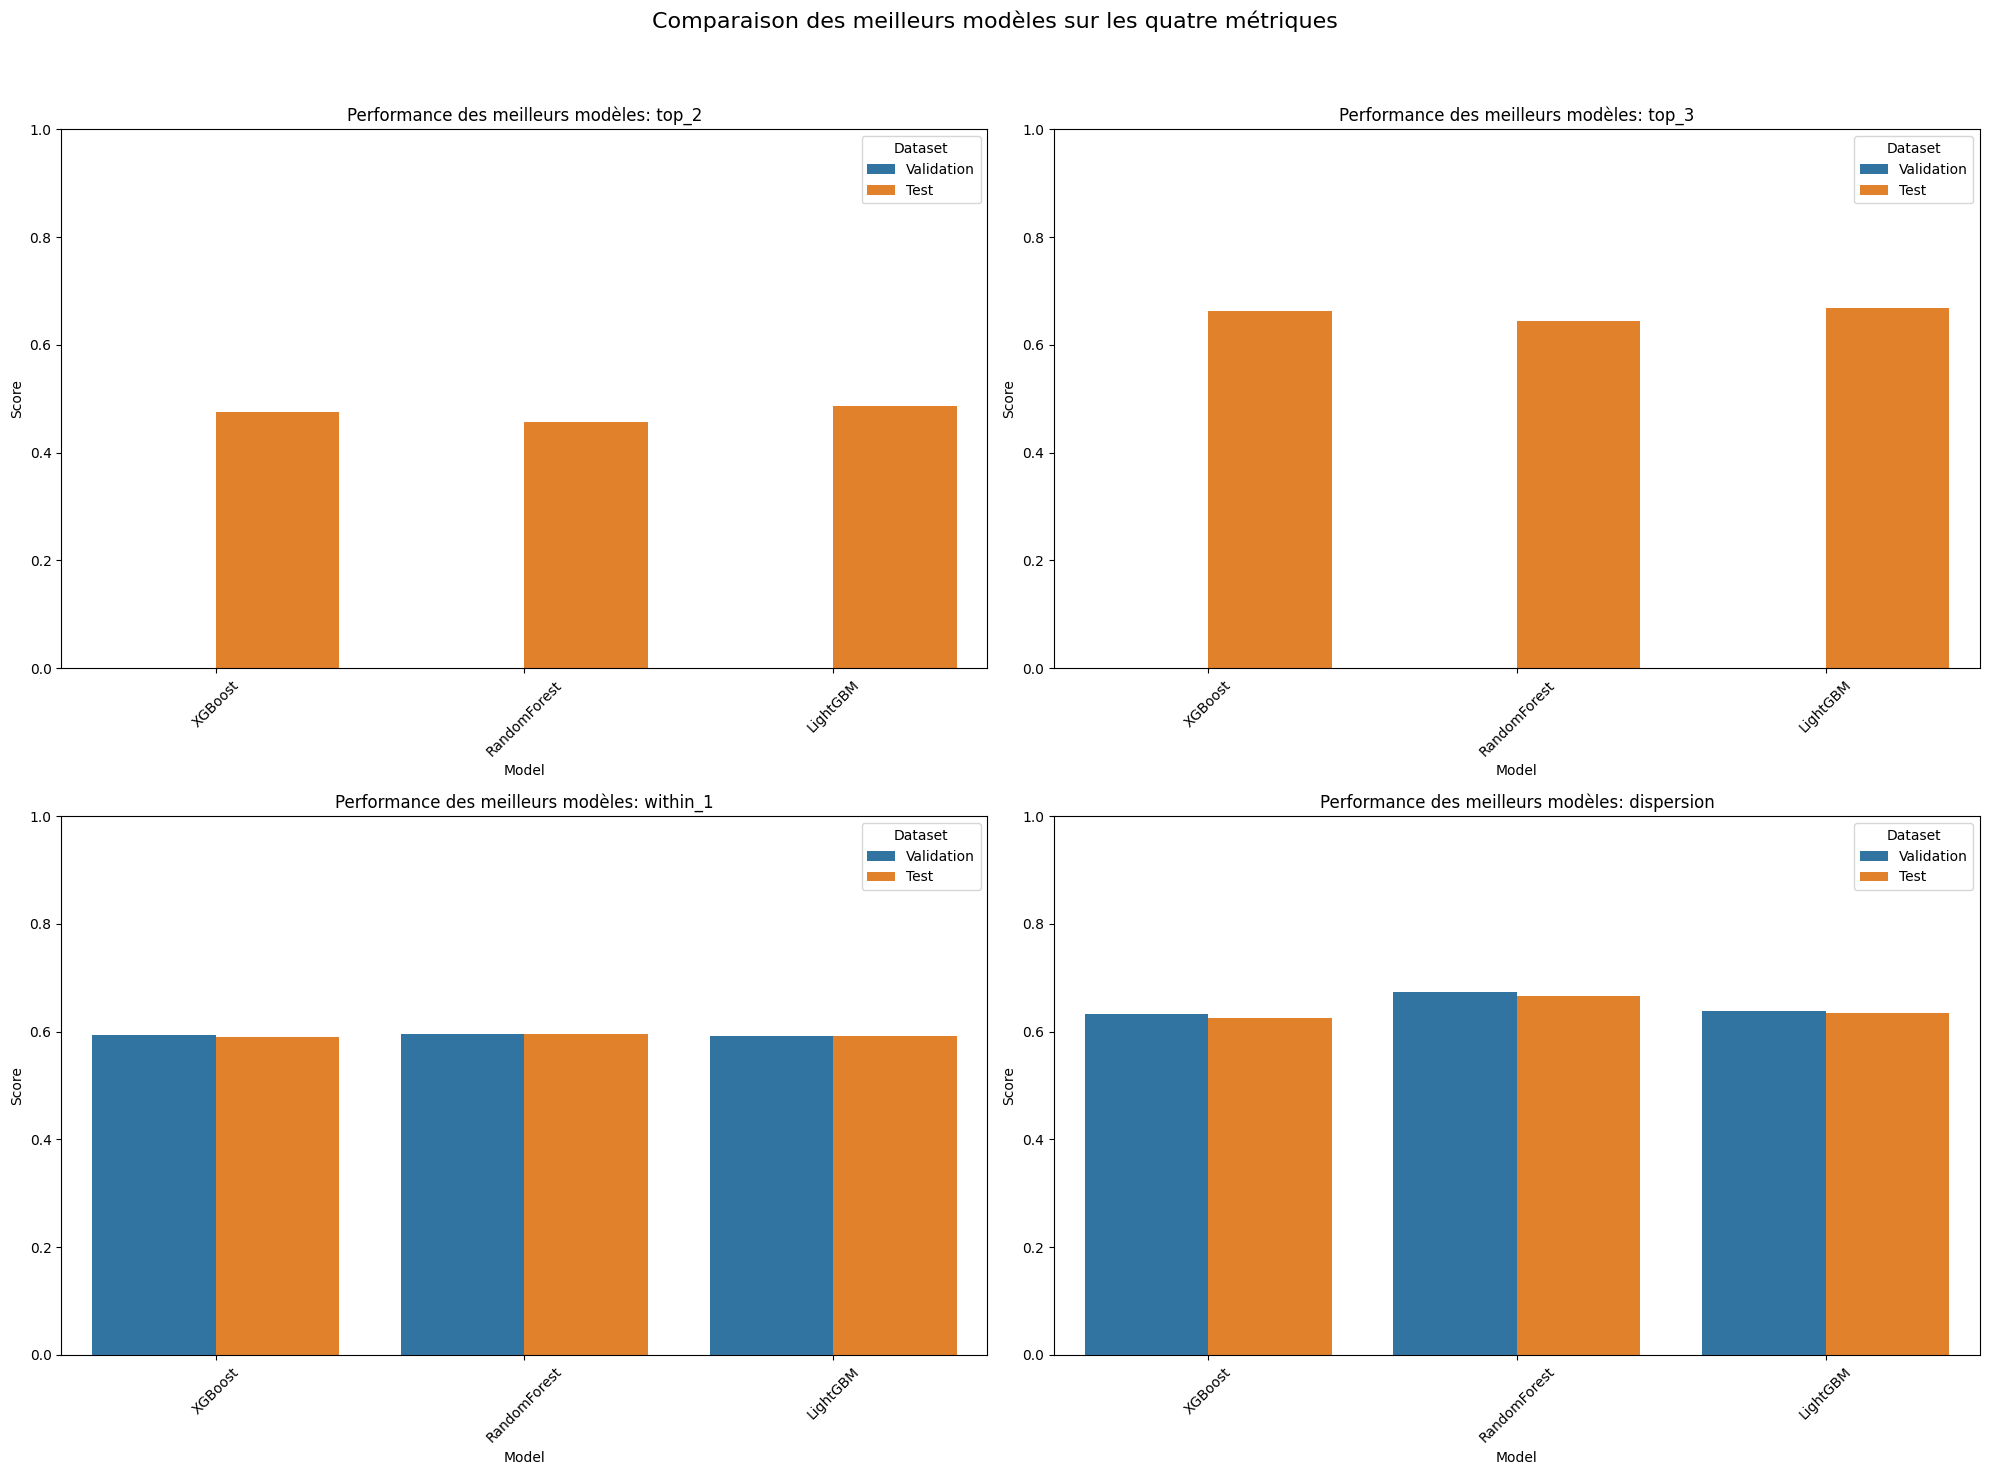

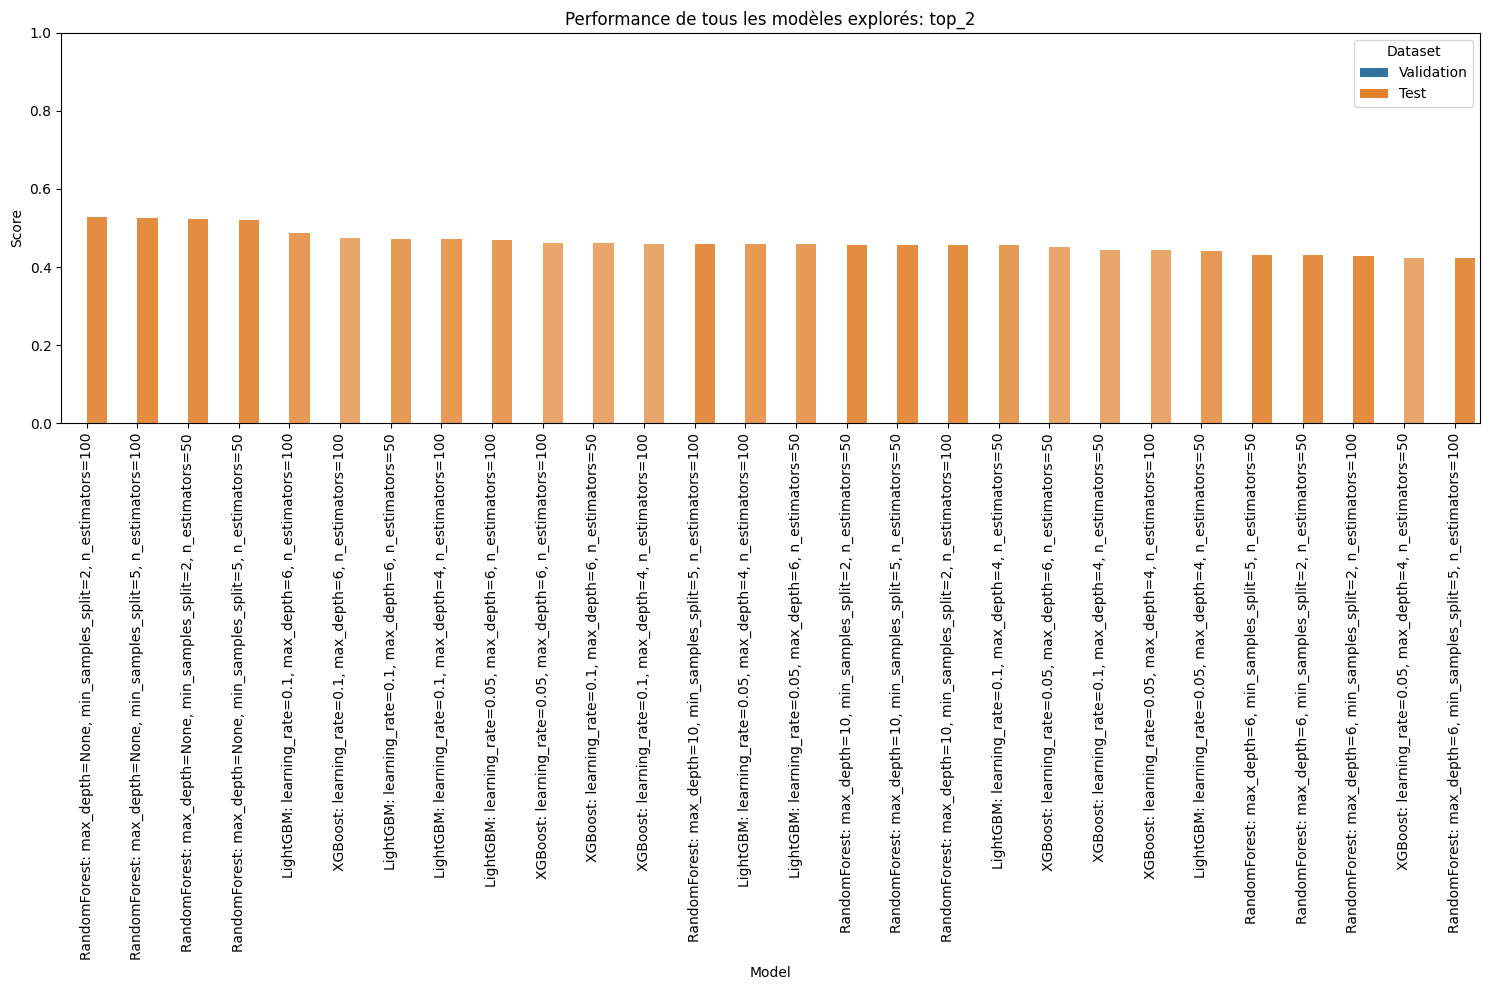

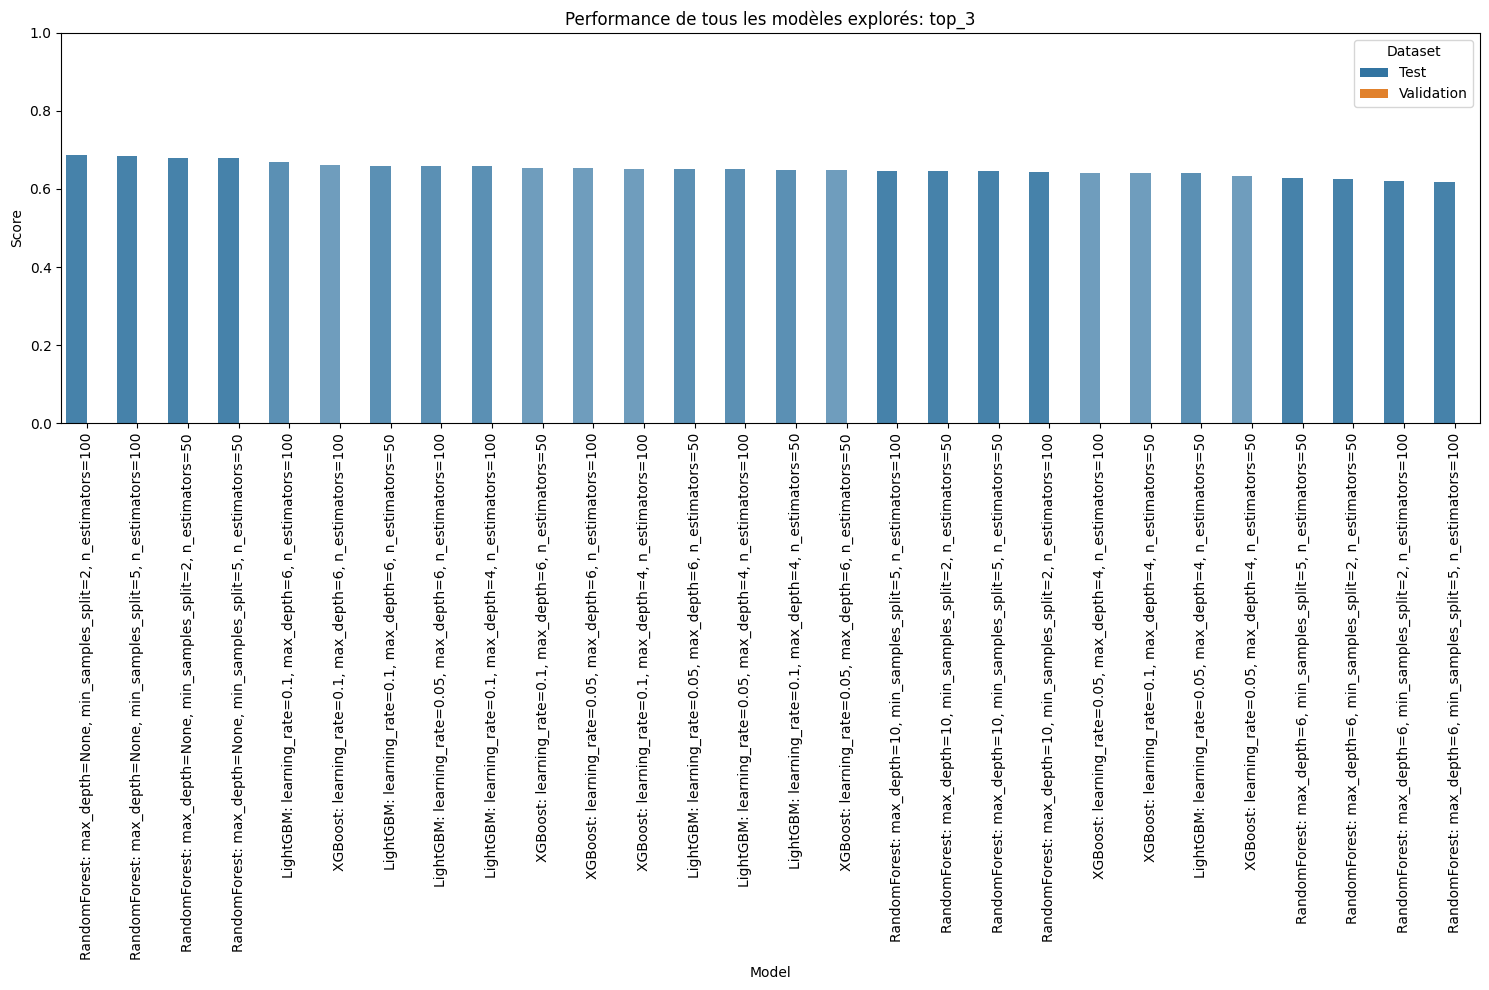

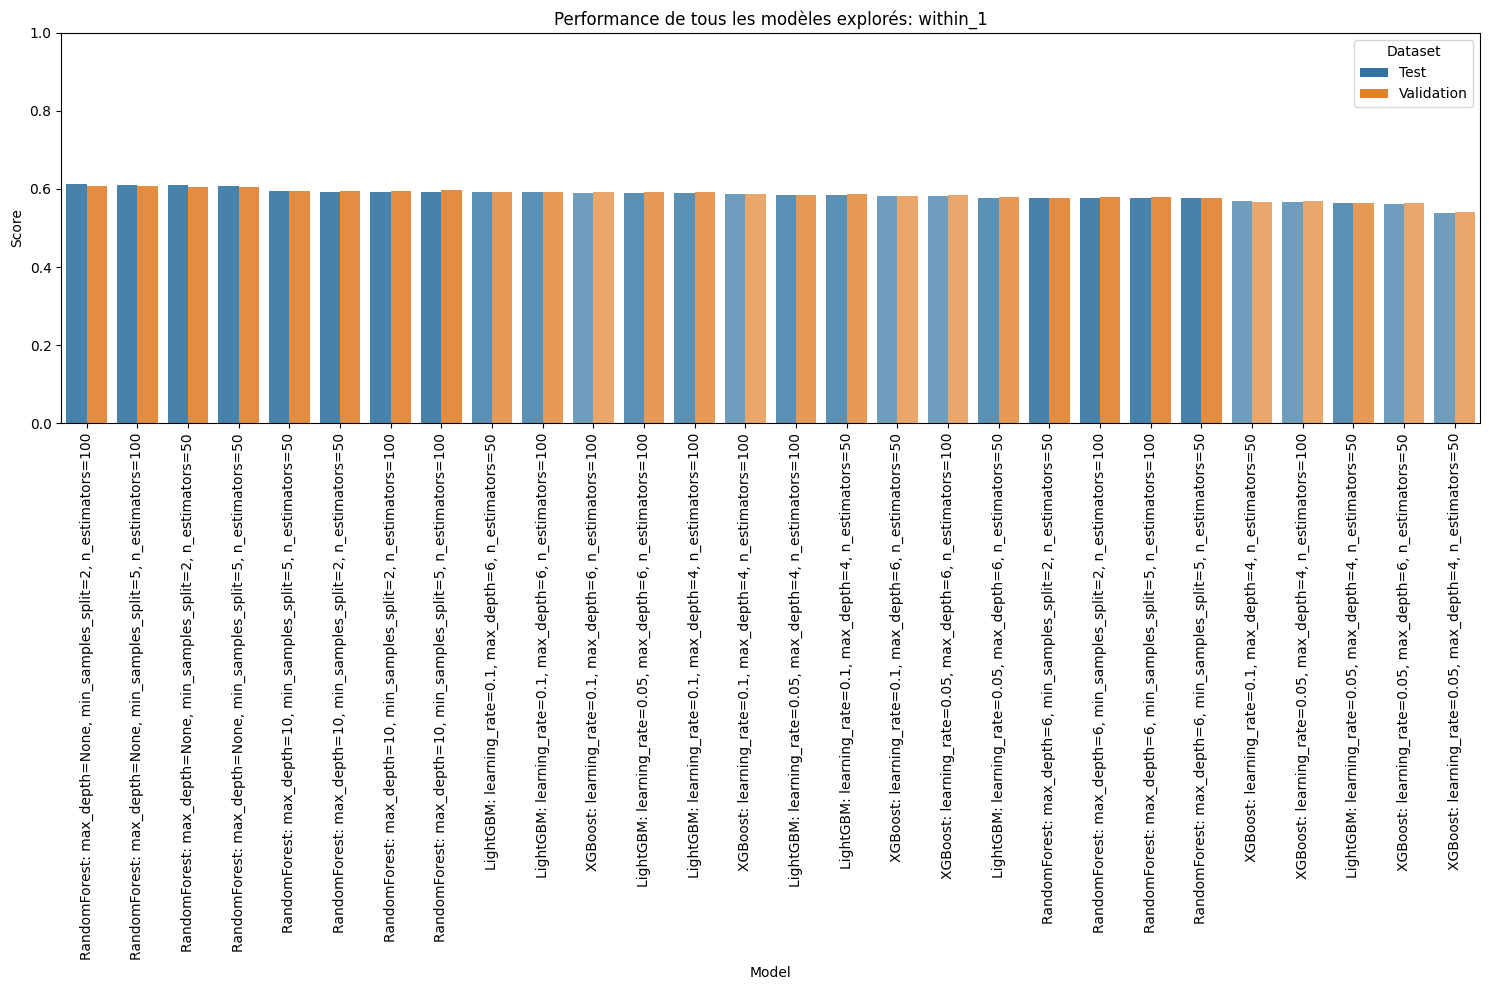

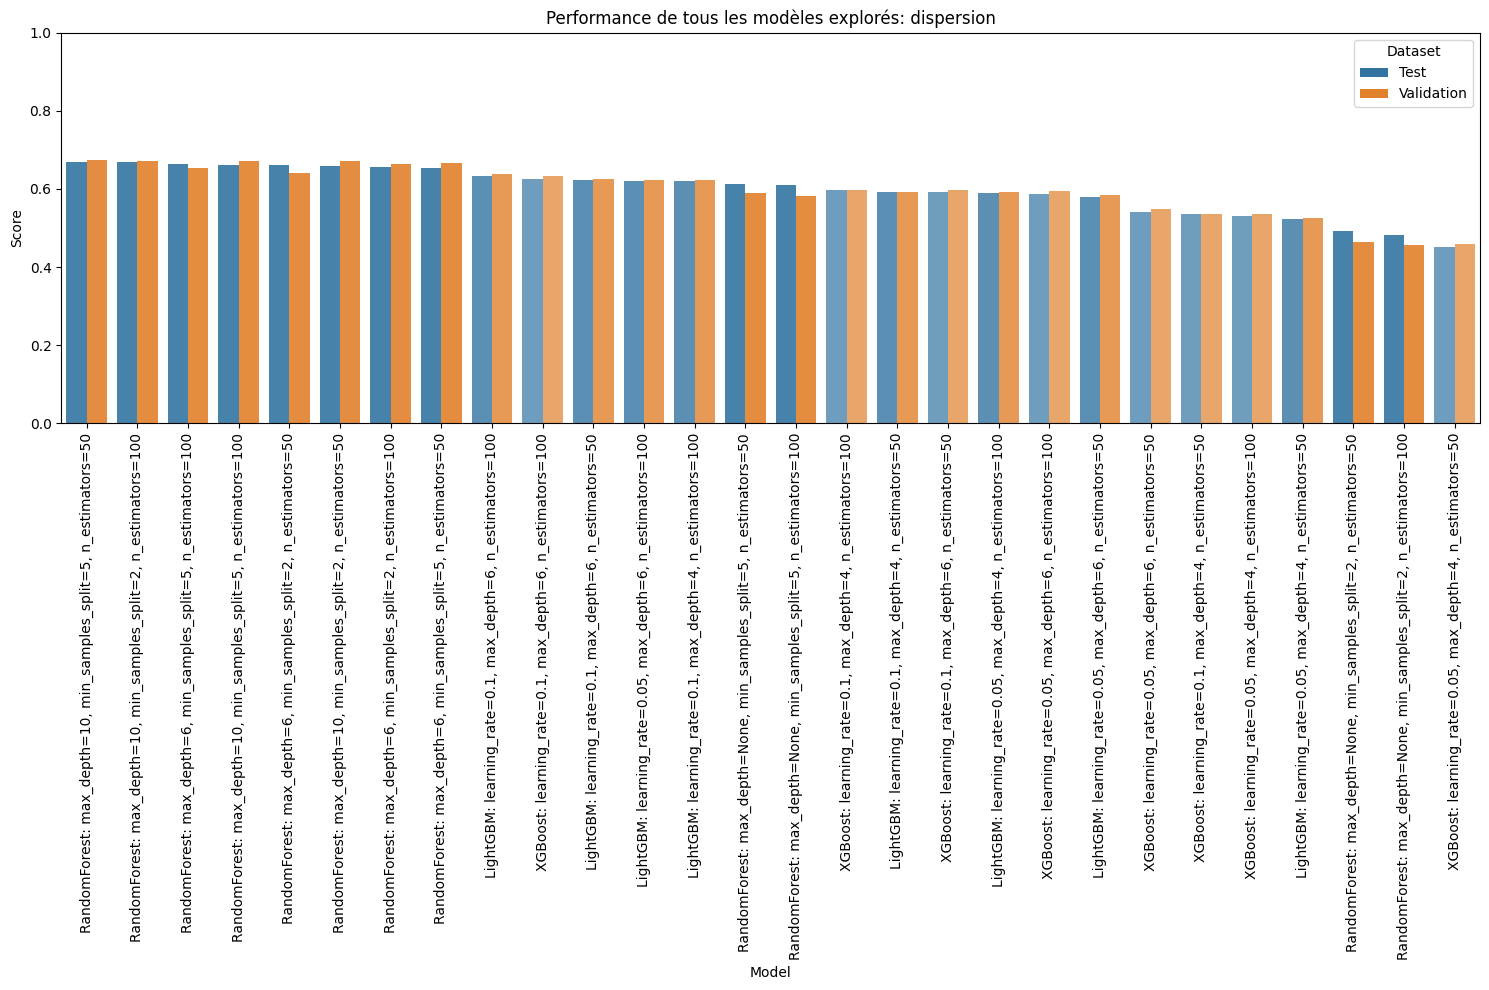

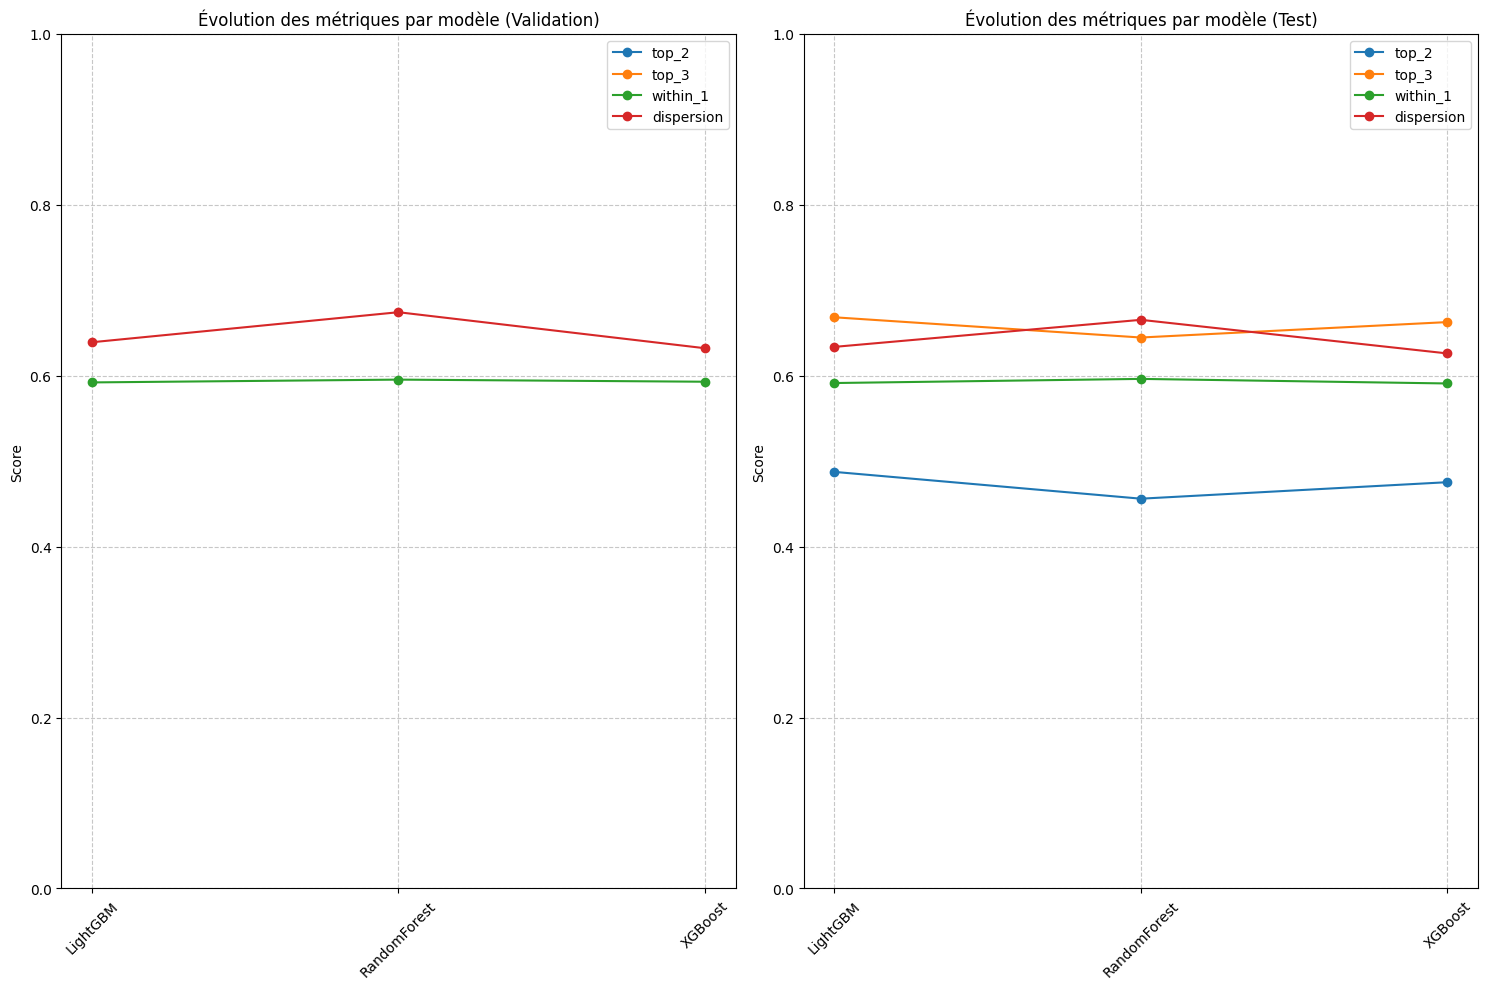

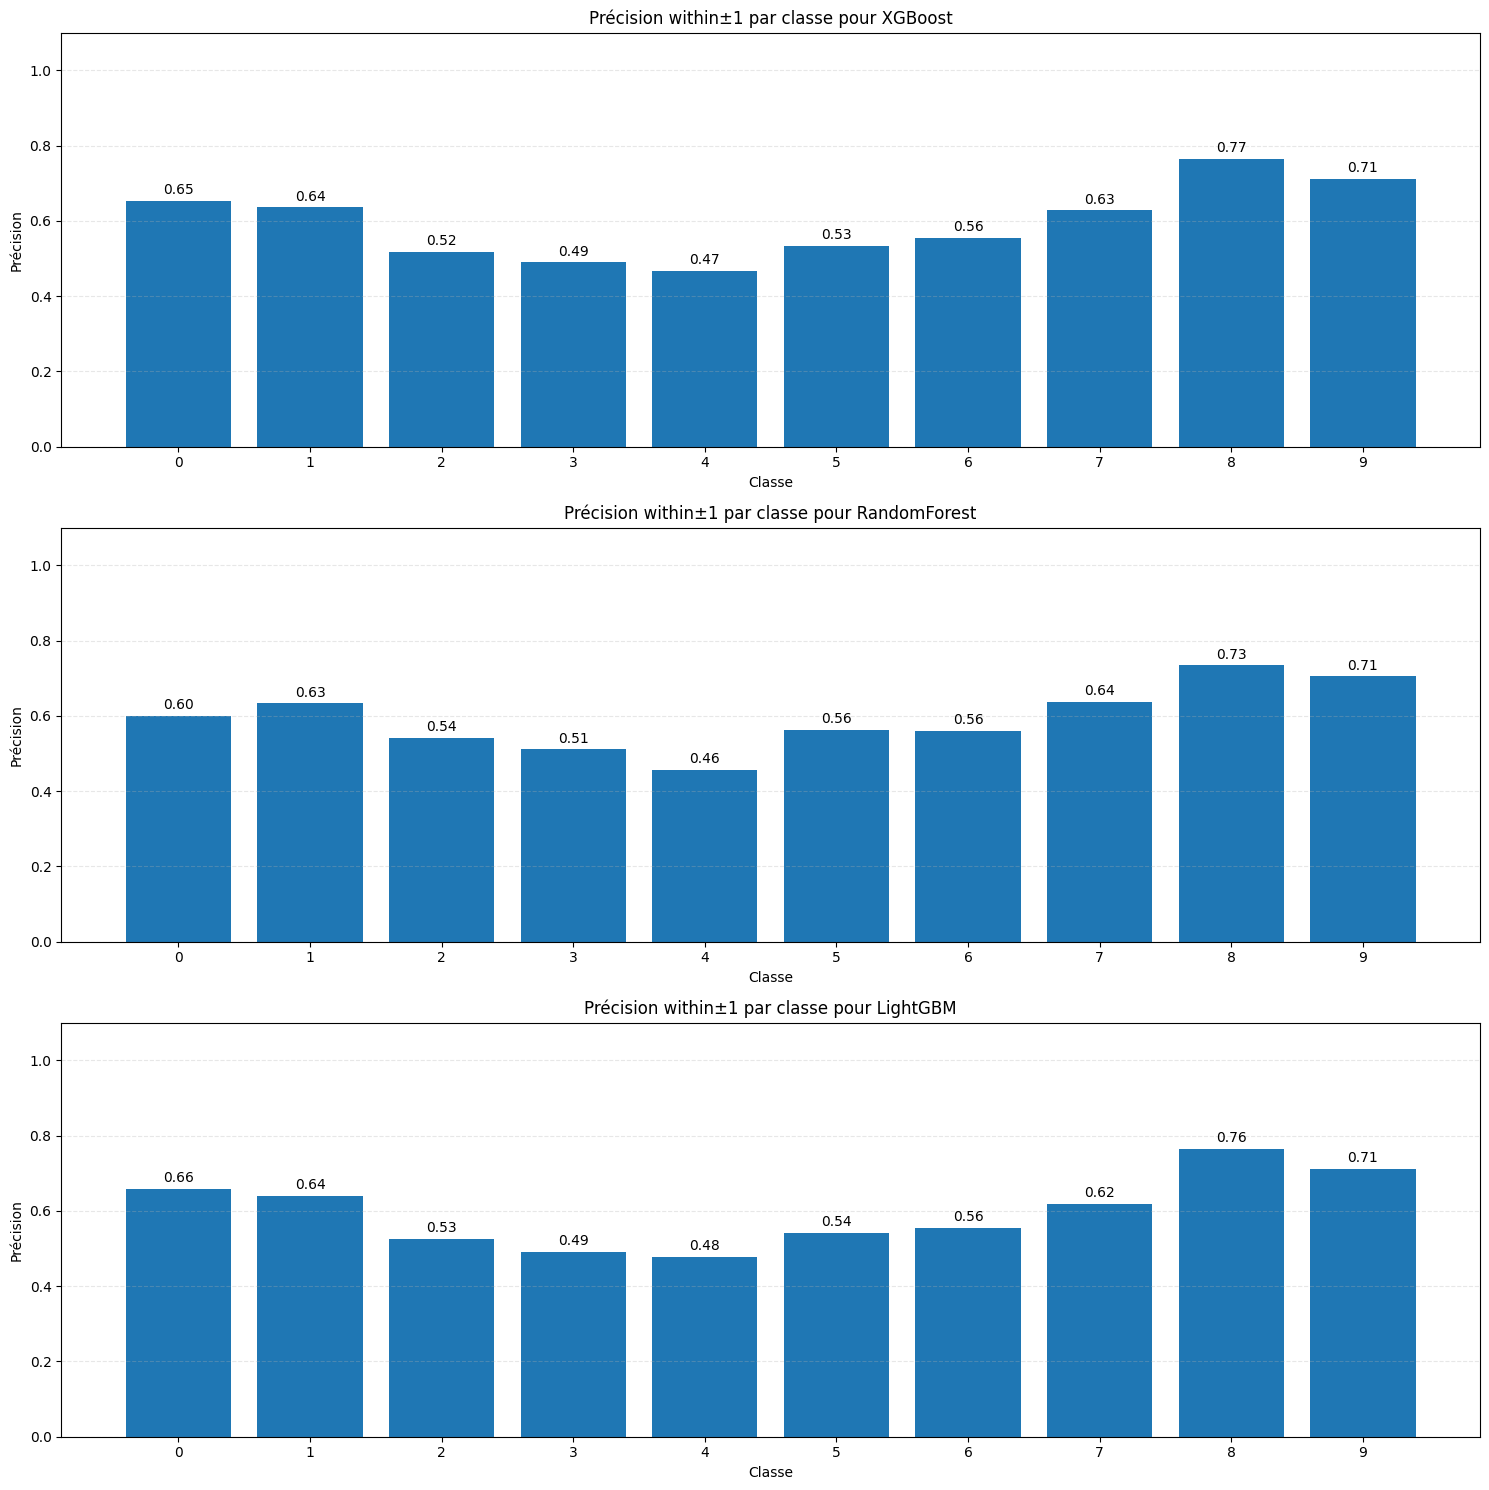

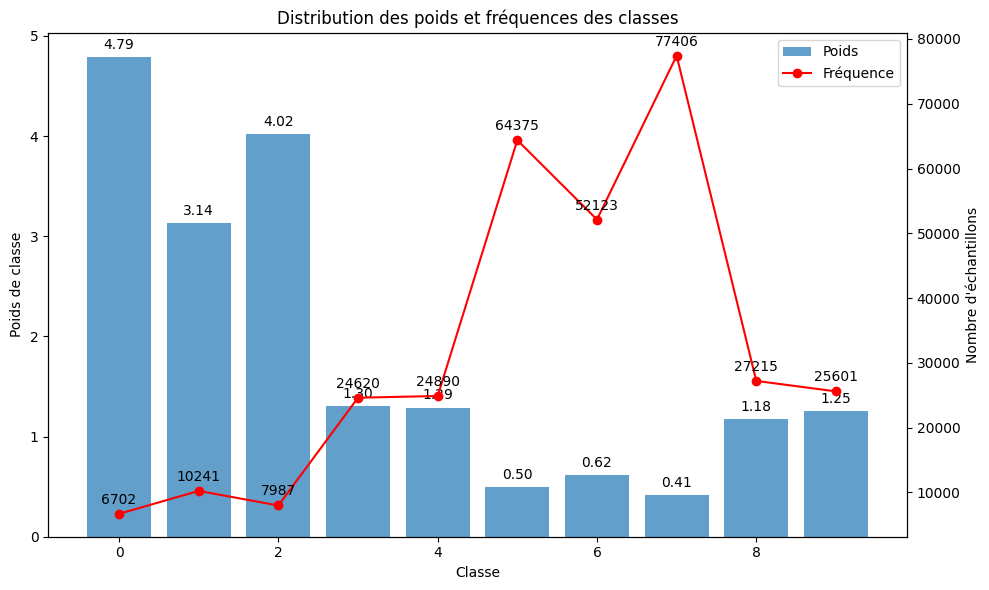


Top 10 des modèles par score within_1 sur l'ensemble de test:
                                                                  Model    Base_Model  test_top_2  test_top_3  test_within_1  test_dispersion  val_top_2  val_top_3  val_within_1  val_dispersion
17  RandomForest: max_depth=None, min_samples_split=2, n_estimators=100  RandomForest    0.527575    0.687682       0.612467         0.481323        NaN        NaN      0.608908        0.456665
19  RandomForest: max_depth=None, min_samples_split=5, n_estimators=100  RandomForest    0.524623    0.684531       0.610636         0.609196        NaN        NaN      0.608516        0.581700
16   RandomForest: max_depth=None, min_samples_split=2, n_estimators=50  RandomForest    0.522992    0.679437       0.610113         0.491275        NaN        NaN      0.605574        0.464614
18   RandomForest: max_depth=None, min_samples_split=5, n_estimators=50  RandomForest    0.520090    0.678640       0.607909         0.613054        NaN        N

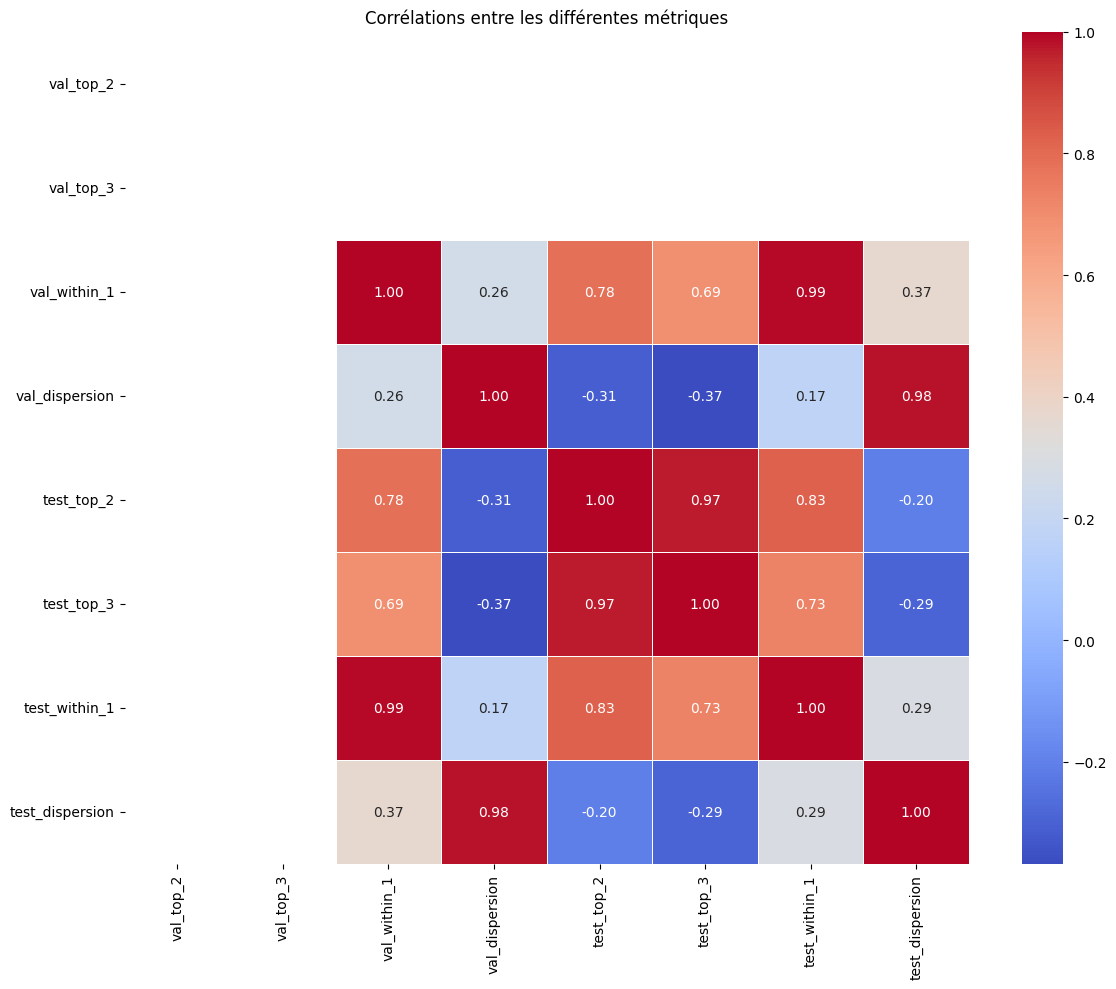

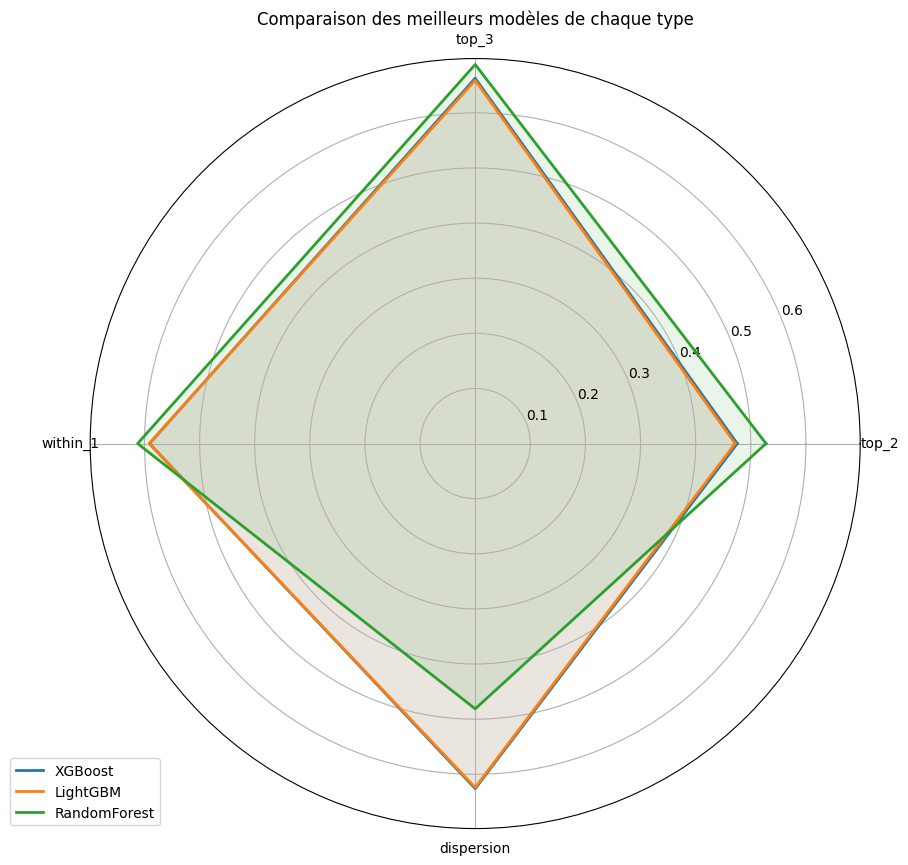

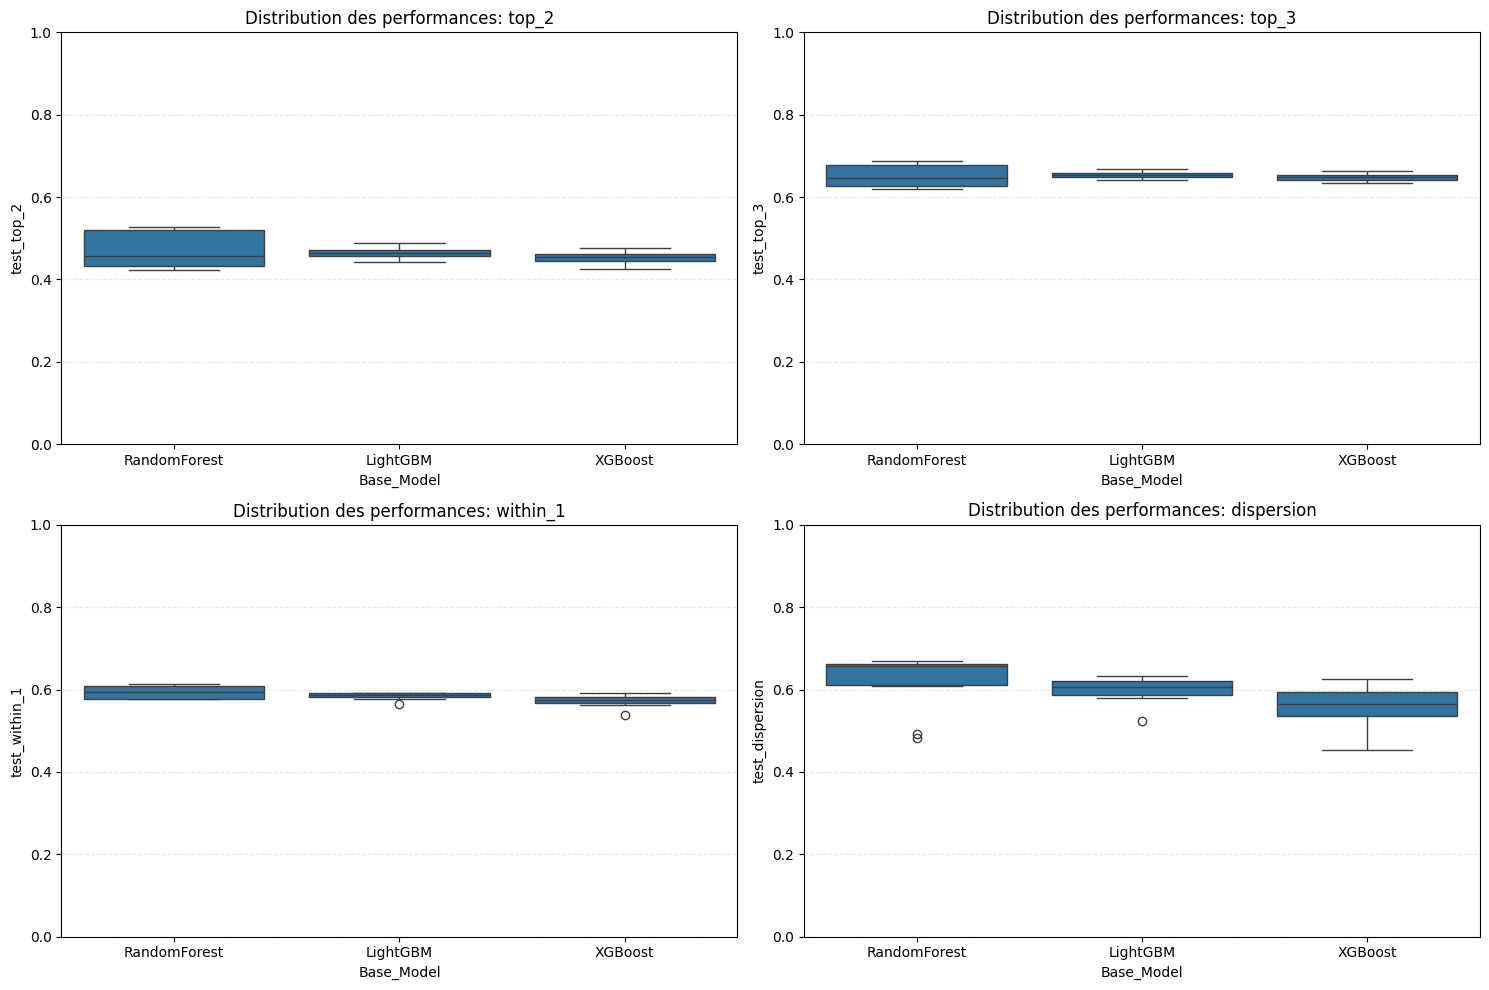

In [13]:
# Afficher les résultats
comparison_df = plot_multi_metric_results(
    results_dispersion, all_models_results_dispersion
)


In [17]:
# Tableau récapitulatif des meilleurs paramètres
print("\nMeilleurs paramètres par modèle:")
for model, result in all_models_results_dispersion.items():
    print(f"\n{model}:", result)
    for param, value in result["best_params"].items():
        print(f"  {param}: {value}")


Meilleurs paramètres par modèle:

XGBoost: [{'params': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50}, 'param_name': 'XGBoost: learning_rate=0.05, max_depth=4, n_estimators=50', 'validation_scores': {'top_2': np.float64(nan), 'top_3': np.float64(nan), 'within_1': np.float64(0.5415400371409893), 'dispersion': np.float64(0.4600152504183889)}, 'test_scores': {'top_2': np.float64(0.4242246855150081), 'top_3': np.float64(0.6329306264790135), 'within_1': np.float64(0.538124299414622), 'dispersion': np.float64(0.4521304425492012)}}, {'params': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}, 'param_name': 'XGBoost: learning_rate=0.05, max_depth=4, n_estimators=100', 'validation_scores': {'top_2': np.float64(nan), 'top_3': np.float64(nan), 'within_1': np.float64(0.5682650339114526), 'dispersion': np.float64(0.53526172355691)}, 'test_scores': {'top_2': np.float64(0.44410262797359573), 'top_3': np.float64(0.6418607547639805), 'within_1': np.float64(0.5677668451862), 'd

TypeError: list indices must be integers or slices, not str

### Best model

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    top_k_accuracy_score,
)

optimal_params = {"max_depth": 10, "min_samples_split": 5, "n_estimators": 50}

class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
sample_weights = np.array([class_weights[y] for y in y_train])

final_model = RandomForestClassifier(**optimal_params, random_state=42)
final_model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)


metrics = {
    "Top-2 Accuracy": top_k_accuracy_score(y_test, y_pred_proba, k=2),
    "Top-3 Accuracy": top_k_accuracy_score(y_test, y_pred_proba, k=3),
    "Within ±1 Accuracy": within_threshold_accuracy(y_test, y_pred, threshold=1),
    "Class Homogeneity": class_dispersion_score_vectorized(y_test, y_pred, threshold=1),
}

print("Performances du modèle final RandomForest:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

classes = np.unique(y_test)
class_accuracies = {}
for cls in classes:
    mask = y_test == cls
    if np.sum(mask) > 0:
        class_acc = np.mean(np.abs(y_test[mask] - y_pred[mask]) <= 1)
        class_accuracies[int(cls)] = class_acc



Performances du modèle final RandomForest:
Top-2 Accuracy: 0.4570
Top-3 Accuracy: 0.6446
Within ±1 Accuracy: 0.5943
Class Homogeneity: 0.6700


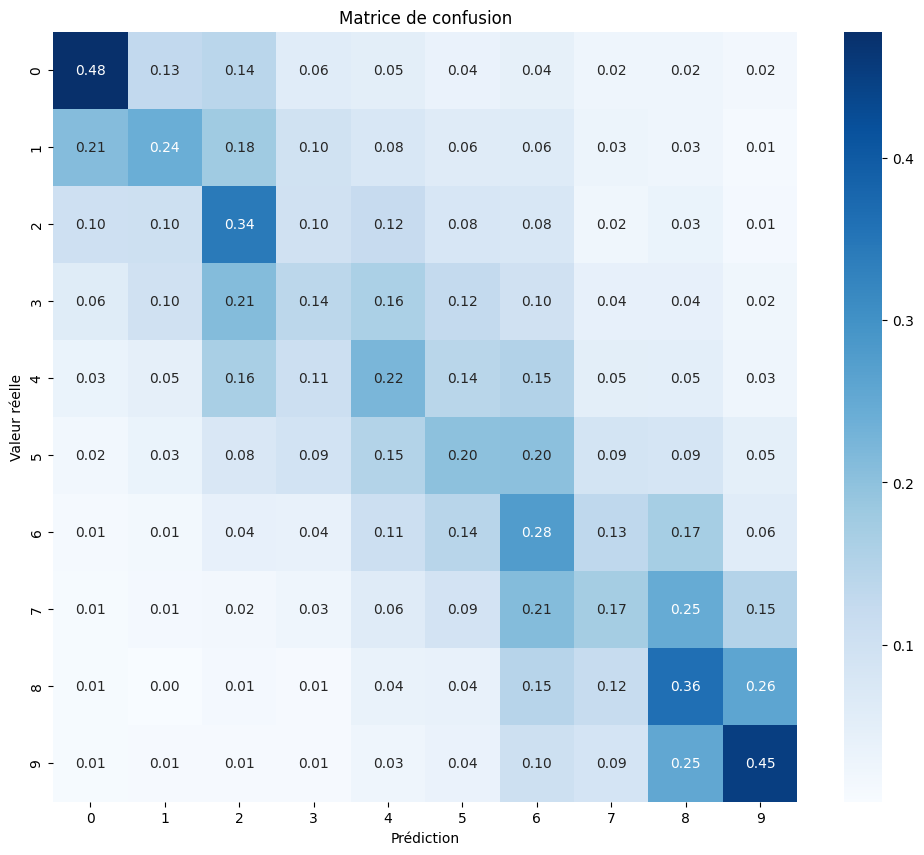

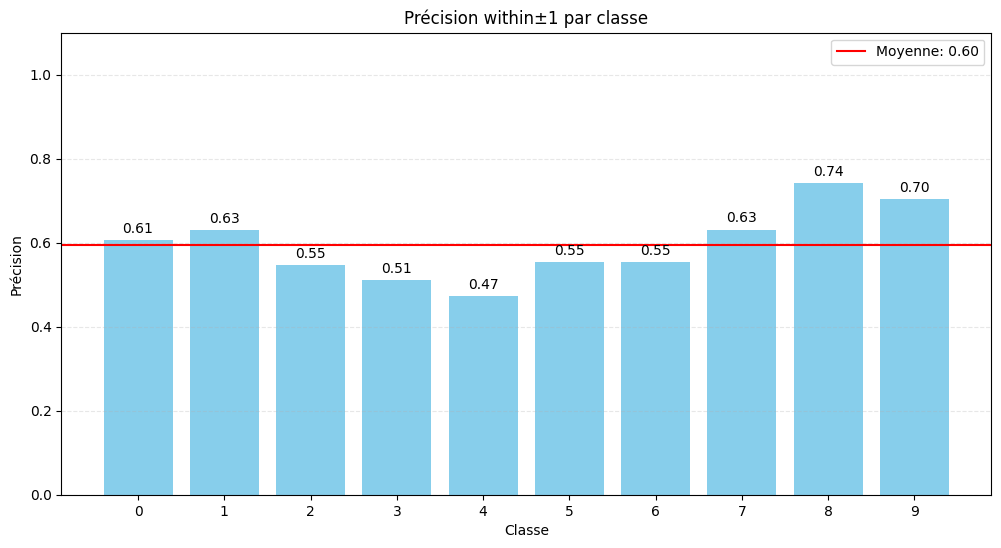

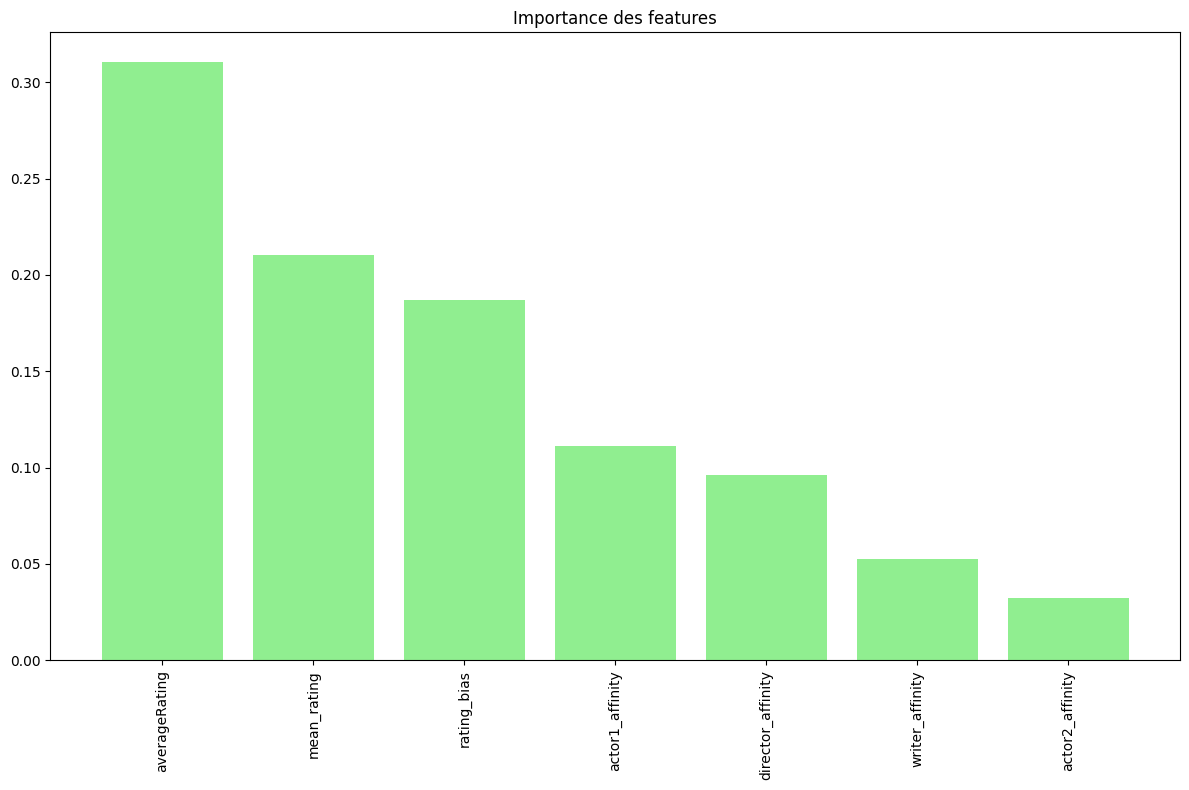

C:\Users\wwps1172\AppData\Local\Temp\ipykernel_16932\3577152282.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=errors, palette="viridis")


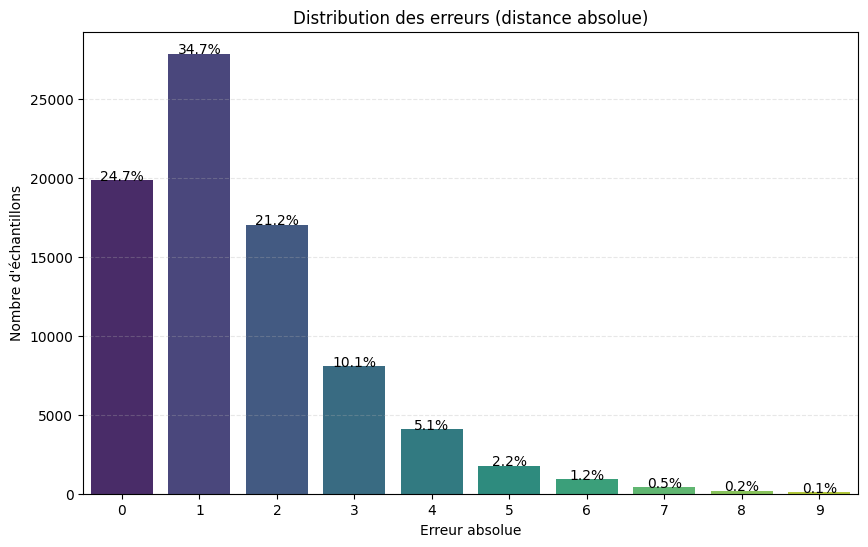

In [26]:
# 1. Matrice de confusion
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred, normalize="true")

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Valeur réelle")
plt.show()

# 2. Précision par classe
plt.figure(figsize=(12, 6))
classes_list = sorted(class_accuracies.keys())
accuracies = [class_accuracies[cls] for cls in classes_list]

bars = plt.bar(classes_list, accuracies, color="skyblue")
plt.axhline(
    y=np.mean(accuracies),
    color="r",
    linestyle="-",
    label=f"Moyenne: {np.mean(accuracies):.2f}",
)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{height:.2f}",
        ha="center",
        va="bottom",
    )

plt.title("Précision within±1 par classe")
plt.xlabel("Classe")
plt.ylabel("Précision")
plt.ylim(0, 1.1)
plt.xticks(classes_list)
plt.grid(True, linestyle="--", alpha=0.3, axis="y")
plt.legend()
plt.show()

# 3. Importance des features
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Importance des features")
plt.bar(
    range(X_train.shape[1]), importances[indices], align="center", color="lightgreen"
)
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# 4. Distribution des erreurs
errors = np.abs(y_test - y_pred)
plt.figure(figsize=(10, 6))
sns.countplot(x=errors, palette="viridis")
plt.title("Distribution des erreurs (distance absolue)")
plt.xlabel("Erreur absolue")
plt.ylabel("Nombre d'échantillons")
plt.grid(True, linestyle="--", alpha=0.3, axis="y")

# Ajouter les pourcentages sur les barres
total = len(errors)
for i, count in enumerate(np.bincount(errors)):
    if count > 0:
        plt.text(i, count + 5, f"{count/total*100:.1f}%", ha="center")

plt.show()

In [29]:
import joblib

joblib.dump(final_model, "./data/model/final_randomforest_model_dispersion.pkl")

['./data/model/final_randomforest_model_dispersion.pkl']

In [33]:
precision_per_class = precision_classes_per_class(y_test, y_pred, 1)
for cls, precision in precision_per_class.items():
    print(f"Précision pour la classe {cls}: {precision:.3f}")

Précision pour la classe 0: 0.605
Précision pour la classe 1: 0.630
Précision pour la classe 2: 0.548
Précision pour la classe 3: 0.510
Précision pour la classe 4: 0.473
Précision pour la classe 5: 0.554
Précision pour la classe 6: 0.554
Précision pour la classe 7: 0.631
Précision pour la classe 8: 0.742
Précision pour la classe 9: 0.705
